### Table of Contents

* [Data](#Data)
    * [loading data](#section_1_1)
    * [data check](#section_1_2)
* [Exploratory Data Analysis](#EDA)
    * [summary statistics](#section_2_1)
    * [label balance](#section_2_2)
    * [missing data](#section_2_3)
* [Data Prep](#DataPrep)
    * [preprocessing](#section_3_1)
* [Prediction](#Prediction)
    * [model building](#section_4_1)
        * [hyperparameter tuning](#section_4_1_1)
        * [model evaluation](#section_4_1_2)
* [Conclusion](#Conclusion)
    * [general comments](#section_5_1)
    * [next steps](#section_5_2)
* [Further Applications](#Further_Applications)
    * [retrieve data](#section_6_1)
    * [format data](#section_6_2)
    * [make predictions](#section_6_3)
    * [get moneylines](#section_6_4)
    * [kelly criterion](#section_6_5)
    * [determine bet size](#section_6_6)

### Data <a class="anchor" id="Data"></a>

The data for this project was downloaded from the SportRadar API:

[https://sportradar.us](https://sportradar.us)

More in depth information on the available data can be found in the documentation.

Some formatting inspiration for this analysis was sourced from [this notebook](https://www.kaggle.com/sharmasanthosh/exploratory-study-on-feature-selection).


#### loading data <a class="anchor" id="section_1_1"></a>

The data must be reformatted into rows comprised of home data, away data, and a binary variable for winner/loser. To explore the data, ii must be put into a dataframe with each team's win percentage as a column to investigate the relationships between variables.

In [246]:
APIKEY = '************************'

In [73]:
import warnings
pd.set_option('display.max_columns', None)
# remove warnings
warnings.filterwarnings('ignore')

In [62]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt

# read csv
train_df = pd.read_csv("data/train.csv") 

In [31]:
class PrerequisiteData:
    def __init__(self, APIKEY):
        self.api_key = APIKEY
        self.team_id_frame = self.create_team_id_frame()
        self.schedule_frame = self.get_schedule_frames()
        self.win_percents = self.rankings_frame()

    def create_team_id_frame(self, year=2015):
        time.sleep(1)
        url = 'https://api.sportradar.us/nba/trial/v7/en/seasons/{}/REG/rankings.json?api_key={}'.format(year, self.api_key)
        teams_json = requests.get(url).json()

        teams = []
        ids = []
        for conference in teams_json['conferences']:
            for division in conference['divisions']:
                for team in division['teams']:
                    teams.append(team['name'])
                    ids.append(team['id'])
        team_id_frame = pd.DataFrame({'team':teams, 'id':ids})
        
        team_id_frame.team = ['Toronto Raptors', 'Boston Celtics', 'New York Knicks', 'Brooklyn Nets', 
                             'Philadelphia 76ers', 'Cleveland Cavaliers',
       'Indiana Pacers', 'Detroit Pistons', 'Chicago Bulls', 'Milwaukee Bucks', 'Miami Heat', 'Atlanta Hawks',
                             'Charlotte Hornets',
       'Washington Wizards', 'Orlando Magic', 'Oklahoma City Thunder', 'Portland Trail Blazers', 'Utah Jazz',
                             'Denver Nuggets',
       'Minnesota Timberwolves', 'Golden State Warriors', 'Los Angeles Clippers', 'Sacramento Kings', 'Phoenix Suns',
                             'Los Angeles Lakers',
       'San Antonio Spurs', 'Dallas Mavericks', 'Memphis Grizzlies', 'Houston Rockets', 'New Orleans Pelicans']
        return team_id_frame


    def get_schedule(self, year):
        url = 'https://api.sportradar.us/nba/trial/v7/en/games/{}/REG/schedule.json?api_key={}'.format(year, self.api_key)
        schedule_json = requests.get(url).json()

        home = []
        away = []
        winner = []
        years = []
        for game in schedule_json['games']:
            try:
                if game['home_points'] > game['away_points']:
                    winner.append(game['home']['name'])
                else:
                    winner.append(game['away']['name'])
                home.append(game['home']['name'])
                away.append(game['away']['name'])
                years.append(year)
            except Exception:
                pass
        schedule_frame = pd.DataFrame({'home':home, 'away':away, 'winner':winner, 'year':years, 'winner_team':winner})
        return schedule_frame
    
    def get_schedule_frames(self, usable_years = [2015, 2016, 2017, 2018, 2019]):
        schedules_list = []
        for year in usable_years:
            time.sleep(1)
            data = self.get_schedule(year)
            schedules_list.append(data)

        schedule_frame = pd.concat(schedules_list)
        
        for i in range(len(schedule_frame)):
            if schedule_frame['winner'].iloc[i] == schedule_frame['home'].iloc[i]:
                schedule_frame['winner'].iloc[i] = 0
            else:
                schedule_frame['winner'].iloc[i] = 1
        
        schedule_frame = schedule_frame[schedule_frame.home != 'Eastern Conference']
        schedule_frame = schedule_frame[schedule_frame.home != 'Western Conference']
        schedule_frame = schedule_frame[schedule_frame.home != 'Team USA']
        schedule_frame = schedule_frame[schedule_frame.home != 'Team Stephen']
        schedule_frame = schedule_frame[schedule_frame.home != 'Team Giannis East']
        
        return schedule_frame
    
    def rankings_frame(self, usable_years = [2015, 2016, 2017, 2018, 2019]):
        rankings_list = []
        for year in usable_years:
            time.sleep(1)
            url = 'https://api.sportradar.us/nba/trial/v7/en/seasons/{}/REG/standings.json?api_key={}'.format(year, APIKEY)
            stands = requests.get(url).json()
            teams = []
            win_rates = []
            yearlist = []

            
            for conferences in stands['conferences']:
                for division in conferences['divisions']:
                    for team in division['teams']:
                        teams.append(team['name'])
                        win_rates.append(team['win_pct'])
                        yearlist.append(year)
            farm = pd.DataFrame({'teams':teams, 'winrate':win_rates, 'year':yearlist}).sort_values('teams')
            farm['teams'] = ['Philadelphia 76ers', 'Milwaukee Bucks', 'Chicago Bulls', 'Cleveland Cavaliers',
                                 'Boston Celtics', 'Los Angeles Clippers', 'Memphis Grizzlies', 'Atlanta Hawks',
                                 'Miami Heat',  'Charlotte Hornets', 'Utah Jazz', 'Sacramento Kings', 'New York Knicks', 
                                 'Los Angeles Lakers', 'Orlando Magic', 'Dallas Mavericks', 'Brooklyn Nets',  'Denver Nuggets',
                                  'Indiana Pacers', 'New Orleans Pelicans', 'Detroit Pistons', 'Toronto Raptors', 'Houston Rockets', 
                                 'San Antonio Spurs', 'Phoenix Suns', 'Oklahoma City Thunder', 'Minnesota Timberwolves', 'Portland Trail Blazers', 
                                  'Golden State Warriors', 'Washington Wizards']
            rankings_list.append(farm)
        final_rank_frame = pd.concat(rankings_list)
        return final_rank_frame

In [36]:
class StatisticalAcquisition():
    
    def __init__(self, api_key, usable_years = [2015,2016, 2017, 2018, 2019]):
        self.prerequisite_instance = PrerequisiteData(api_key)
        self.api_key = self.prerequisite_instance.api_key
        self.team_id_frame = self.prerequisite_instance.team_id_frame
        self.schedule_frame = self.prerequisite_instance.schedule_frame
        self.percent_frame = self.prerequisite_instance.win_percents
        self.usable_years = usable_years
        self.all_years_team_stats = self.get_all_years_stats_frame()
        self.final_frame = self.final_data_frame()
        self.final_percent_frame = self.rankings_with_data()

    def get_team_stats(self, team, year):
        team_id = self.team_id_frame[self.team_id_frame.team == team].id.values[0]

        url = 'https://api.sportradar.us/nba/trial/v7/en/seasons/{}/REG/teams/{}/statistics.json?api_key={}'.format(year, team_id, self.api_key)
        stats_json = requests.get(url).json()

        average_team_stats = {}
        average_team_stats['fast_break_pts'] = stats_json['own_record']['average']['fast_break_pts']
        average_team_stats['turnover_points'] = stats_json['own_record']['average']['points_off_turnovers']
        average_team_stats['second_chance_points'] = stats_json['own_record']['average']['second_chance_pts']
        average_team_stats['points'] = stats_json['own_record']['average']['points']
        average_team_stats['offensive_rebounds'] = stats_json['own_record']['average']['off_rebounds']
        average_team_stats['defensive_rebounds'] = stats_json['own_record']['average']['def_rebounds']
        average_team_stats['rebounds'] = stats_json['own_record']['average']['rebounds']
        average_team_stats['assists'] = stats_json['own_record']['average']['assists']
        average_team_stats['steals'] = stats_json['own_record']['average']['steals']
        average_team_stats['blocks'] = stats_json['own_record']['average']['blocks']
        average_team_stats['turnovers'] = stats_json['own_record']['average']['turnovers']
        average_team_stats['personal_fouls'] = stats_json['own_record']['average']['personal_fouls']
        average_team_stats['flagrants'] = stats_json['own_record']['average']['flagrant_fouls']
        average_team_stats['blocked_att'] = stats_json['own_record']['average']['blocked_att']
        average_team_stats['field_goals_pct'] = (stats_json['own_record']['average']['field_goals_made'] / 
                                                 stats_json['own_record']['average']['field_goals_att'])
        average_team_stats['three_point_pct'] = (stats_json['own_record']['average']['three_points_made'] / 
                                                 stats_json['own_record']['average']['three_points_att'])
        average_team_stats['two_point_pct'] = (stats_json['own_record']['average']['two_points_made'] / 
                                                 stats_json['own_record']['average']['two_points_att'])
        average_team_stats['free_throw_pct'] = (stats_json['own_record']['average']['free_throws_made'] / 
                                                 stats_json['own_record']['average']['free_throws_att'])
        average_team_stats['points_in_paint_pct'] = (stats_json['own_record']['average']['points_in_paint_made'])
        average_team_stats['fast_break_pct'] = (stats_json['own_record']['average']['fast_break_made'])
        average_team_stats['second_chance_pct'] = (stats_json['own_record']['average']['second_chance_made'])
        average_team_stats['points_in_paint'] = stats_json['own_record']['average']['points_in_paint']
        average_team_stats['efficiency'] = stats_json['own_record']['average']['efficiency']
        average_team_stats['bench_points'] = stats_json['own_record']['average']['bench_points']
        average_team_stats['fouls_drawn'] = stats_json['own_record']['average']['fouls_drawn']
        average_team_stats['offensive_fouls'] = stats_json['own_record']['average']['offensive_fouls']
        average_team_stats['year'] = year

        team_stat_frame = pd.DataFrame(average_team_stats, index=[team])
        return team_stat_frame
    

    def get_all_years_stats_frame(self):
        all_years_team_stats = []
        for year in self.usable_years:
            for team in list(self.team_id_frame.team.values):
                time.sleep(1)
                data = self.get_team_stats(team, year)
                all_years_team_stats.append(data)
                
        all_years_team_stats = pd.concat(all_years_team_stats)
        time.sleep(1)
        return all_years_team_stats
    
    def final_data_frame(self):
        final_frame_list = []
        for i in range(len(self.schedule_frame)):
            home = self.schedule_frame.home.iloc[i]
            away = self.schedule_frame.away.iloc[i]
            year = self.schedule_frame.year.iloc[i]
            winner = self.schedule_frame.winner.iloc[i]

            home_data = pd.DataFrame(self.all_years_team_stats[self.all_years_team_stats['year'] == year].loc[home]).T.reset_index()
            home_data.columns = [x+'_home' for x in list(home_data.columns.values)]

            away_data = pd.DataFrame(self.all_years_team_stats[self.all_years_team_stats['year'] == year].loc[away]).T.reset_index()
            away_data.columns = [x+'_away' for x in list(away_data.columns.values)]

            winner_data = pd.DataFrame({'winner': winner}, index=[0])
            combined_data = pd.concat([home_data, away_data, winner_data], axis=1)

            final_frame_list.append(combined_data)
        
        final_frame = pd.concat(final_frame_list)

        final_frame.drop('points_in_paint_pct_home', axis=1, inplace=True)
        final_frame.drop('fast_break_pct_home', axis=1, inplace=True)
        final_frame.drop('second_chance_pct_home', axis=1, inplace=True)
        final_frame.drop('fouls_drawn_home', axis=1, inplace=True)
        final_frame.drop('offensive_fouls_home', axis=1, inplace=True)
        final_frame.drop('year_home', axis=1, inplace=True)
        final_frame.drop('index_home', axis=1, inplace=True)

        final_frame.drop('points_in_paint_pct_away', axis=1, inplace=True)
        final_frame.drop('fast_break_pct_away', axis=1, inplace=True)
        final_frame.drop('second_chance_pct_away', axis=1, inplace=True)
        final_frame.drop('fouls_drawn_away', axis=1, inplace=True)
        final_frame.drop('offensive_fouls_away', axis=1, inplace=True)
        final_frame.drop('year_away', axis=1, inplace=True)
        final_frame.drop('index_away', axis=1, inplace=True)
        
        return final_frame
    
    def rankings_with_data(self):
        final_pct_list = []
        for i in range(len(self.percent_frame)):
            team = self.percent_frame.iloc[i]['teams']
            win_rate = self.percent_frame.iloc[i]['winrate']
            year = self.percent_frame.iloc[i]['year']
            
            team_data = pd.DataFrame(self.all_years_team_stats[self.all_years_team_stats['year'] == year].loc[team], index=[team])
            final_pct_list.append(team_data)
        final_pct_frame = pd.concat(final_pct_list)
        return final_pct_frame

In [37]:
data = StatisticalAcquisition(APIKEY)

In [71]:
all_years_stats = data.all_years_team_stats
all_years_percents = data.percent_frame

alld = []
for i in range(len(all_years_percents)):
    team = all_years_percents.iloc[i]['teams']
    win_pct = all_years_percents.iloc[i]['winrate']
    year = all_years_percents.iloc[i]['year']
    
    team_data = all_years_stats[all_years_stats['year'] == year].loc[team]
    team_data['winrate'] = win_pct
    alld.append(team_data)
all_data = pd.concat(alld, axis=1).T

#### data check <a class="anchor" id="section_1_2"></a>

Here the first six rows are explored: there are 15,120 rows and 56 columns. The very last column called `Cover_Type` is the response variable that will be classified.

In [74]:
# rows and columns
print(all_data.shape)

# check first six rows
all_data.head(6)

(150, 28)


,fast_break_pts,turnover_points,second_chance_points,points,offensive_rebounds,defensive_rebounds,rebounds,assists,steals,blocks,turnovers,personal_fouls,flagrants,blocked_att,field_goals_pct,three_point_pct,two_point_pct,free_throw_pct,points_in_paint_pct,fast_break_pct,second_chance_pct,points_in_paint,efficiency,bench_points,fouls_drawn,offensive_fouls,year,winrate
Philadelphia 76ers,11.37,17.93,12.54,97.4,9.48,31.77,41.24,21.5,8.29,6.04,16.38,21.71,0.04,5.68,0.431242,0.338909,0.476190,0.694149,0.0,0.0,0.0,43.20,103.45,3.04,0.0,0.0,2015.0,0.122
Milwaukee Bucks,13.49,18.91,12.40,99.0,10.46,31.21,41.67,23.1,8.20,5.79,15.21,20.67,0.09,5.63,0.466545,0.344894,0.495197,0.747359,0.0,0.0,0.0,50.54,113.02,0.51,0.0,0.0,2015.0,0.402
Chicago Bulls,9.95,13.50,13.91,101.6,11.06,35.23,46.29,22.8,6.04,5.73,13.91,18.84,0.01,5.67,0.441446,0.371375,0.464124,0.786940,0.0,0.0,0.0,40.98,115.29,1.01,0.0,0.0,2015.0,0.512
Cleveland Cavaliers,11.41,16.78,13.41,104.3,10.65,33.87,44.51,22.7,6.72,3.87,13.59,20.32,0.09,4.41,0.460357,0.362378,0.513697,0.747930,0.0,0.0,0.0,40.83,117.72,0.76,0.0,0.0,2015.0,0.695
Boston Celtics,15.29,20.06,14.95,105.7,11.59,33.33,44.91,24.2,9.17,4.24,13.74,21.90,0.05,5.49,0.439489,0.334609,0.482890,0.788265,0.0,0.0,0.0,45.90,119.45,2.26,0.0,0.0,2015.0,0.585
Los Angeles Clippers,12.26,17.70,11.10,104.5,8.79,33.26,42.05,22.8,8.65,5.61,12.96,21.29,0.02,3.16,0.464637,0.363909,0.513101,0.692454,0.0,0.0,0.0,37.68,118.49,2.15,0.0,0.0,2015.0,0.646


### Exploratory Data Analysis <a class="anchor" id="EDA"></a>



In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set figure size
plt.rcParams['figure.figsize'] = [5, 5]

# show unlimited columns
pd.set_option('display.max_columns', None)

#### summary statistics <a class="anchor" id="section_2_1"></a>

The `describe` function is used to check out the dataset more carefully.
Upon inspection it looks like `Soil_Type7` and `Soil_Type15` are comprised of all zeros and can be removed. Another way of checking the two columns with zeros would be to looks for columns with `std` equal to 0.  

In [76]:
# describe data with summary stats
print(all_data.describe())

       fast_break_pts  turnover_points  second_chance_points      points  \
count      150.000000       150.000000            150.000000  150.000000   
mean        13.019733        16.528867             12.906667  107.495333   
std          2.883914         1.546339              1.295345    5.203320   
min          7.710000        11.840000              9.890000   97.300000   
25%         10.820000        15.420000             11.907500  103.400000   
50%         12.410000        16.505000             13.050000  106.850000   
75%         14.635000        17.420000             13.660000  111.775000   
max         22.570000        21.170000             16.150000  118.700000   

       offensive_rebounds  defensive_rebounds    rebounds     assists  \
count          150.000000          150.000000  150.000000  150.000000   
mean            10.140133           34.010133   44.149800   23.419333   
std              1.039617            1.698773    1.995313    2.216009   
min              7.8900

Now one can look at the distributions for the data. From a personal viewpoint, violin plots are way more powerful than the histogram or the box plot because it shows distributions and facets the data by another variable (in this case the response) to show more dimensions of the data. 

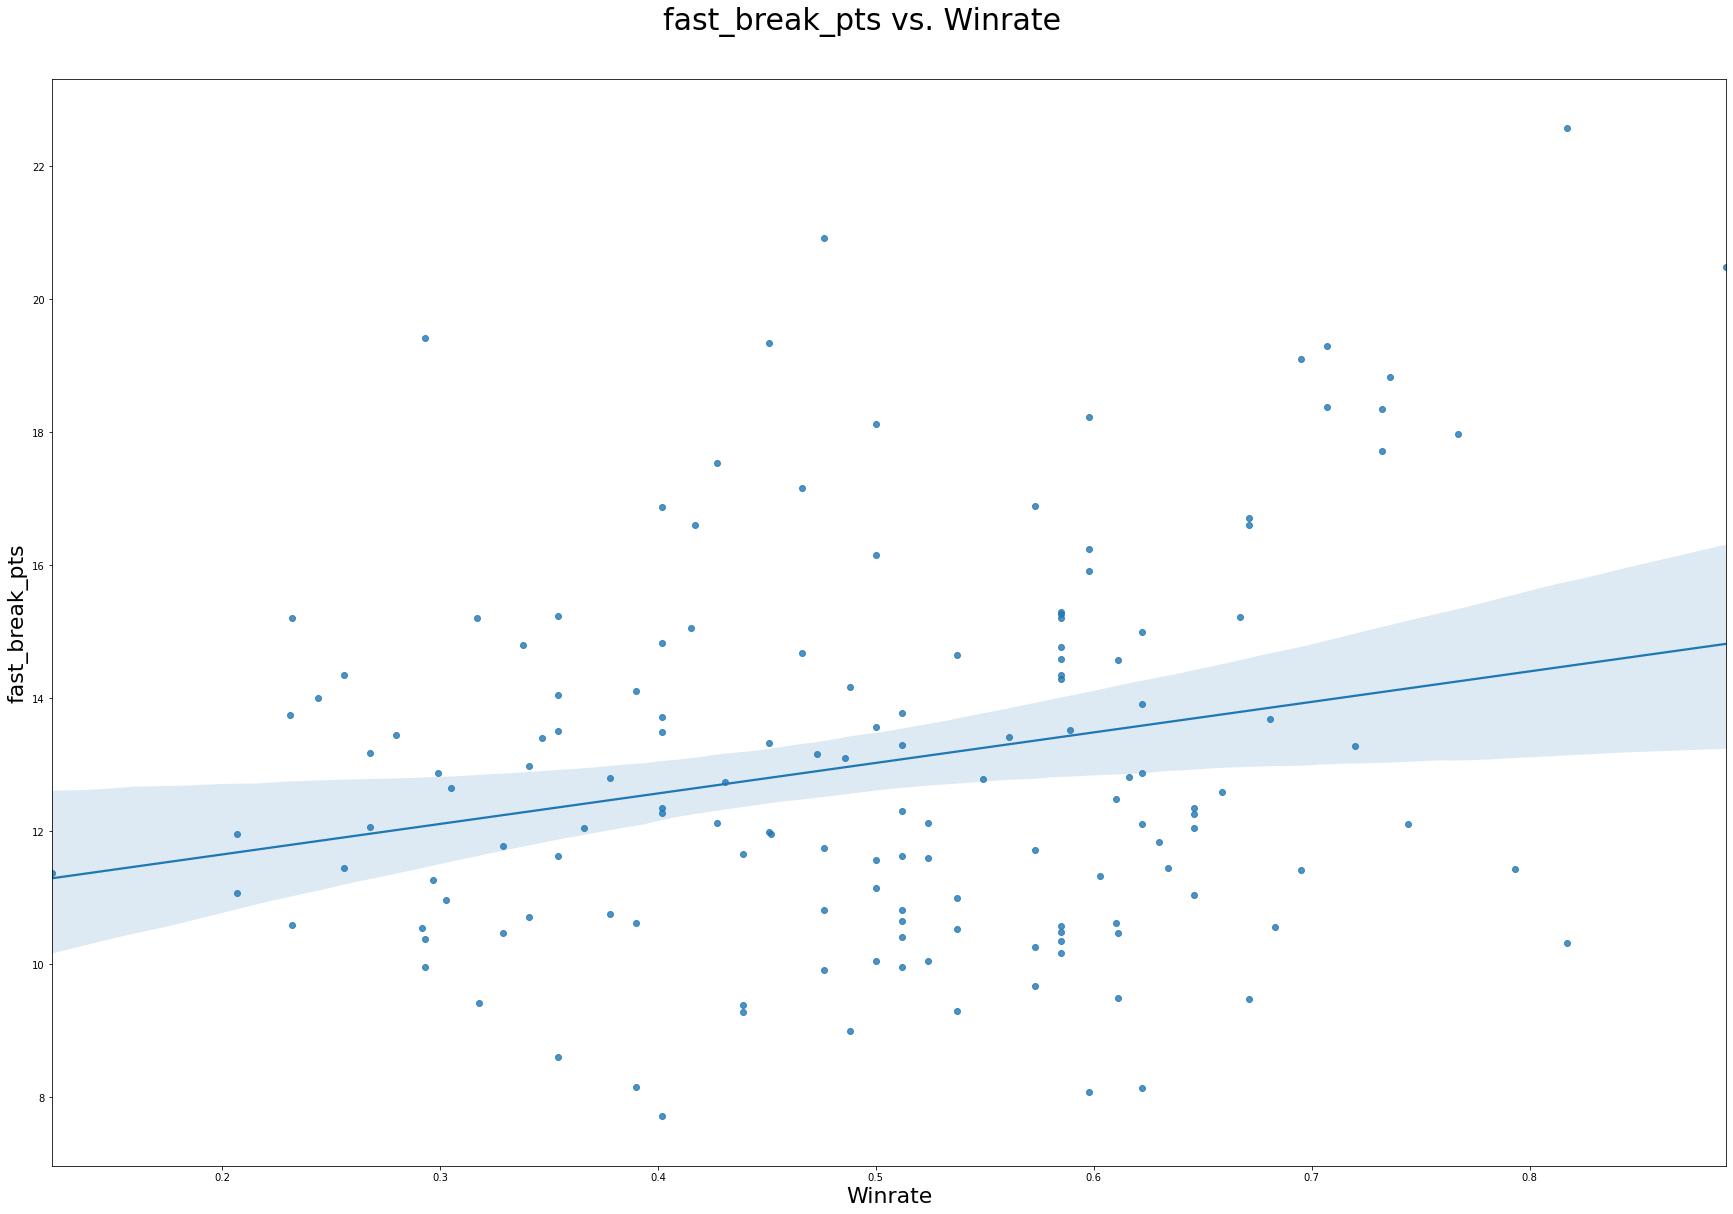

<Figure size 360x360 with 0 Axes>

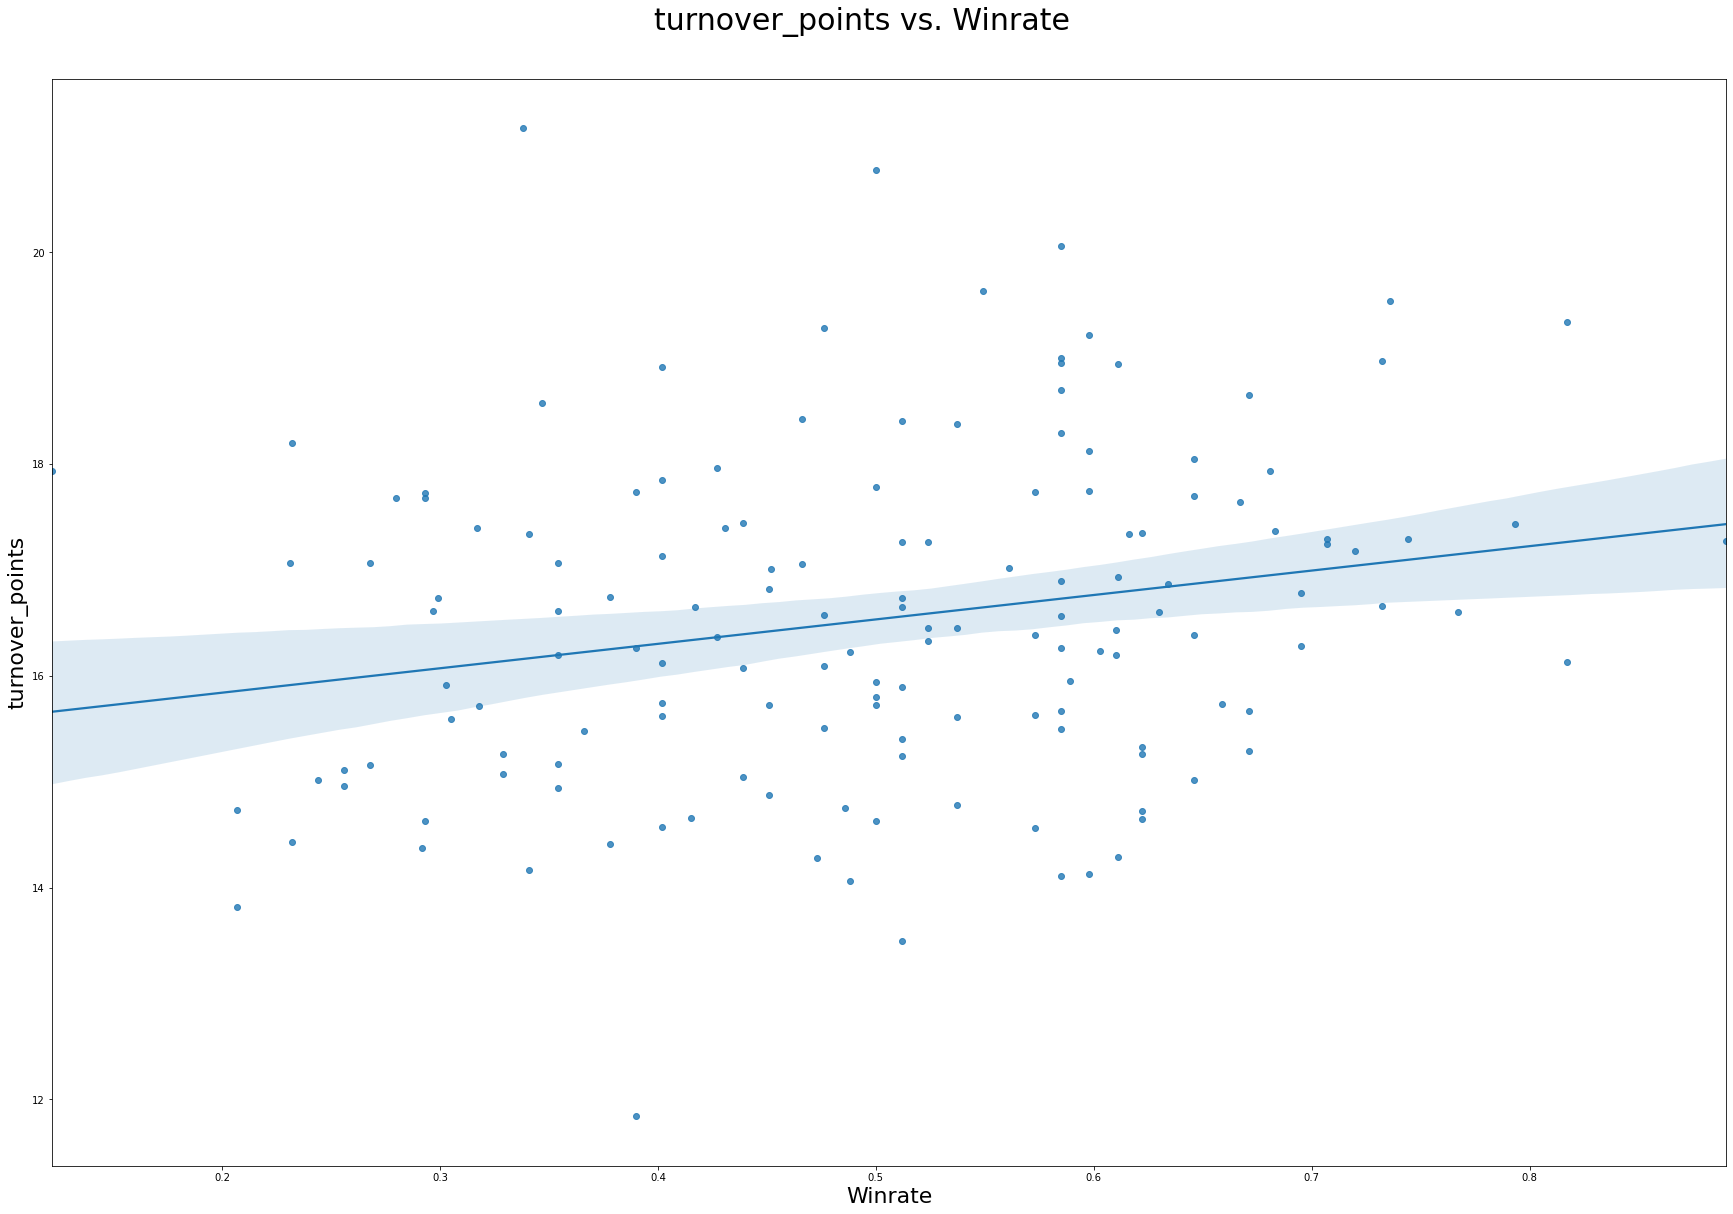

<Figure size 360x360 with 0 Axes>

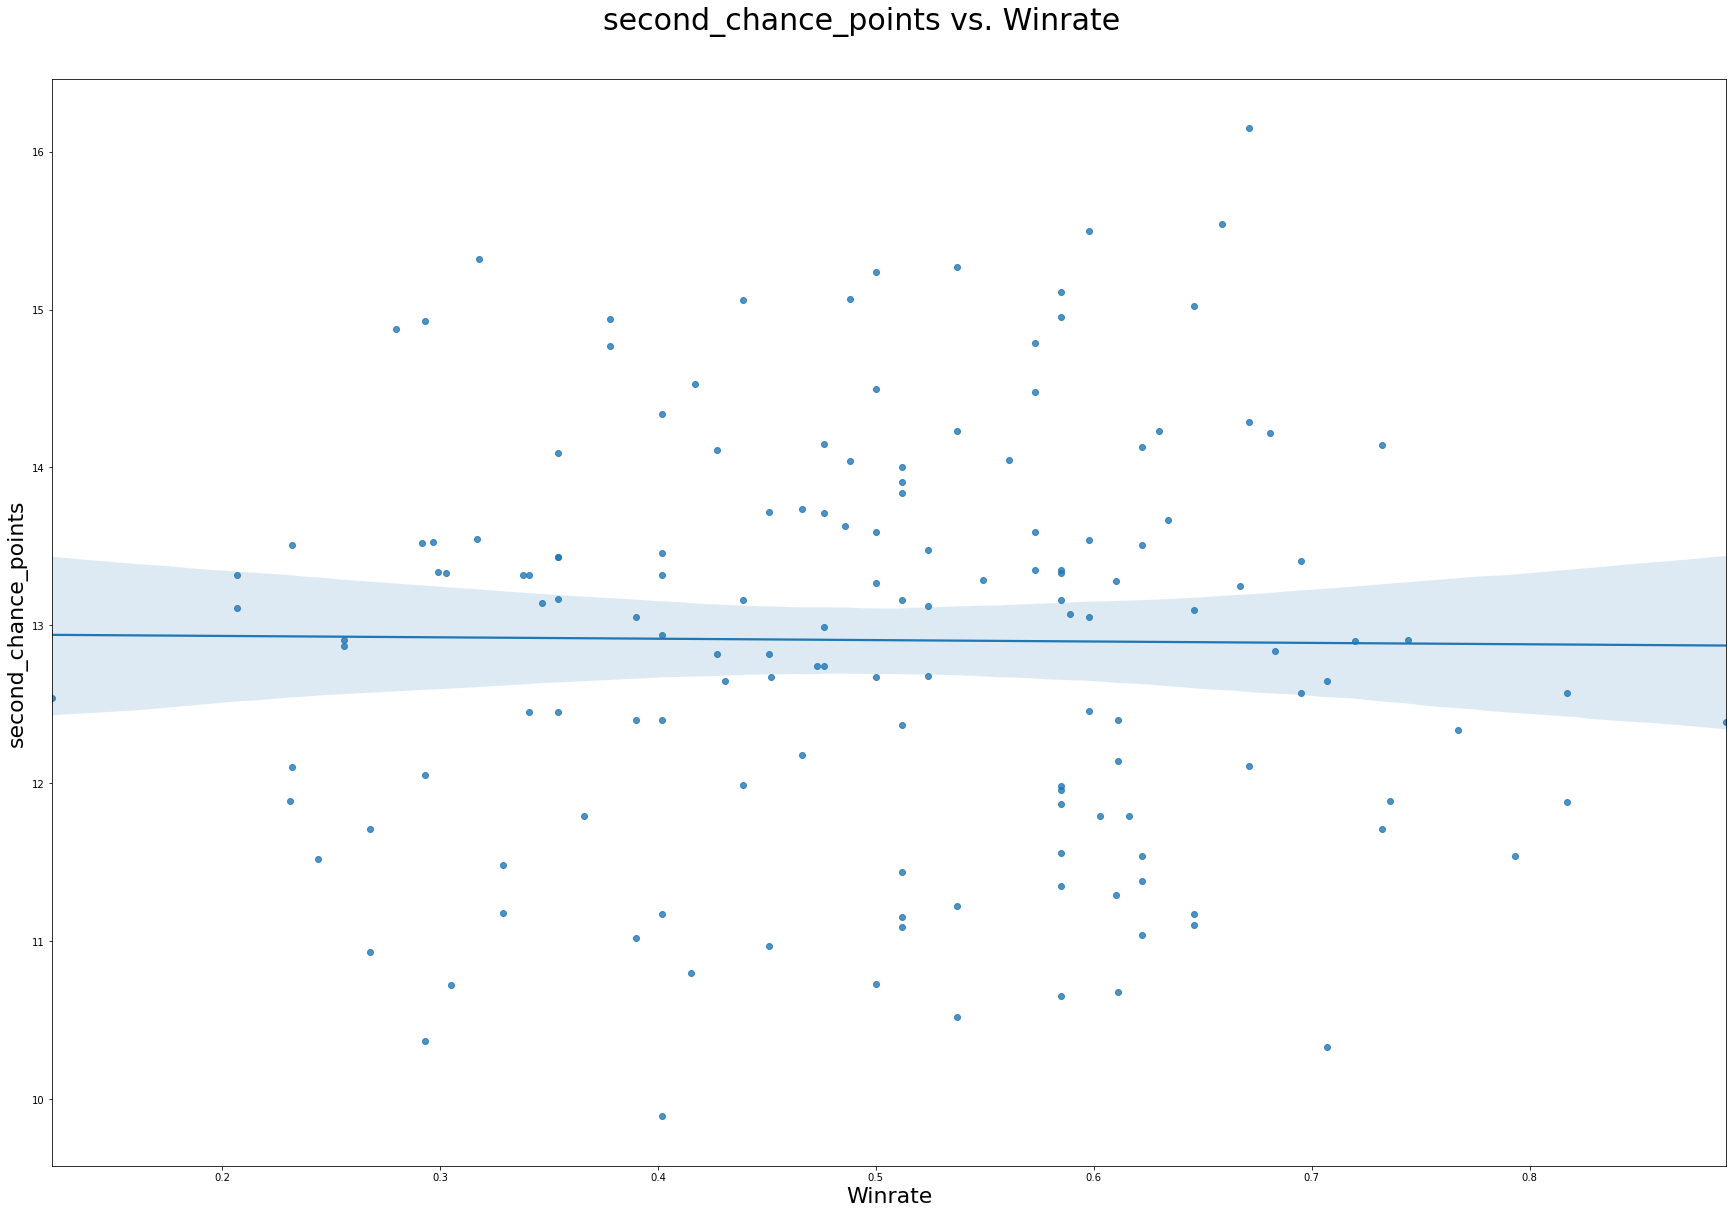

<Figure size 360x360 with 0 Axes>

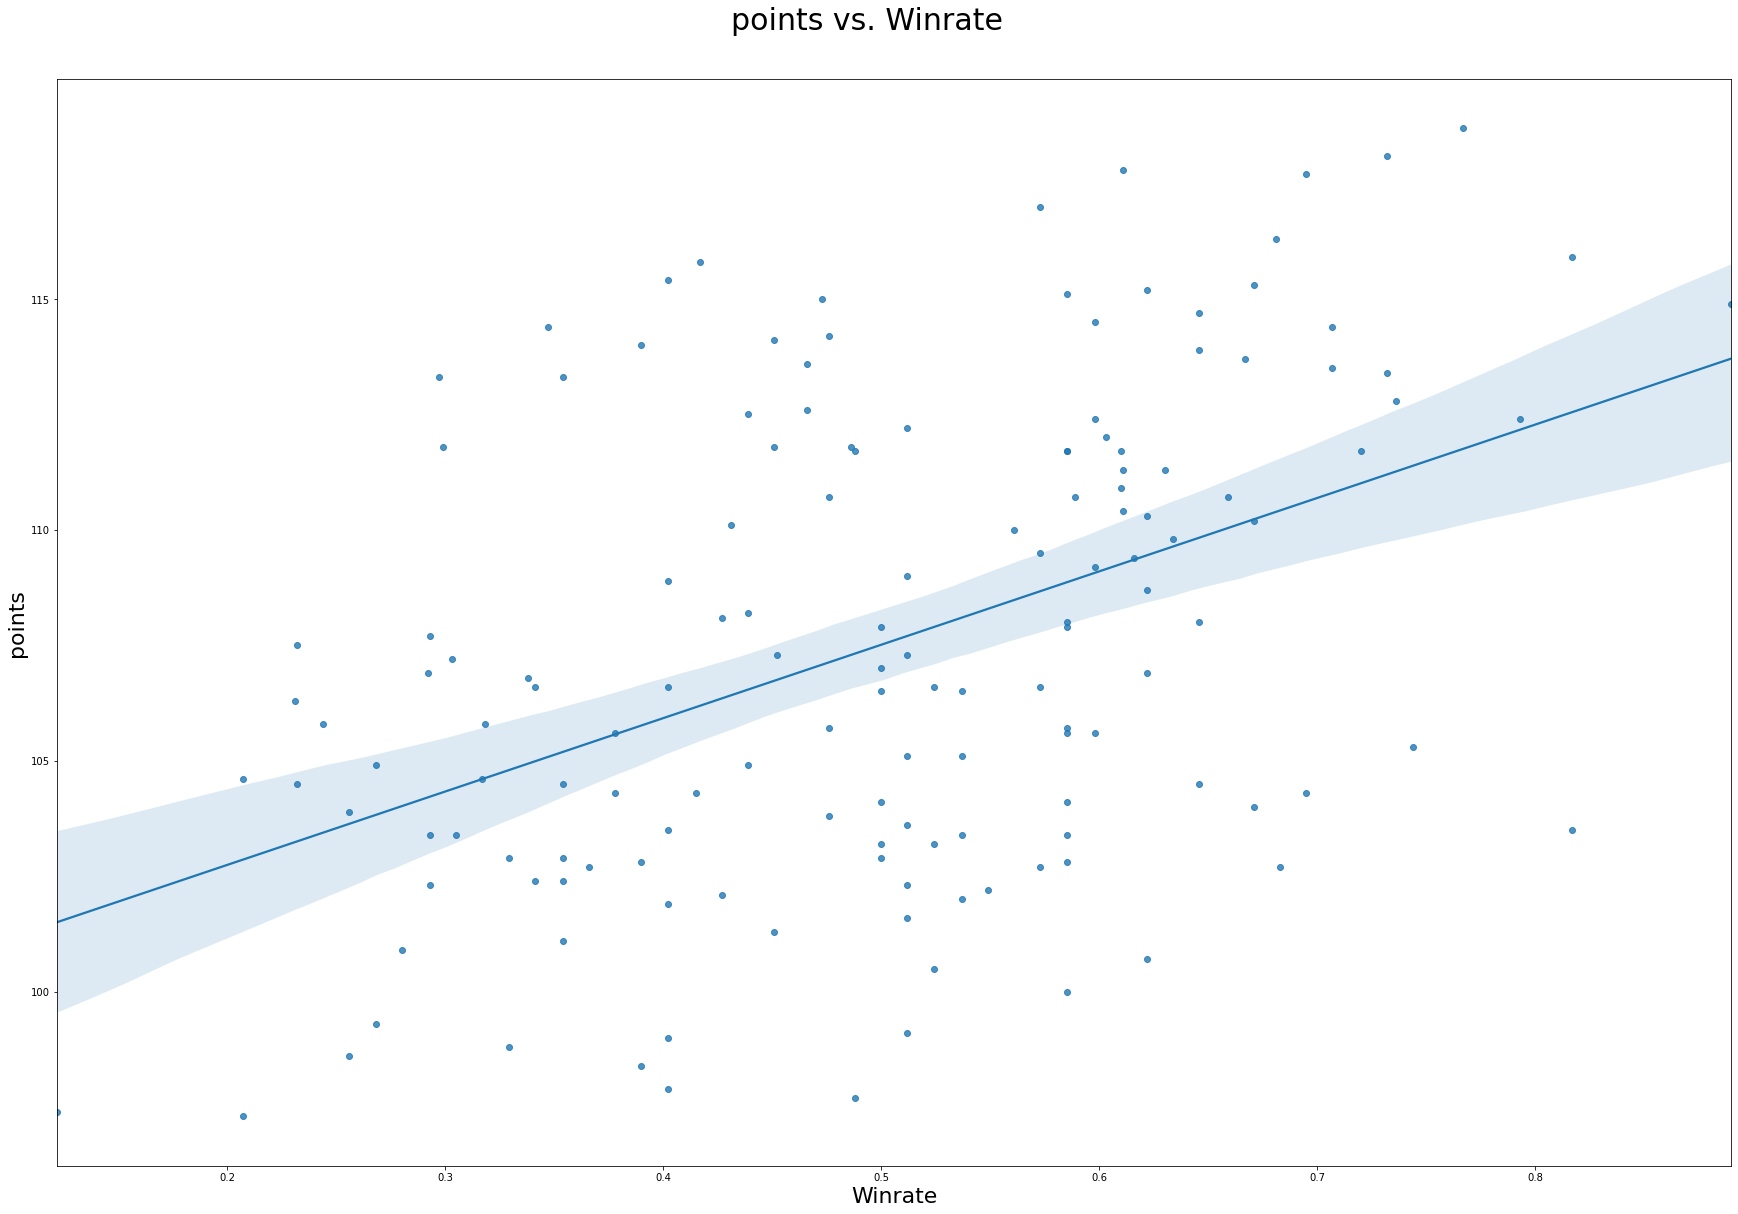

<Figure size 360x360 with 0 Axes>

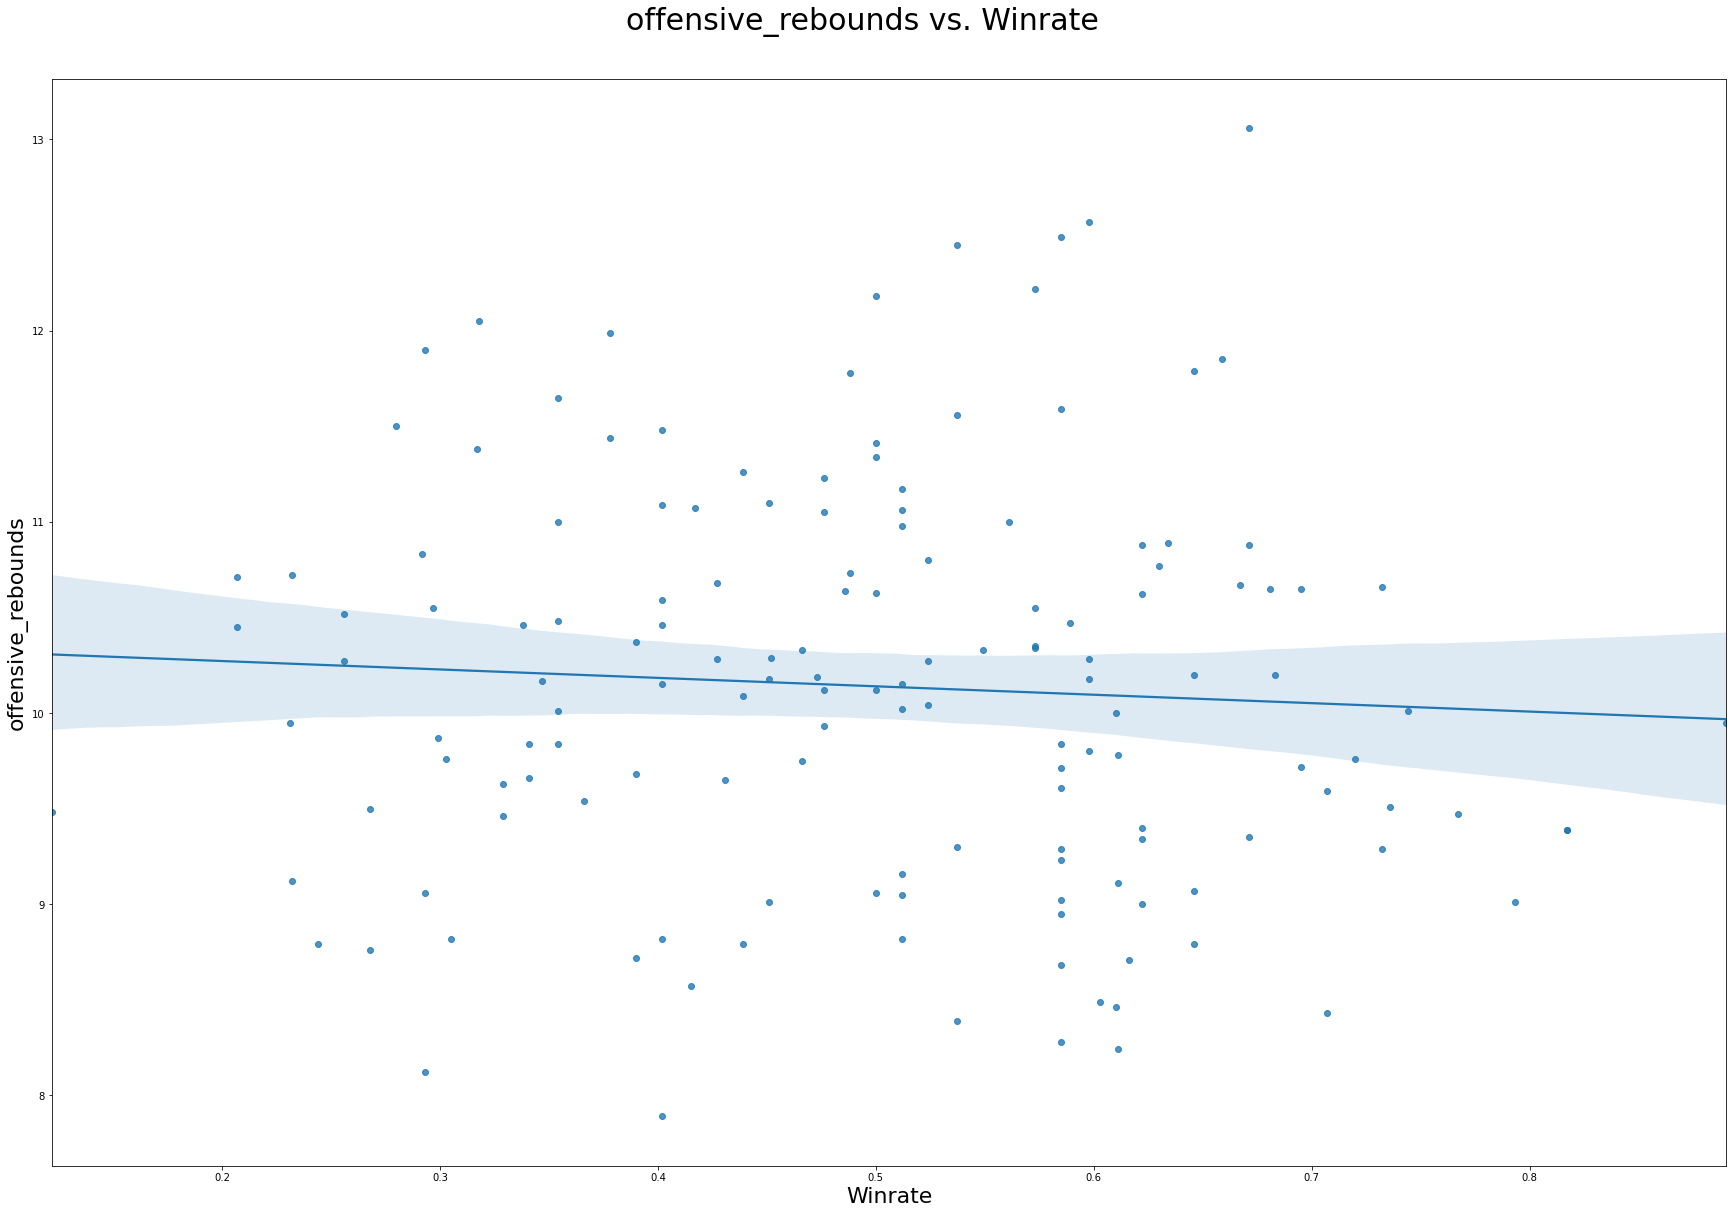

<Figure size 360x360 with 0 Axes>

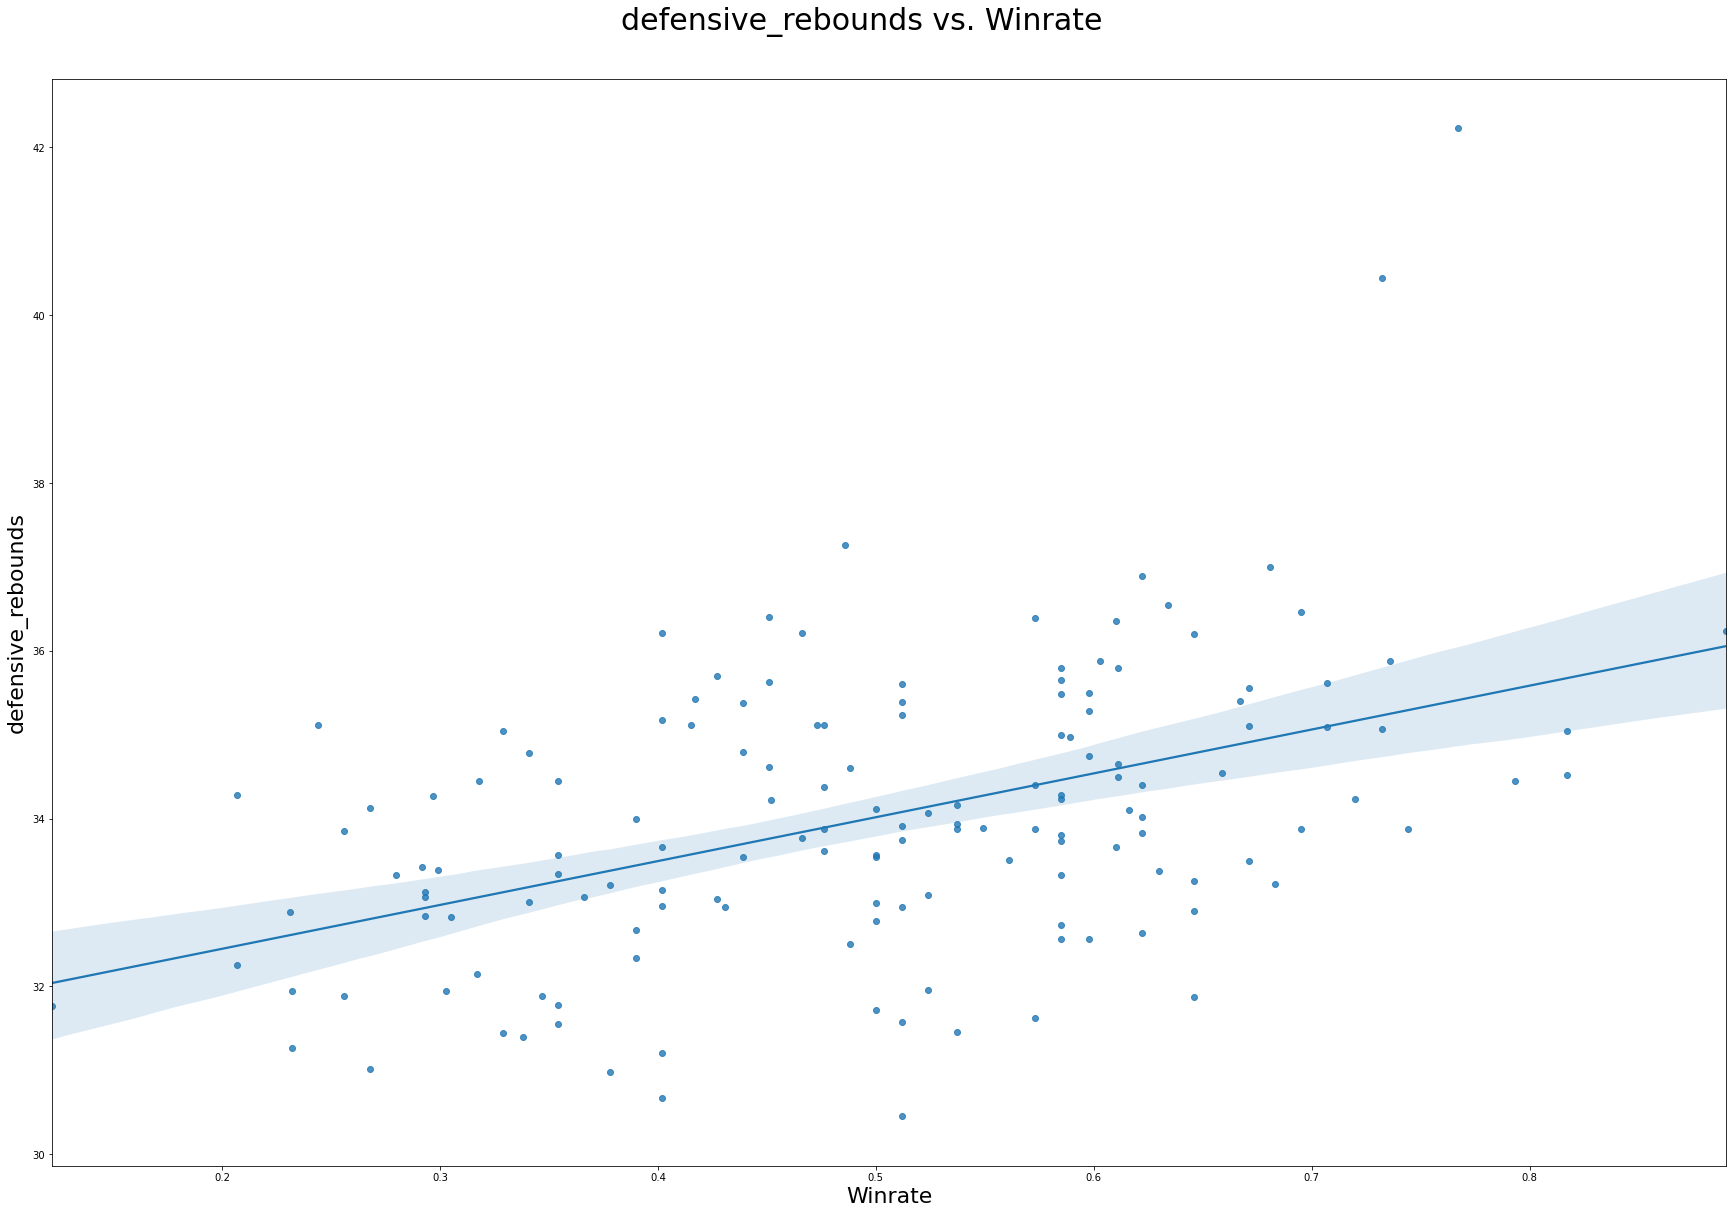

<Figure size 360x360 with 0 Axes>

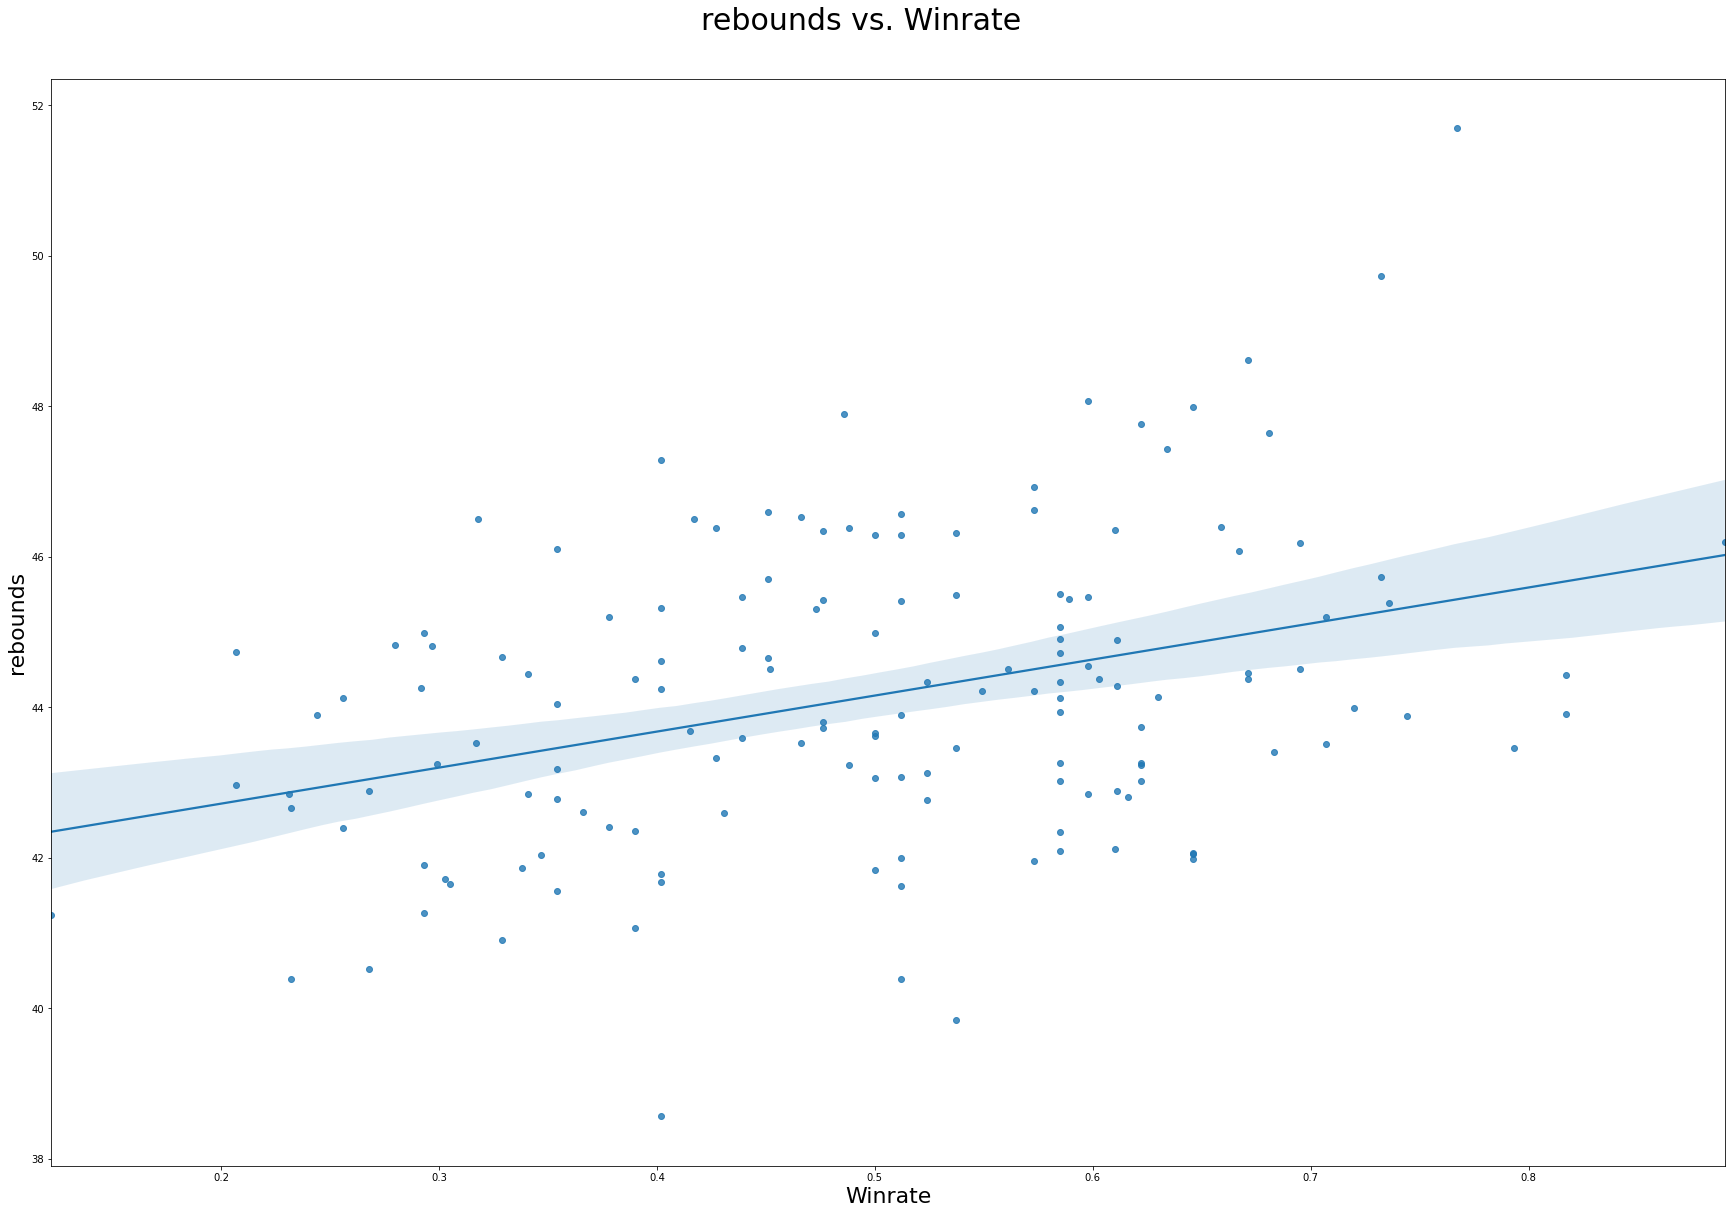

<Figure size 360x360 with 0 Axes>

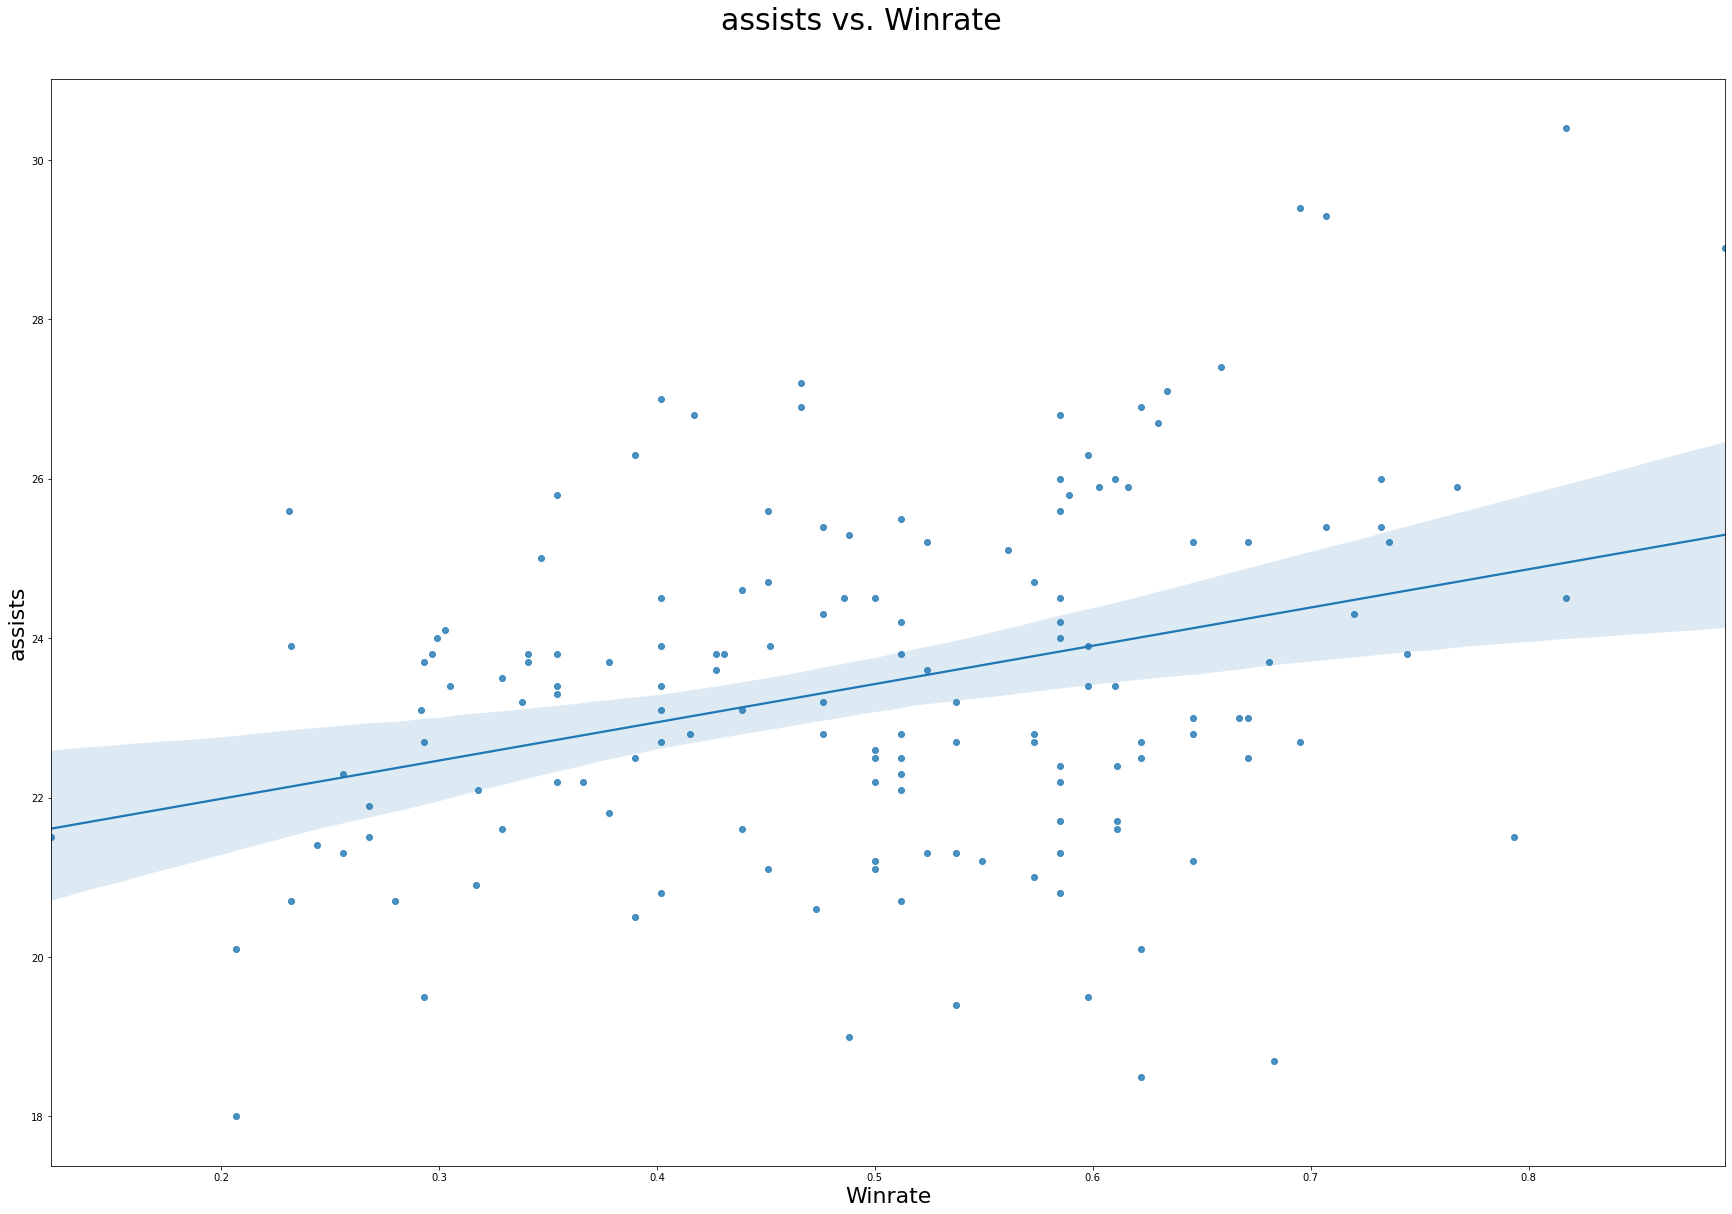

<Figure size 360x360 with 0 Axes>

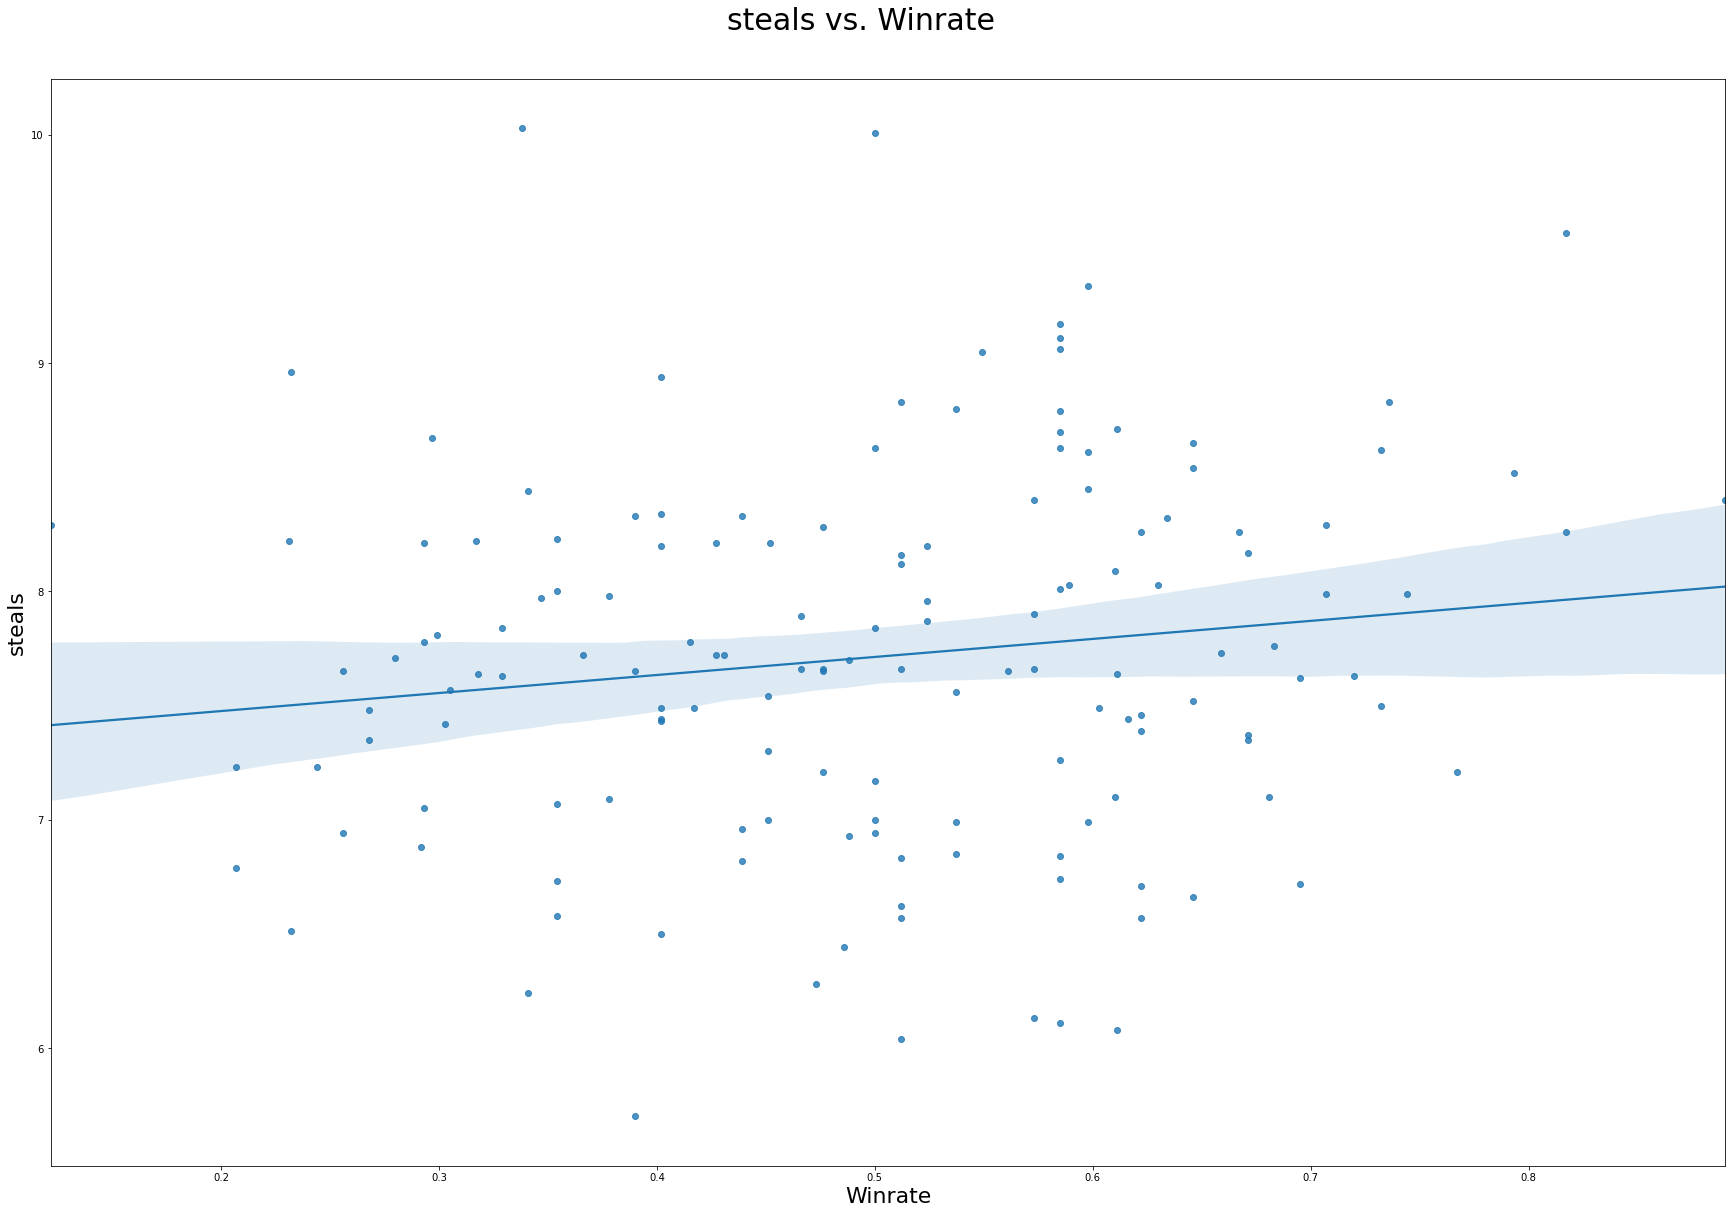

<Figure size 360x360 with 0 Axes>

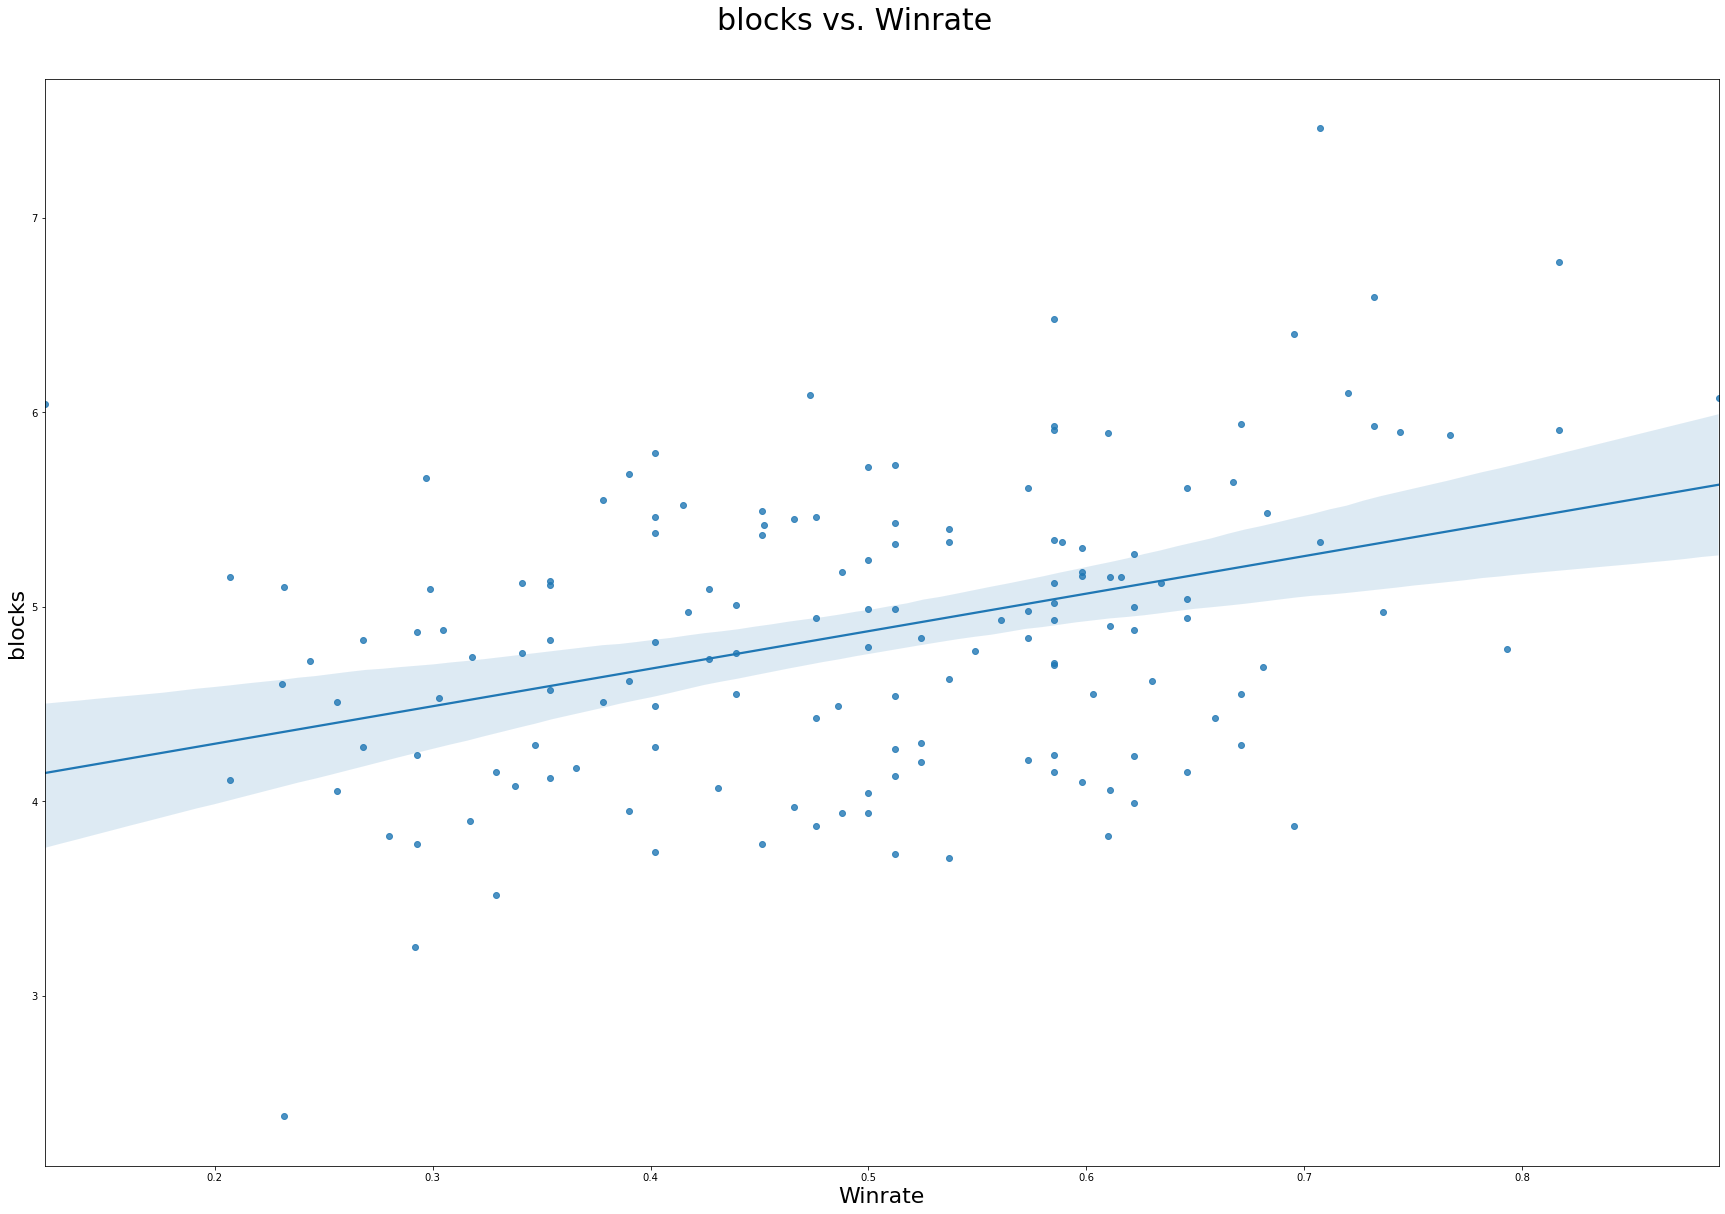

<Figure size 360x360 with 0 Axes>

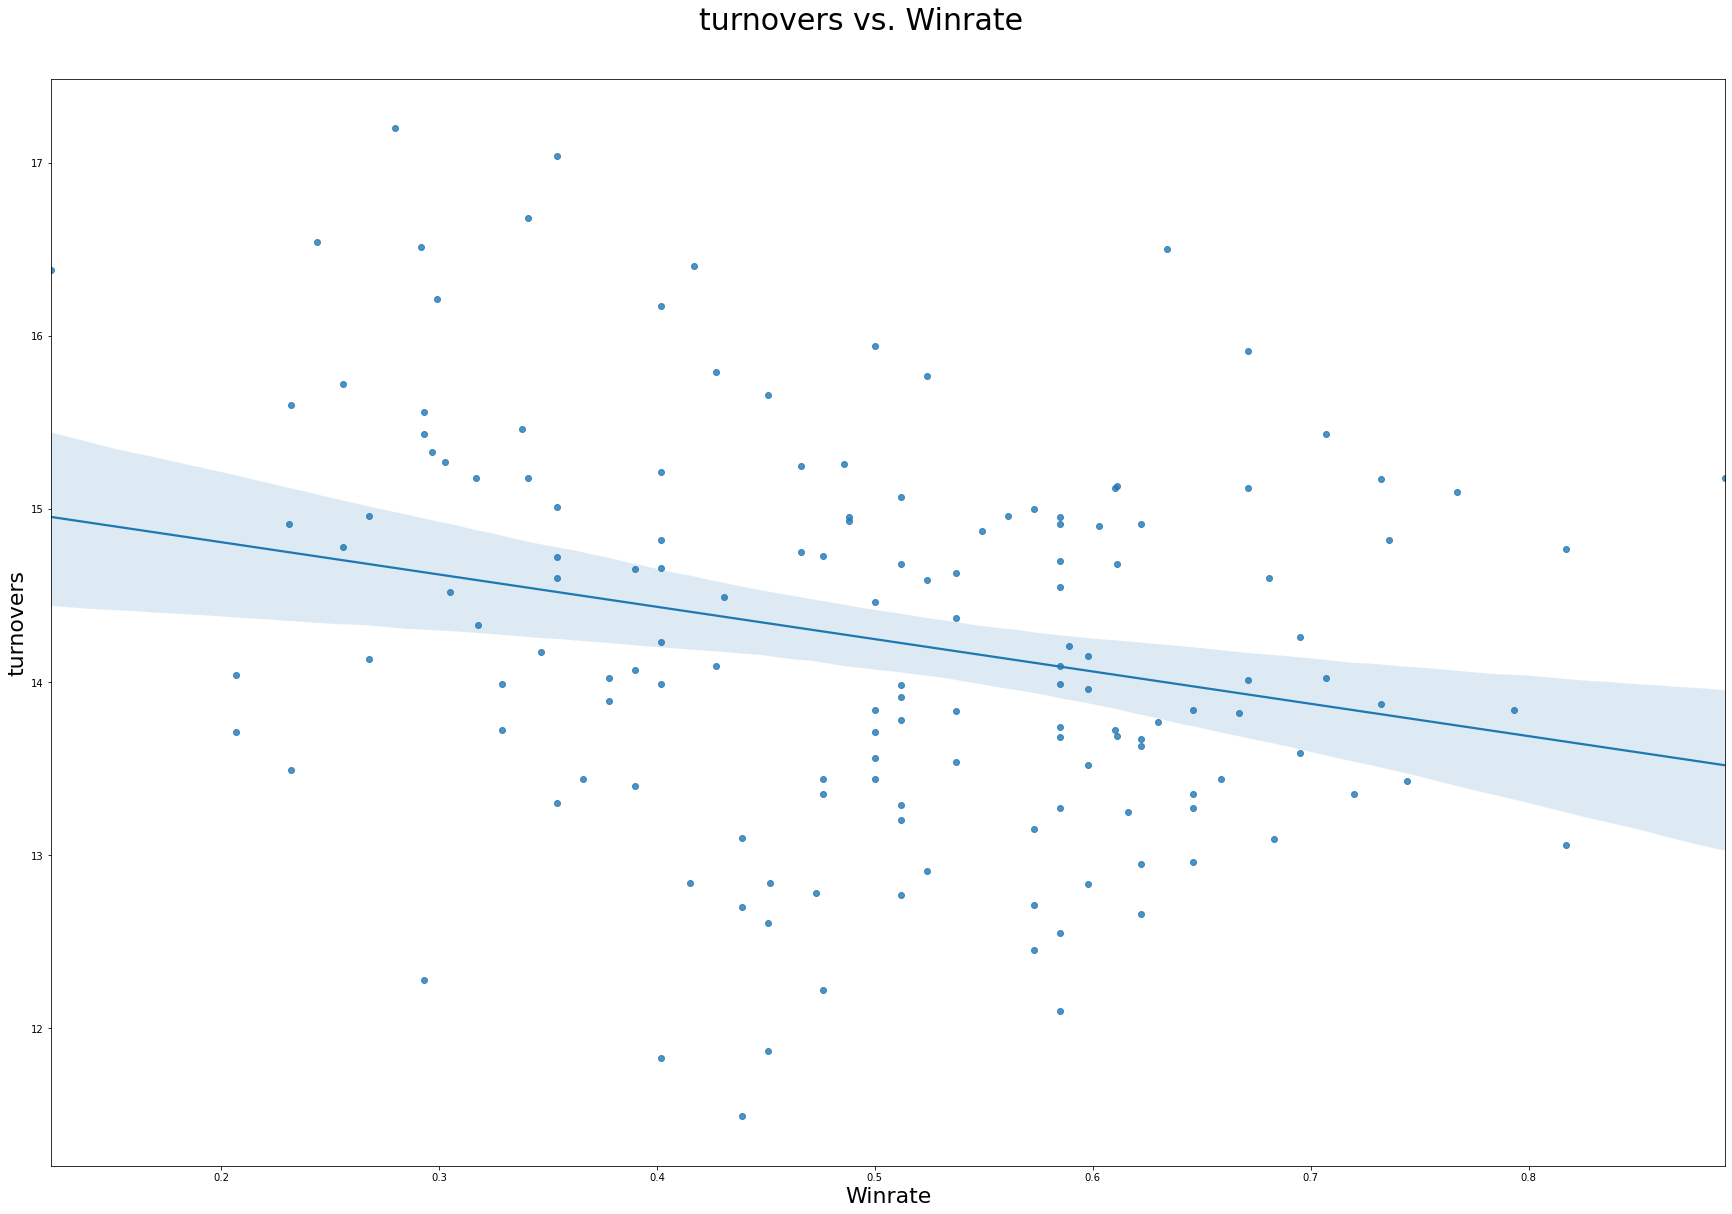

<Figure size 360x360 with 0 Axes>

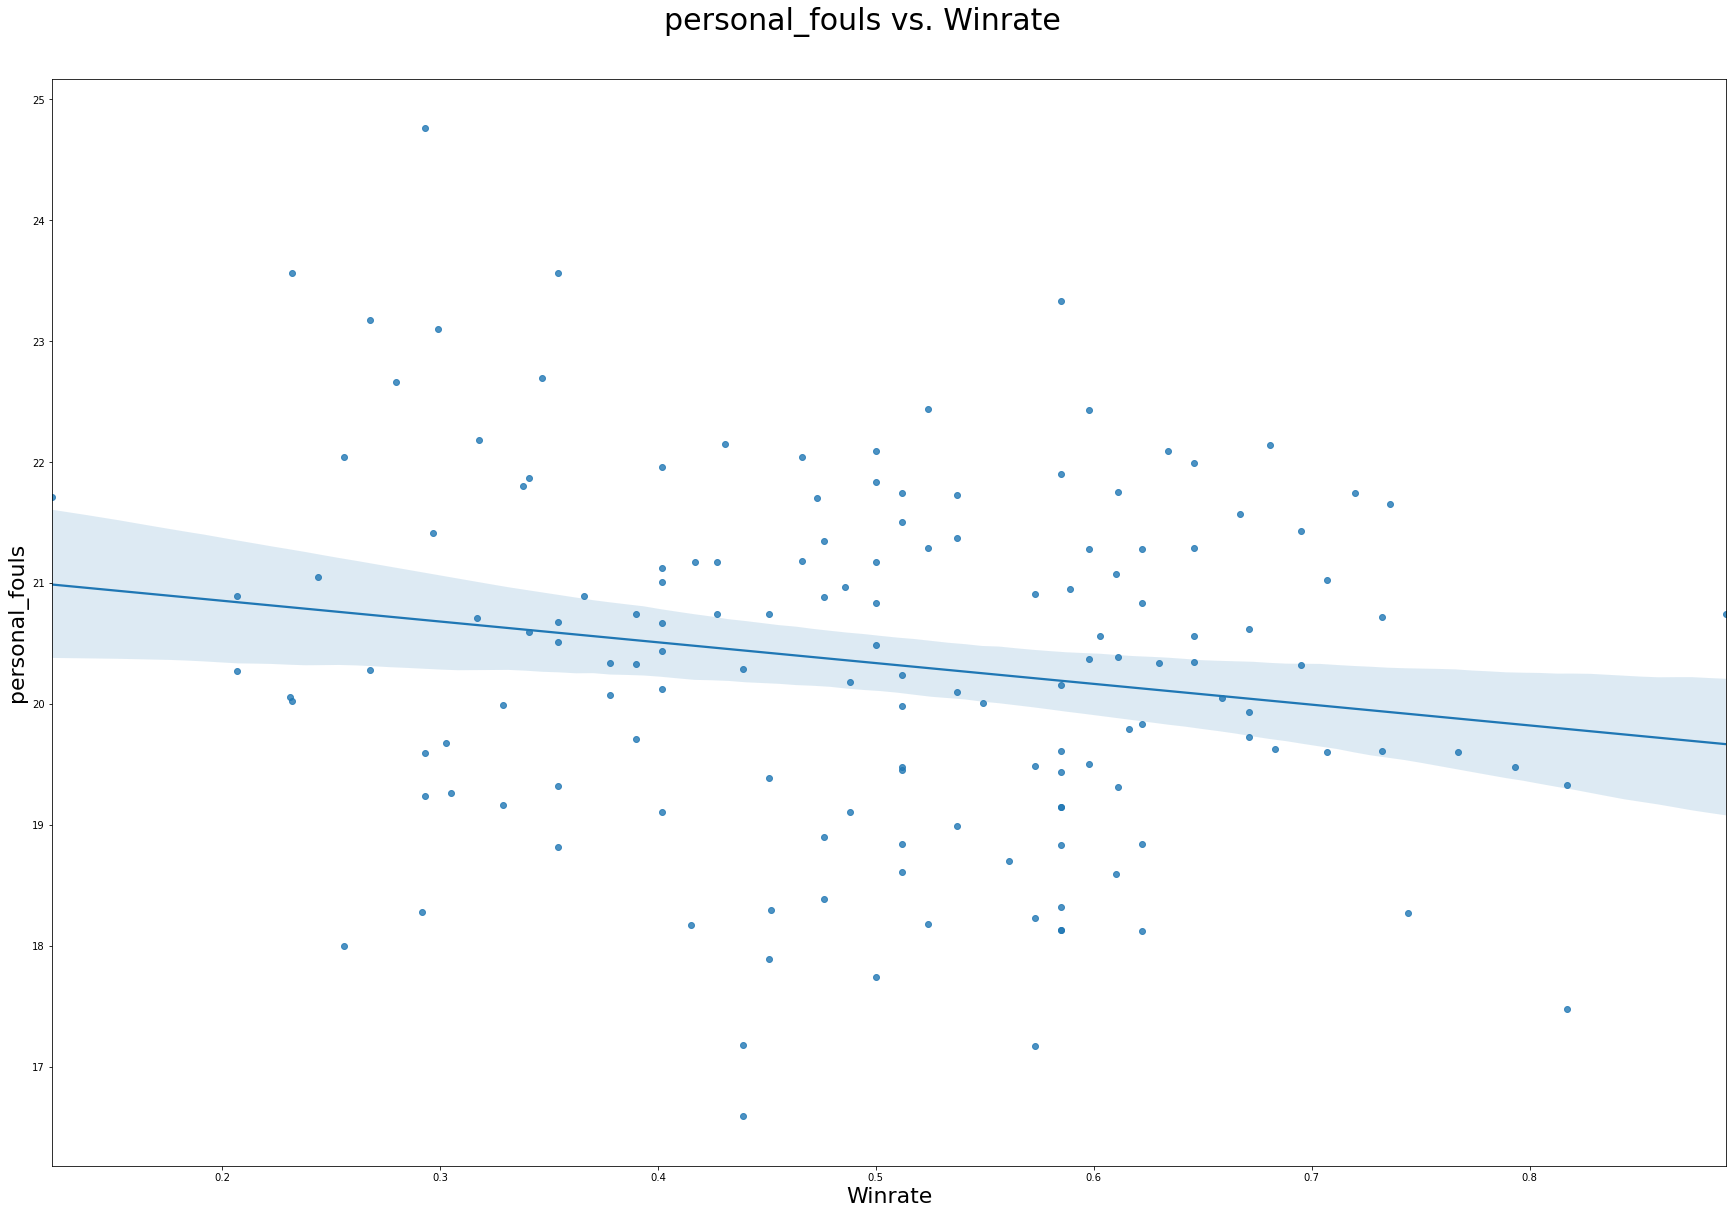

<Figure size 360x360 with 0 Axes>

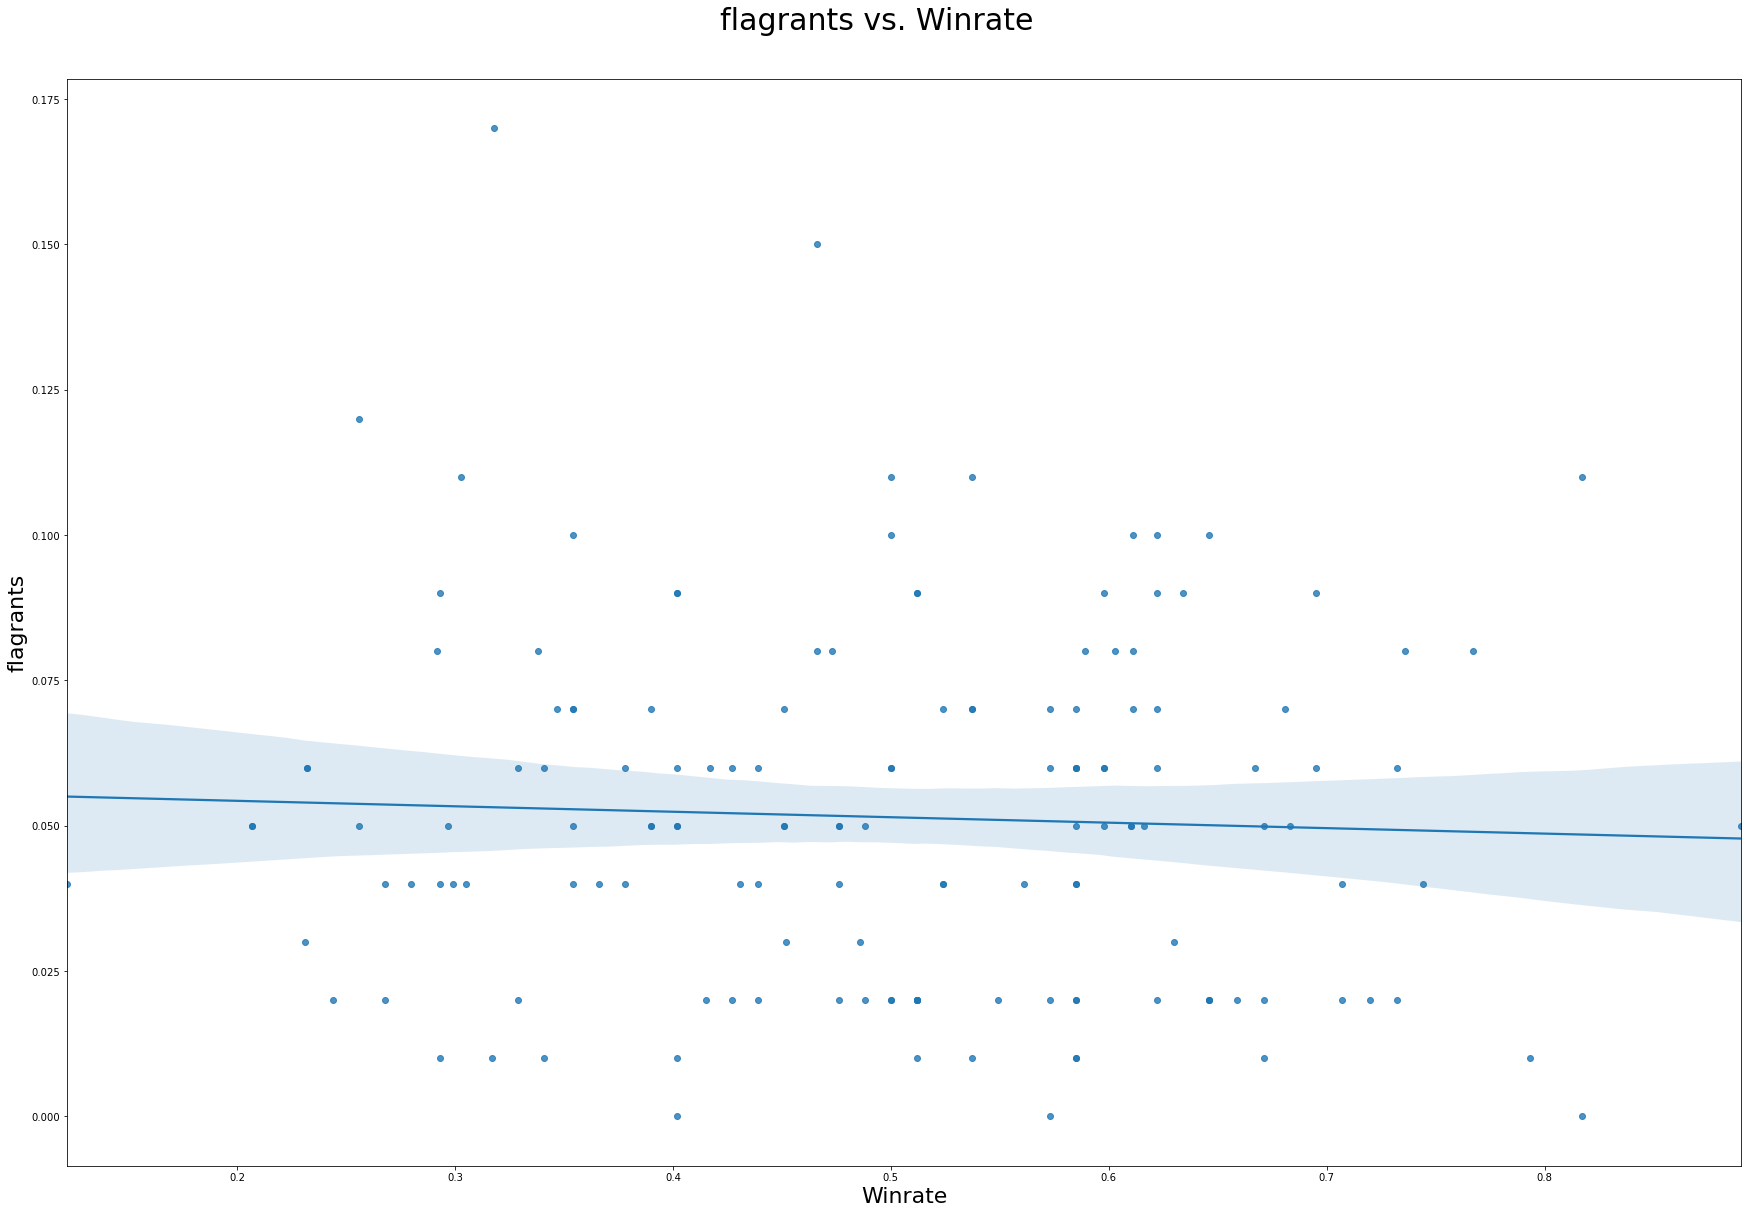

<Figure size 360x360 with 0 Axes>

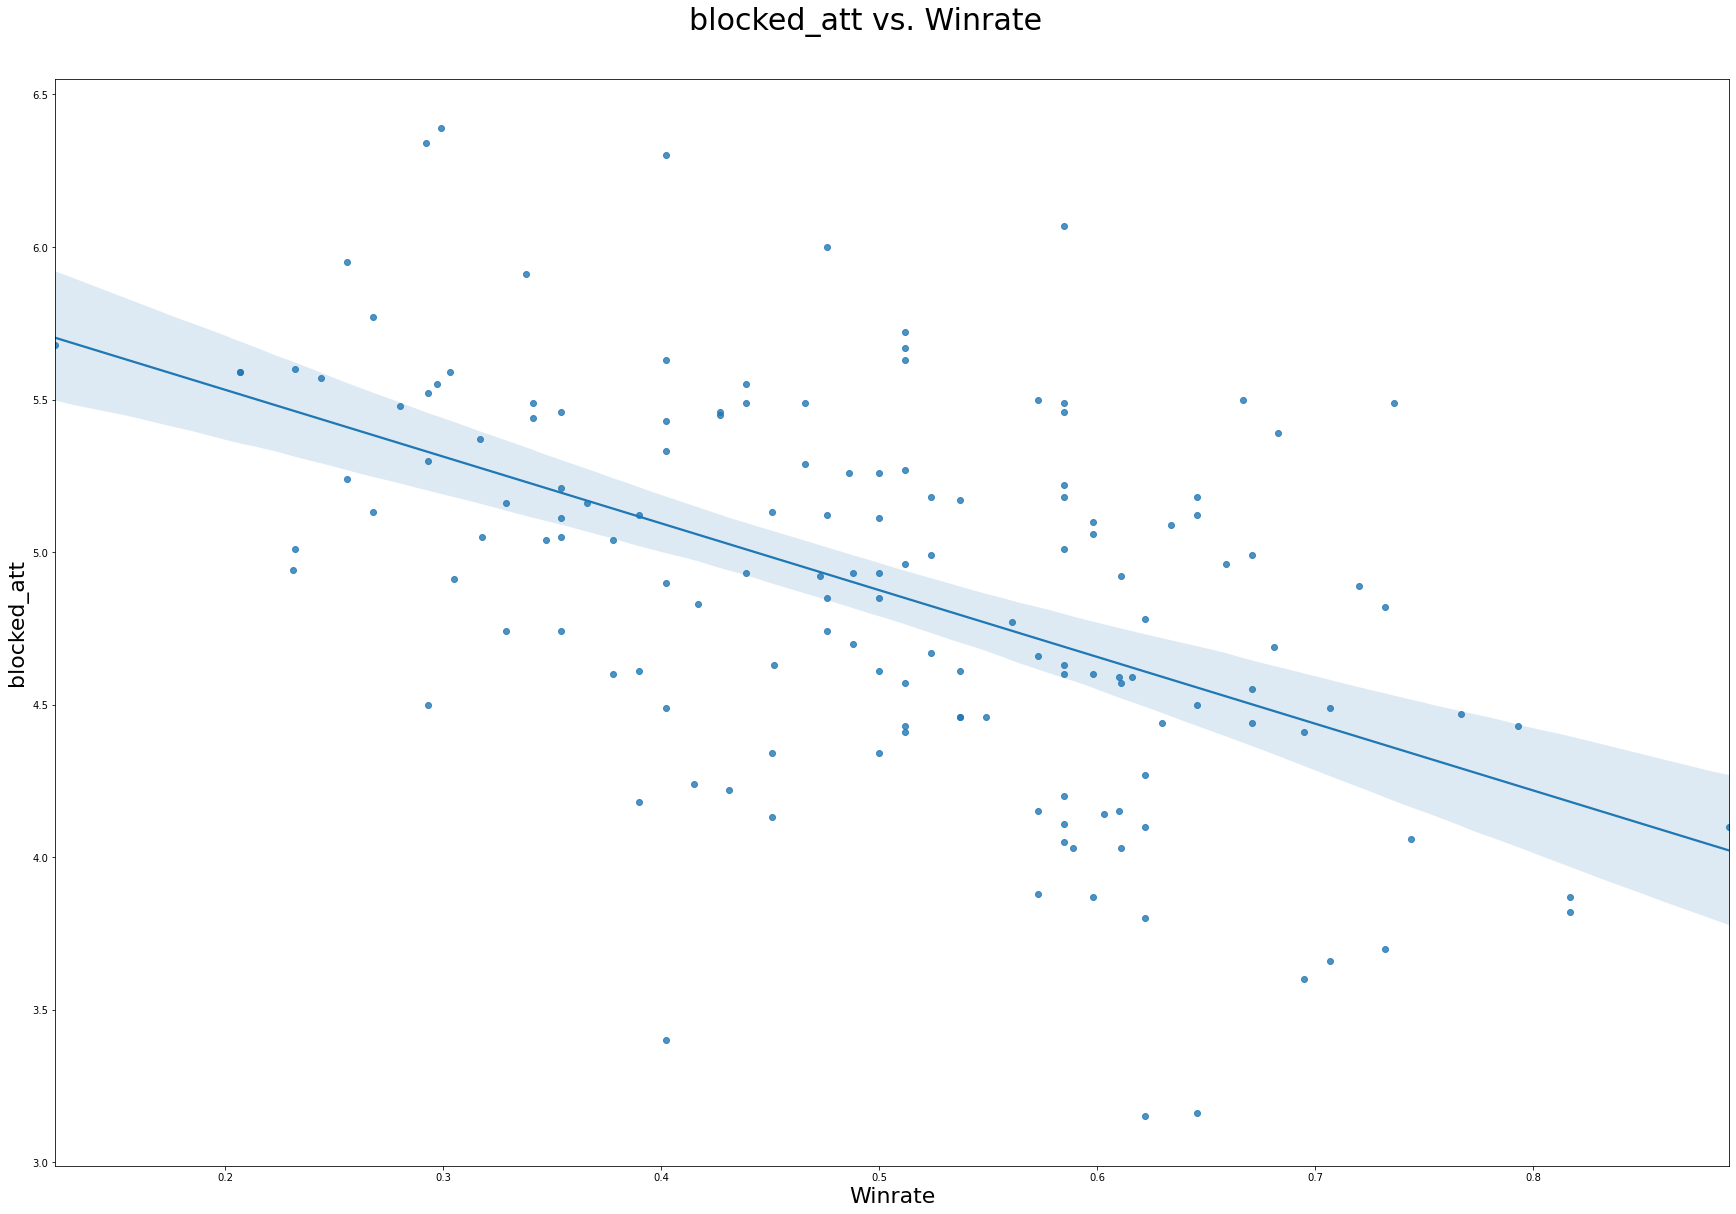

<Figure size 360x360 with 0 Axes>

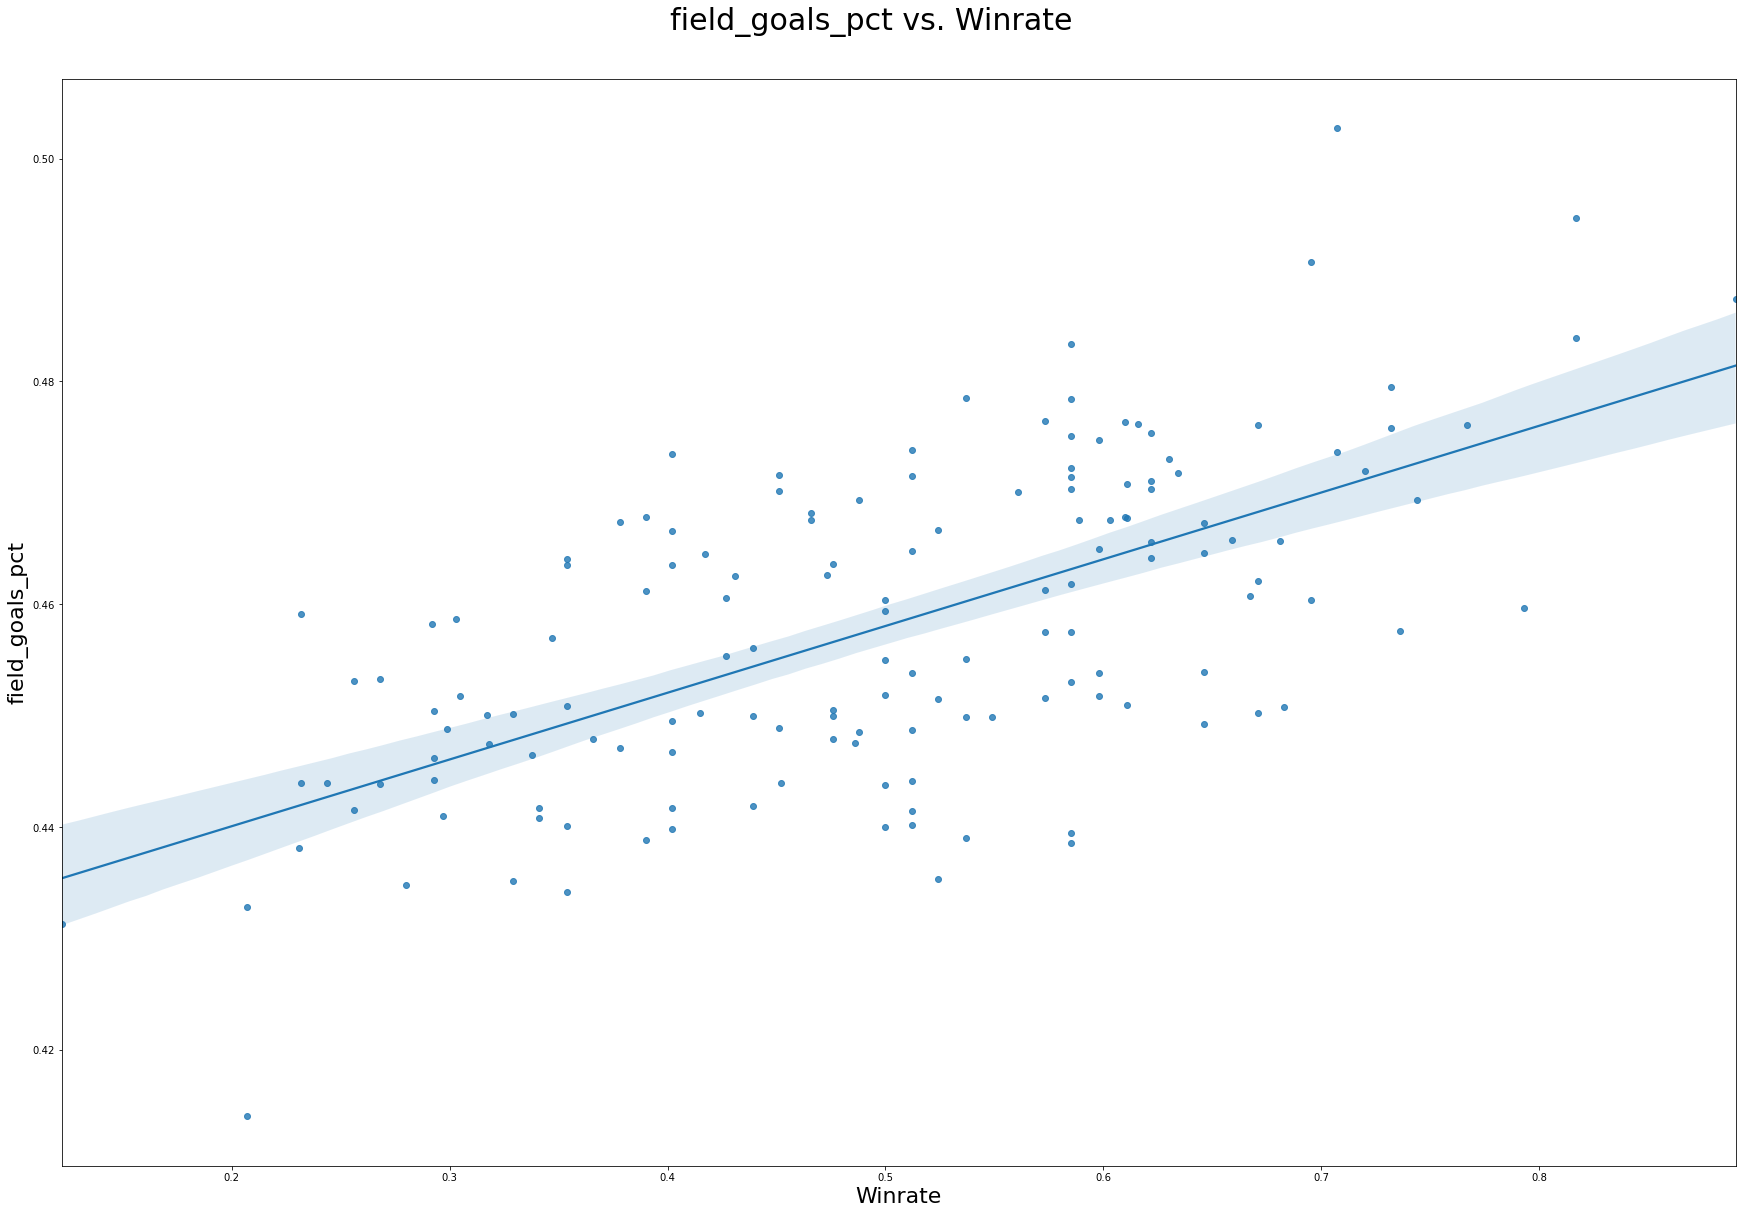

<Figure size 360x360 with 0 Axes>

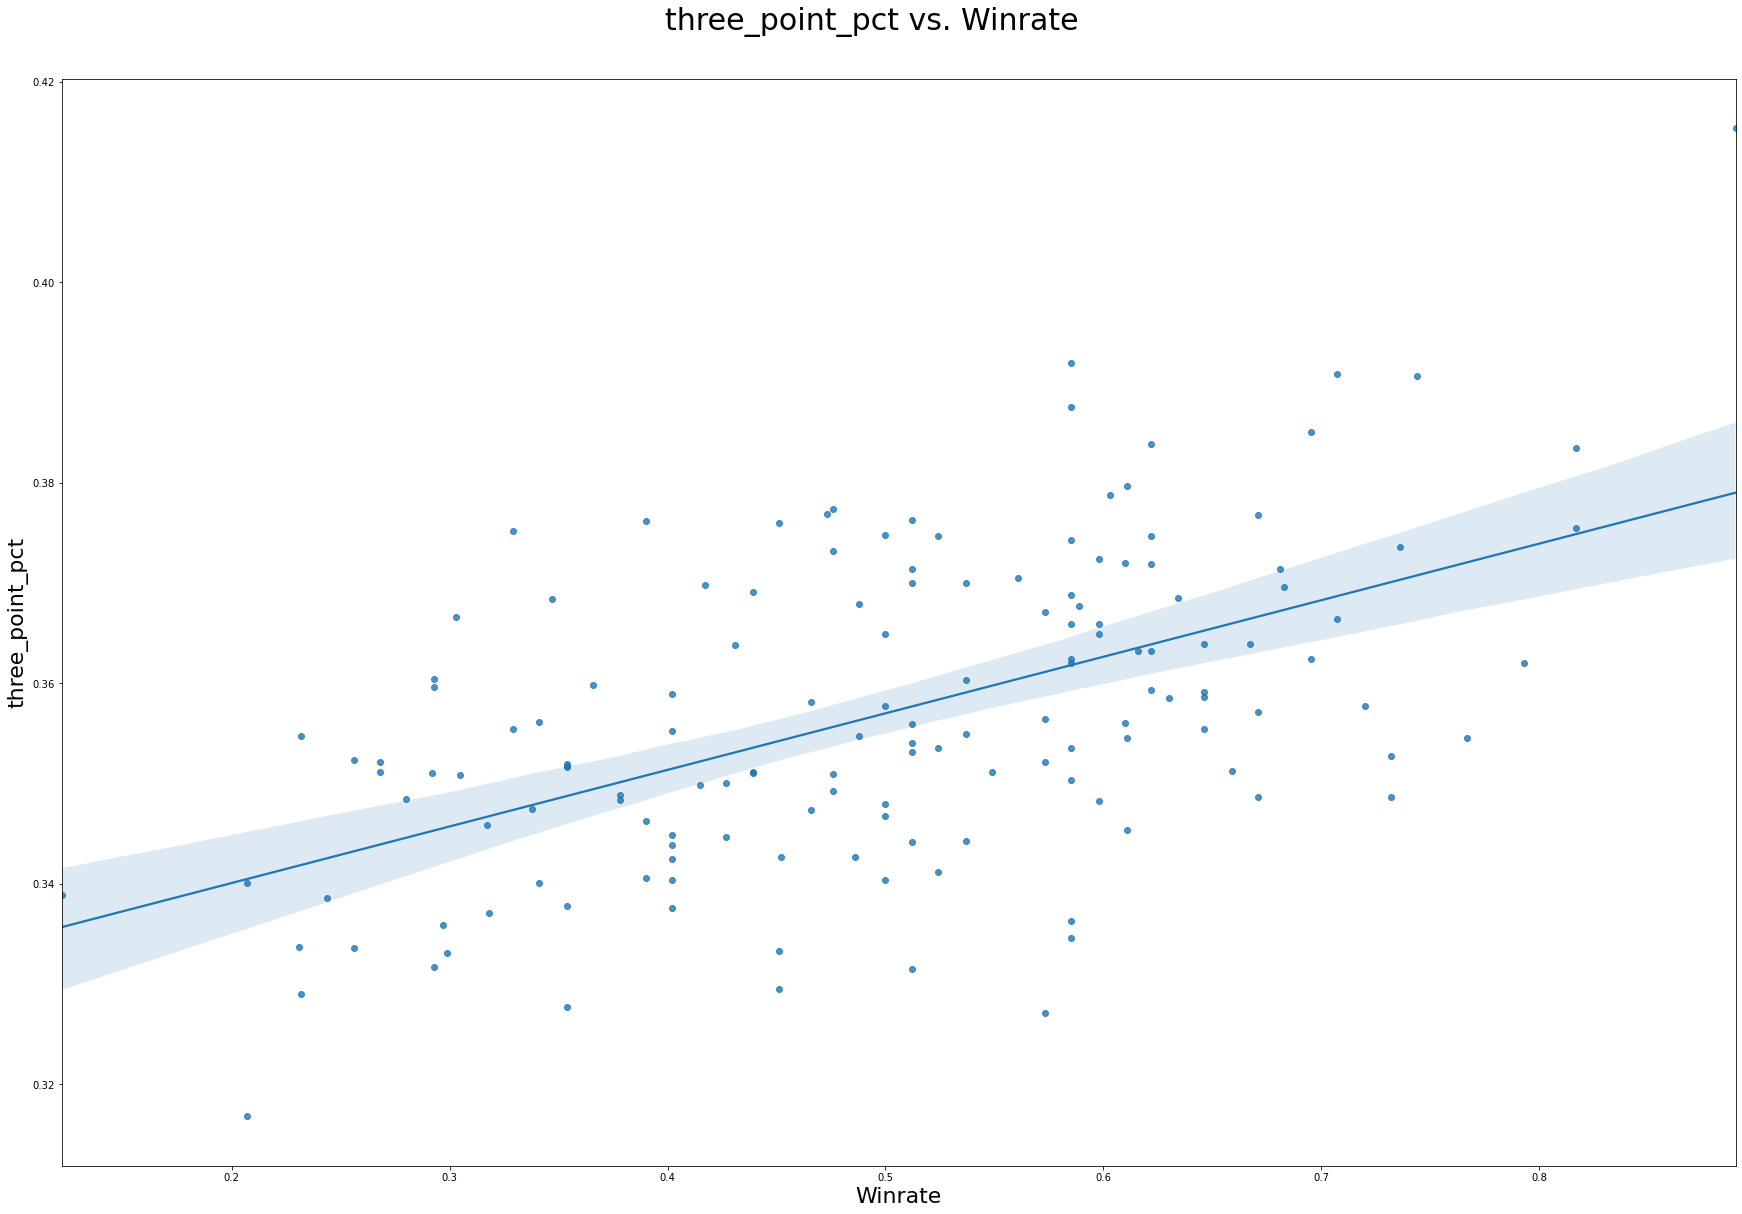

<Figure size 360x360 with 0 Axes>

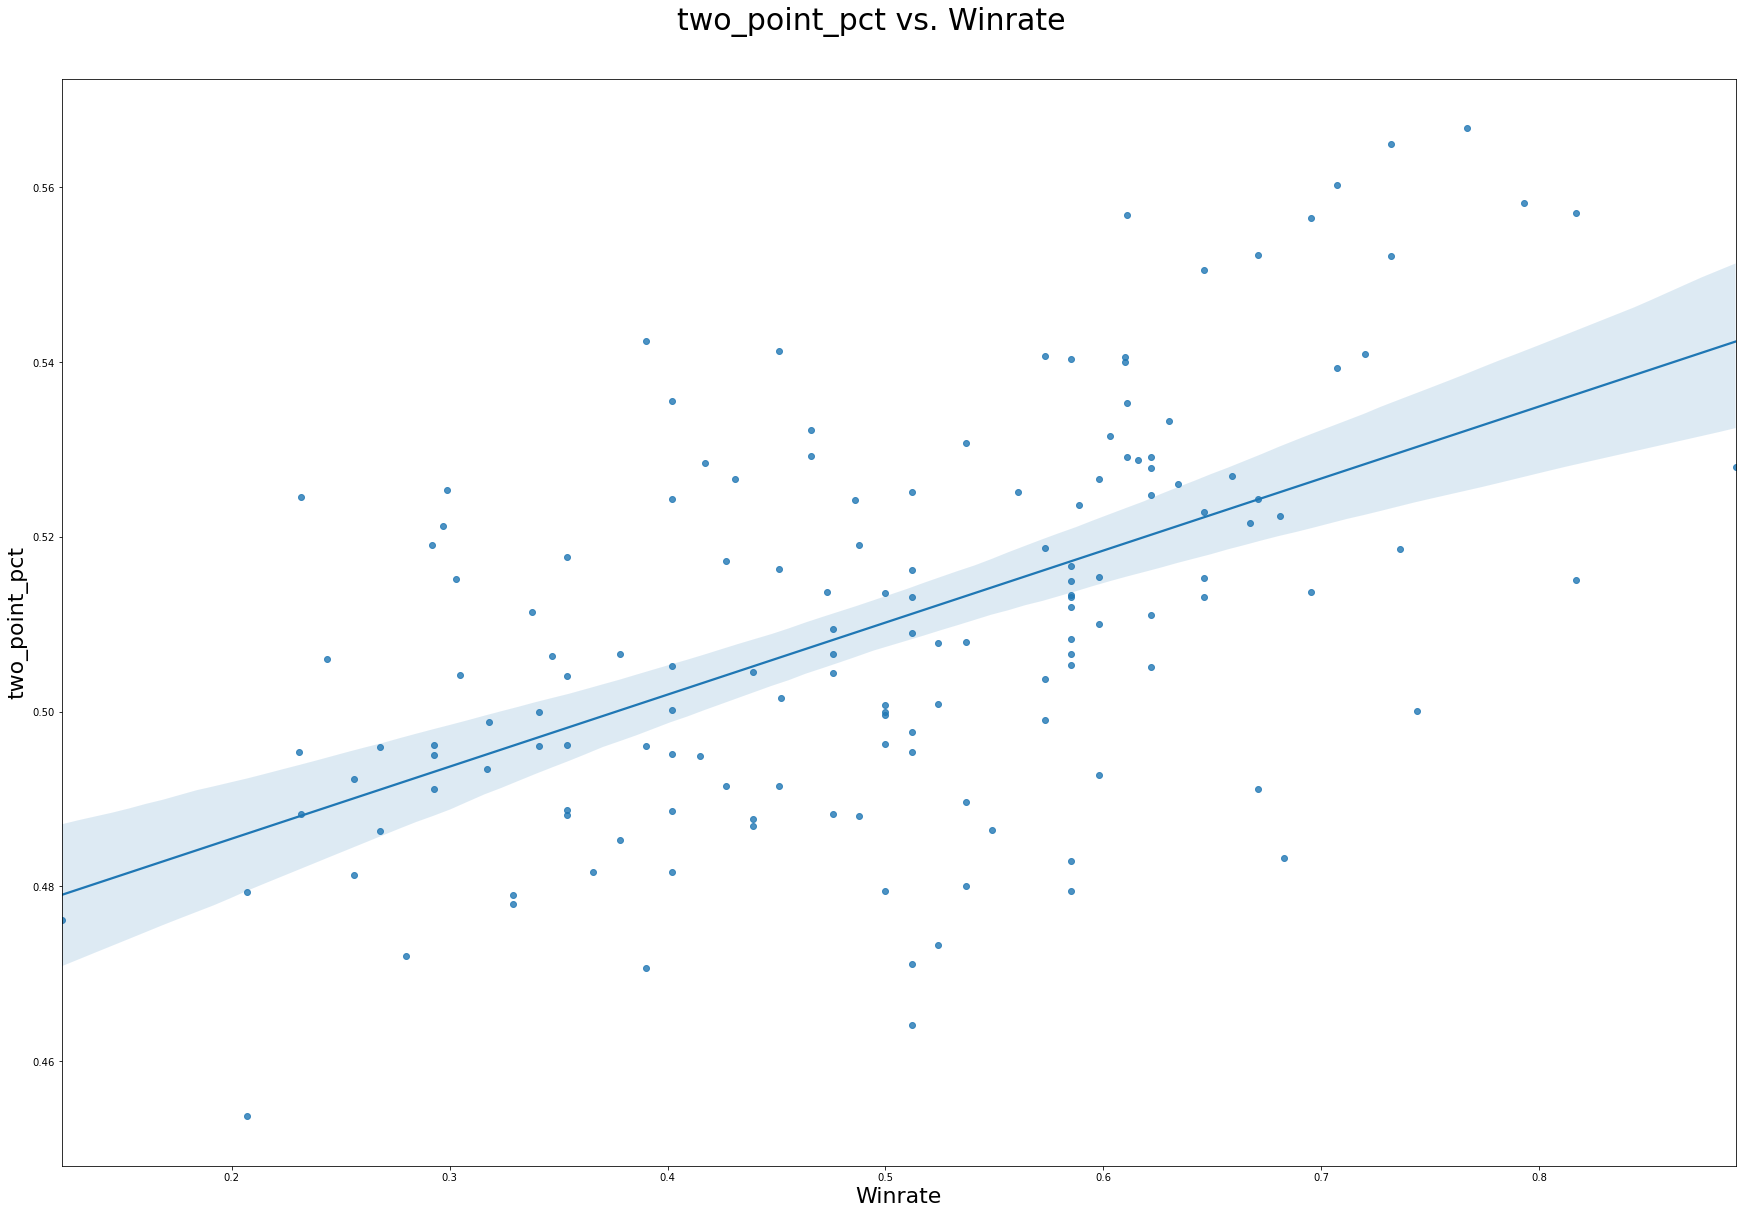

<Figure size 360x360 with 0 Axes>

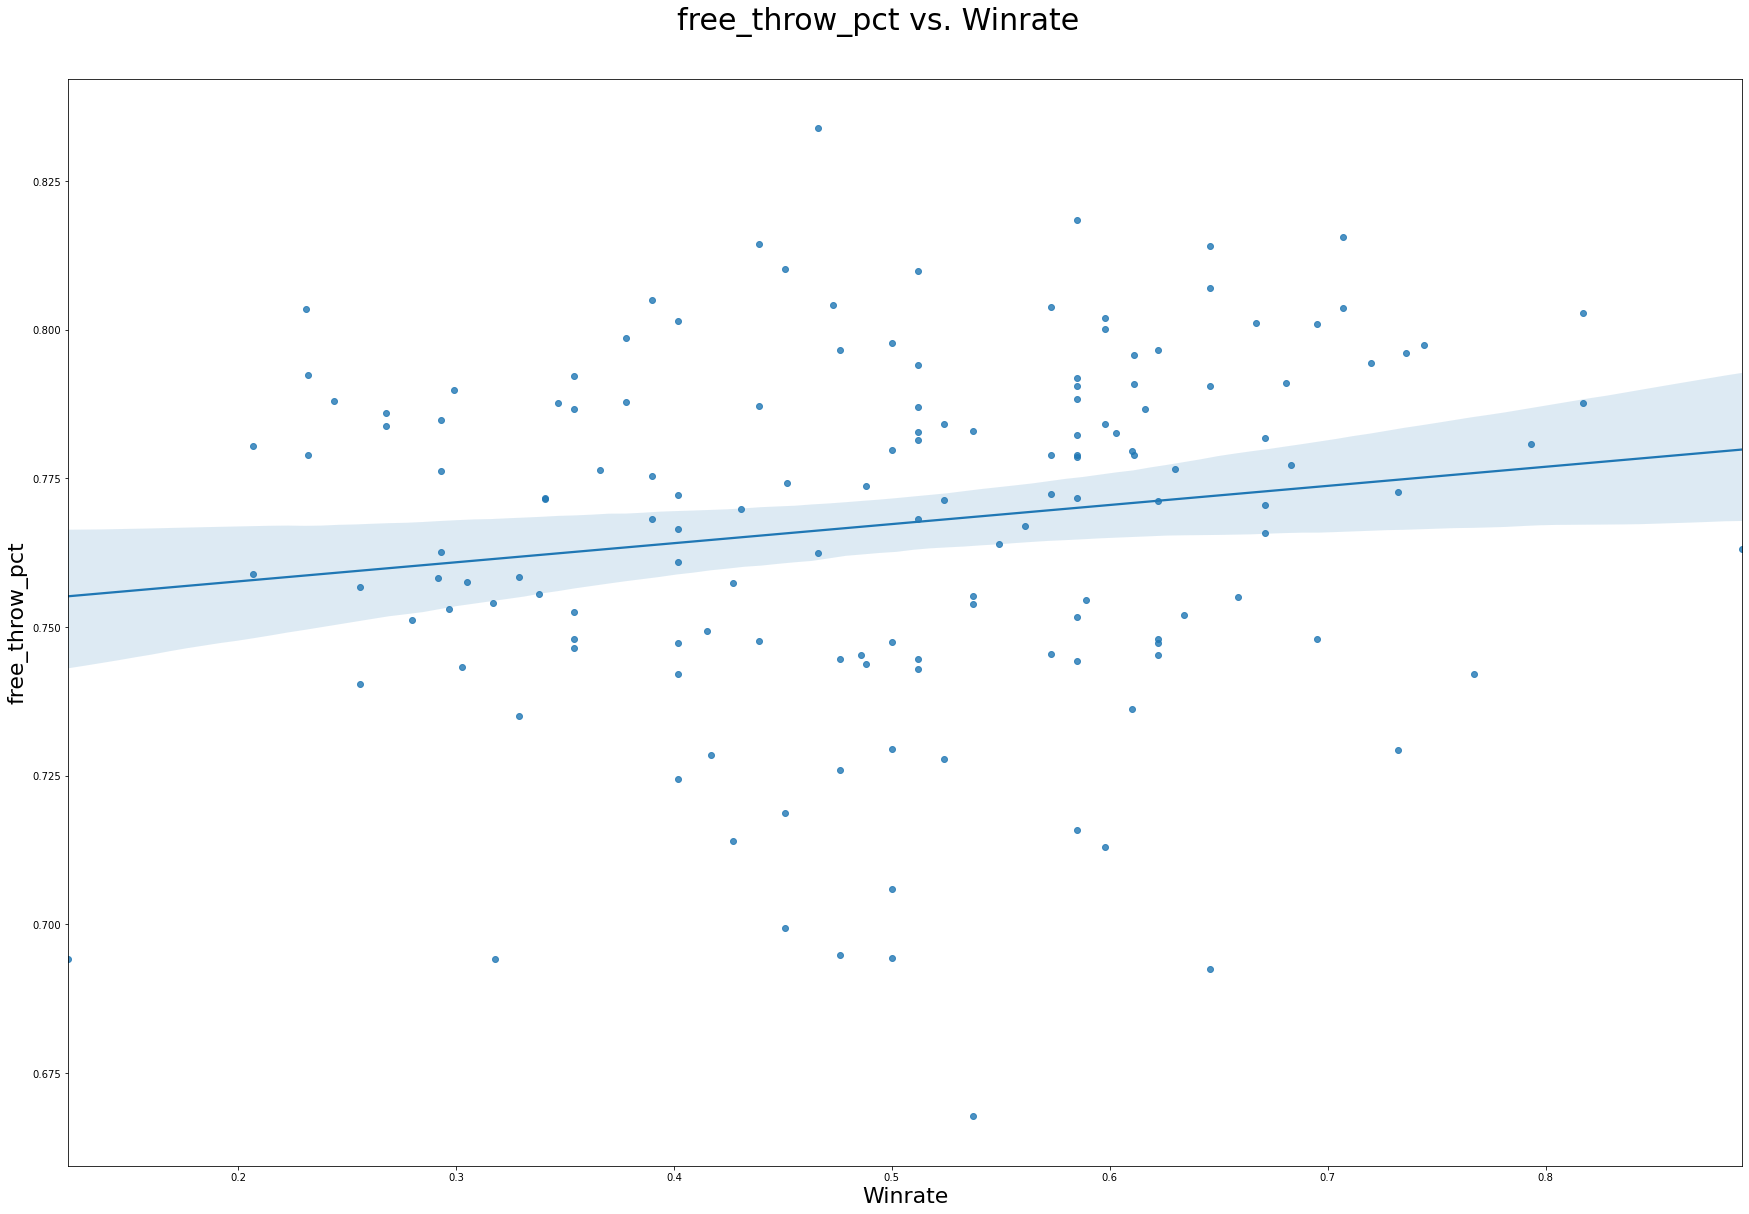

<Figure size 360x360 with 0 Axes>

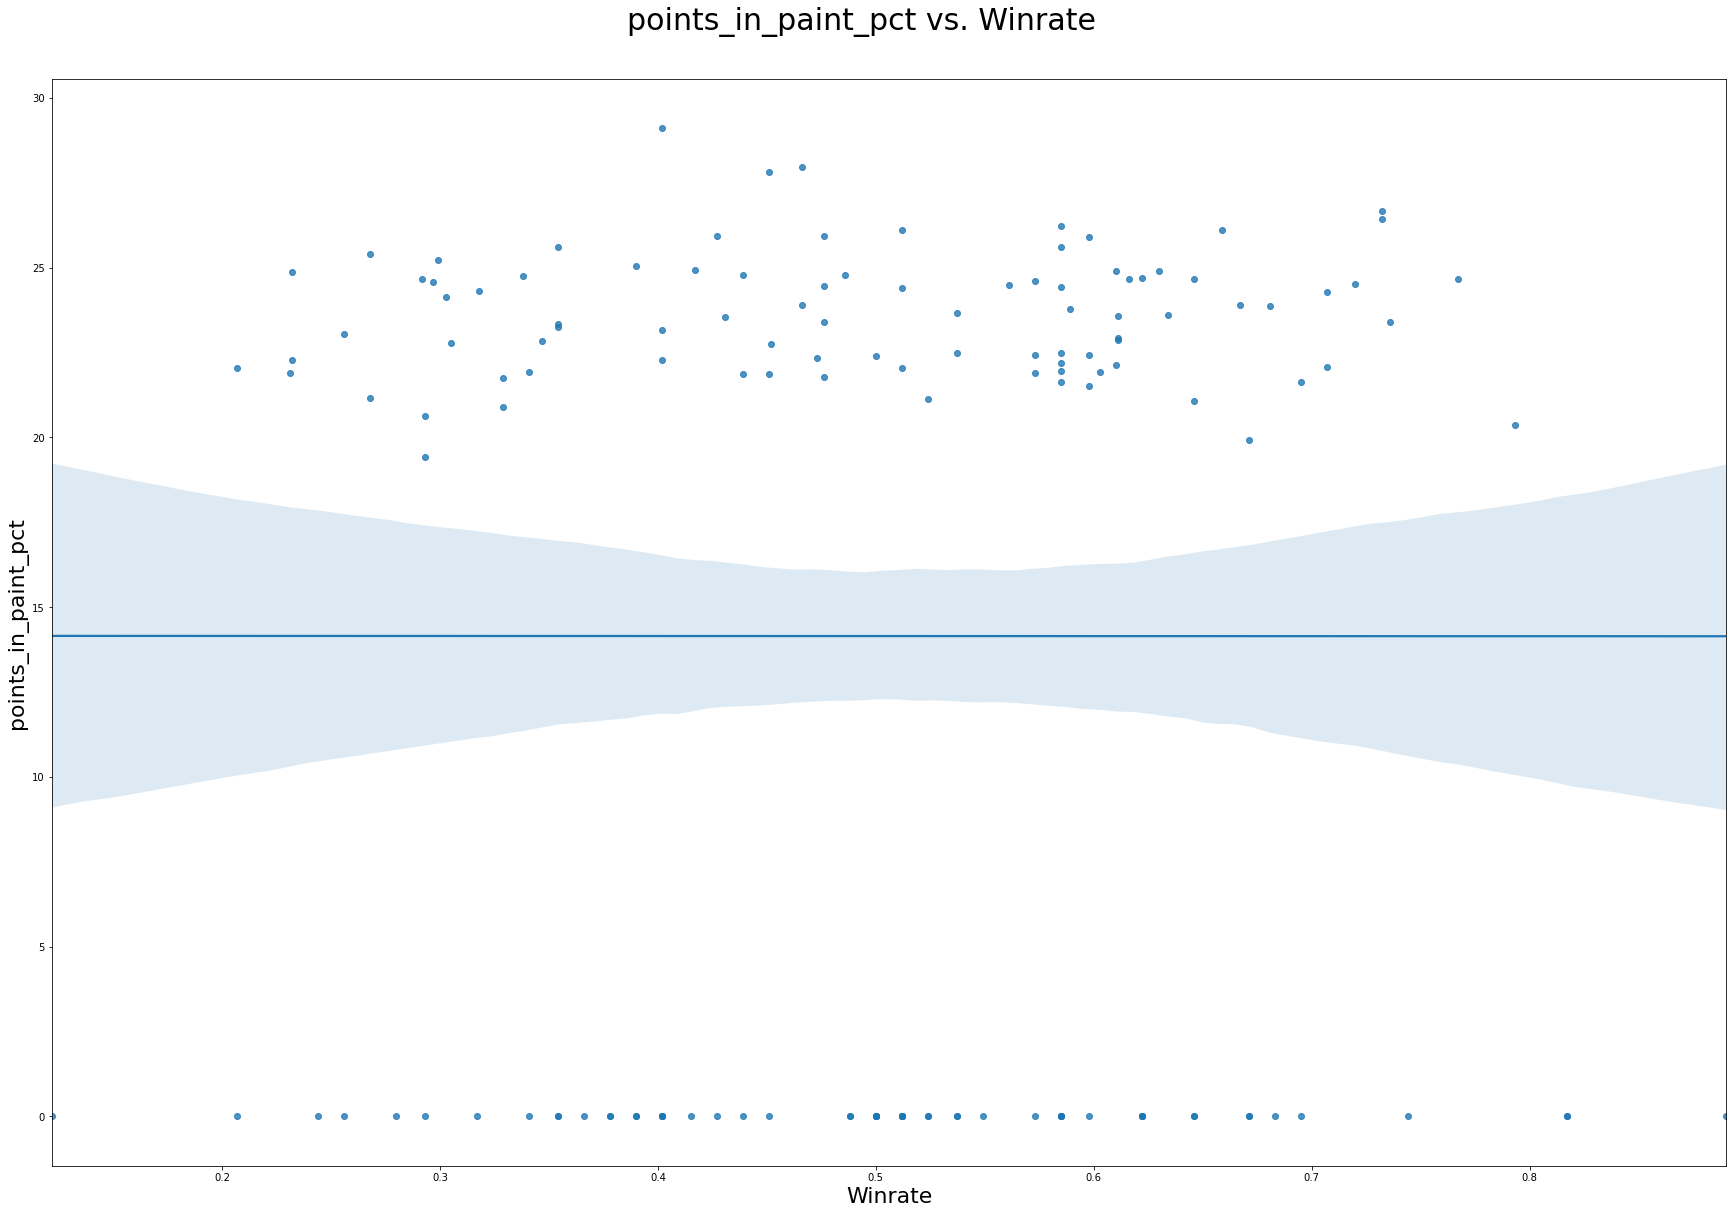

<Figure size 360x360 with 0 Axes>

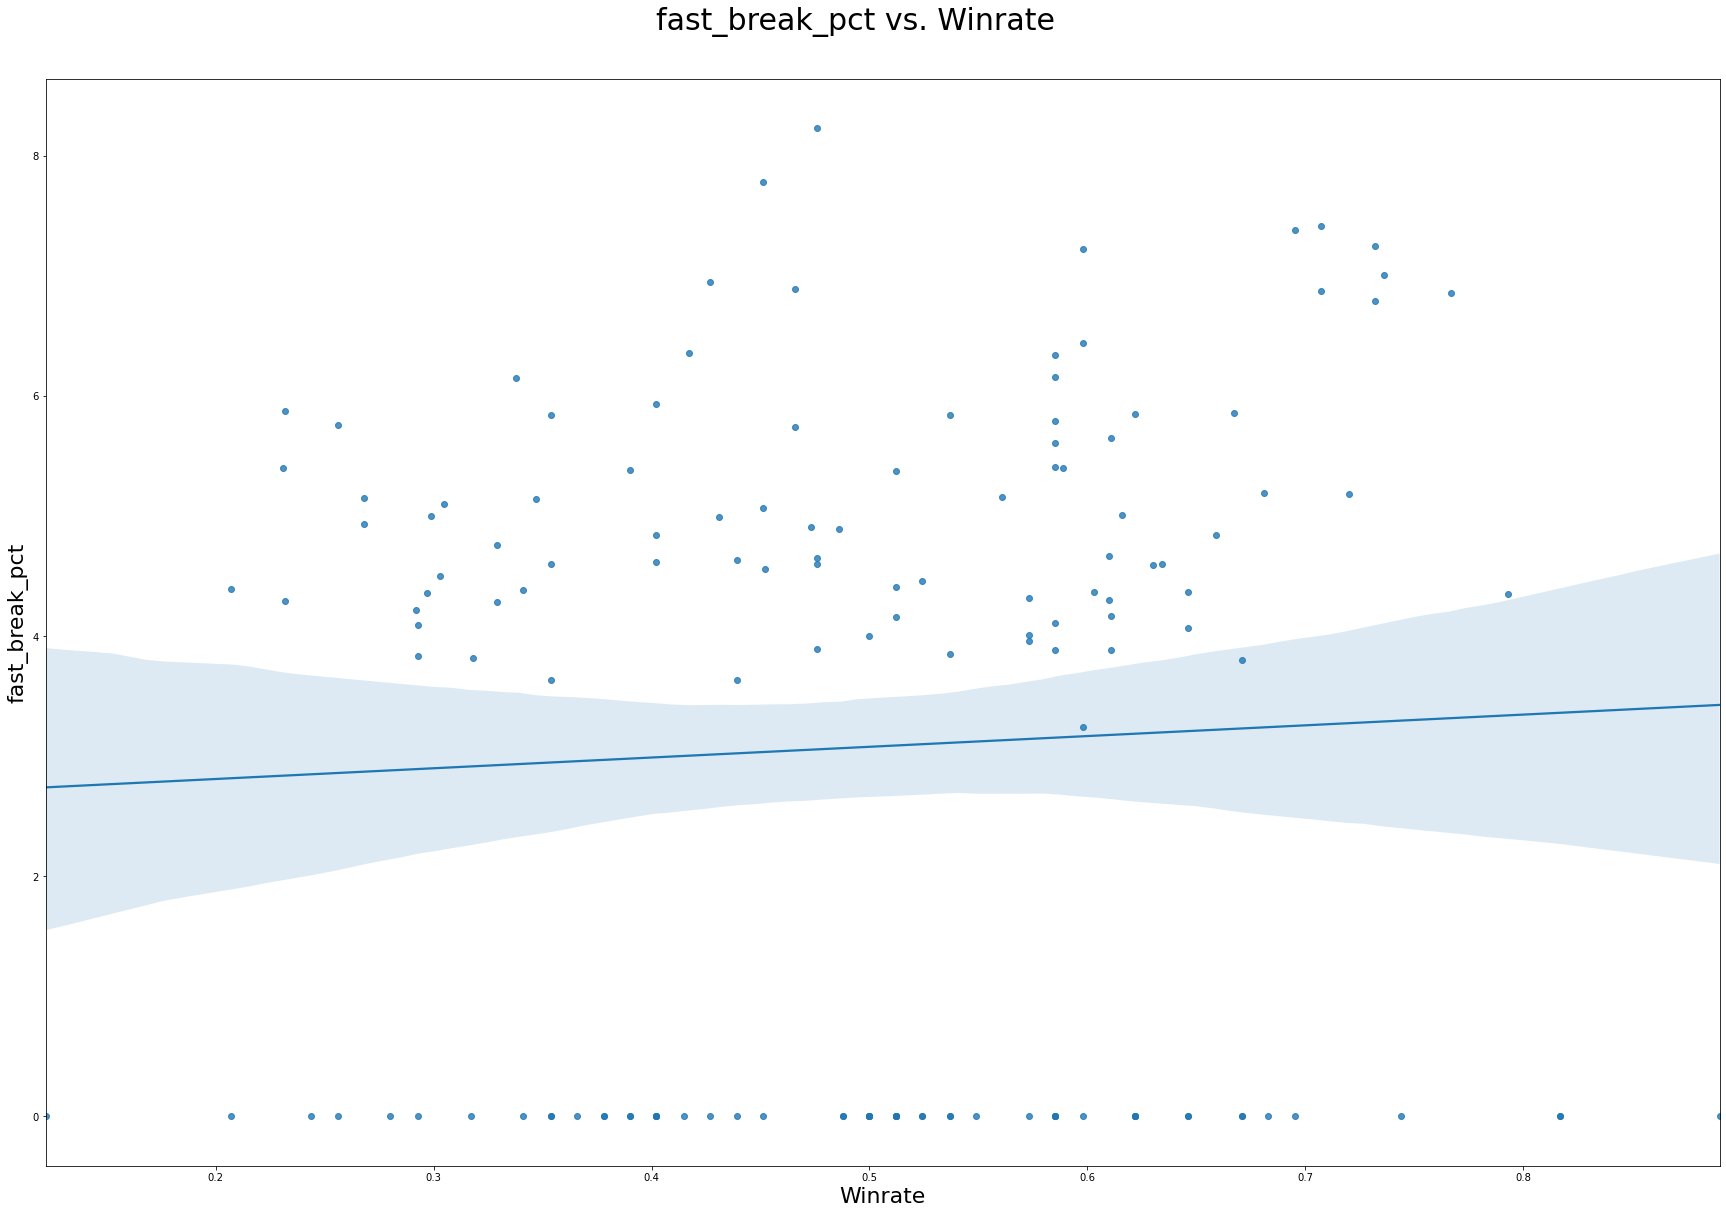

<Figure size 360x360 with 0 Axes>

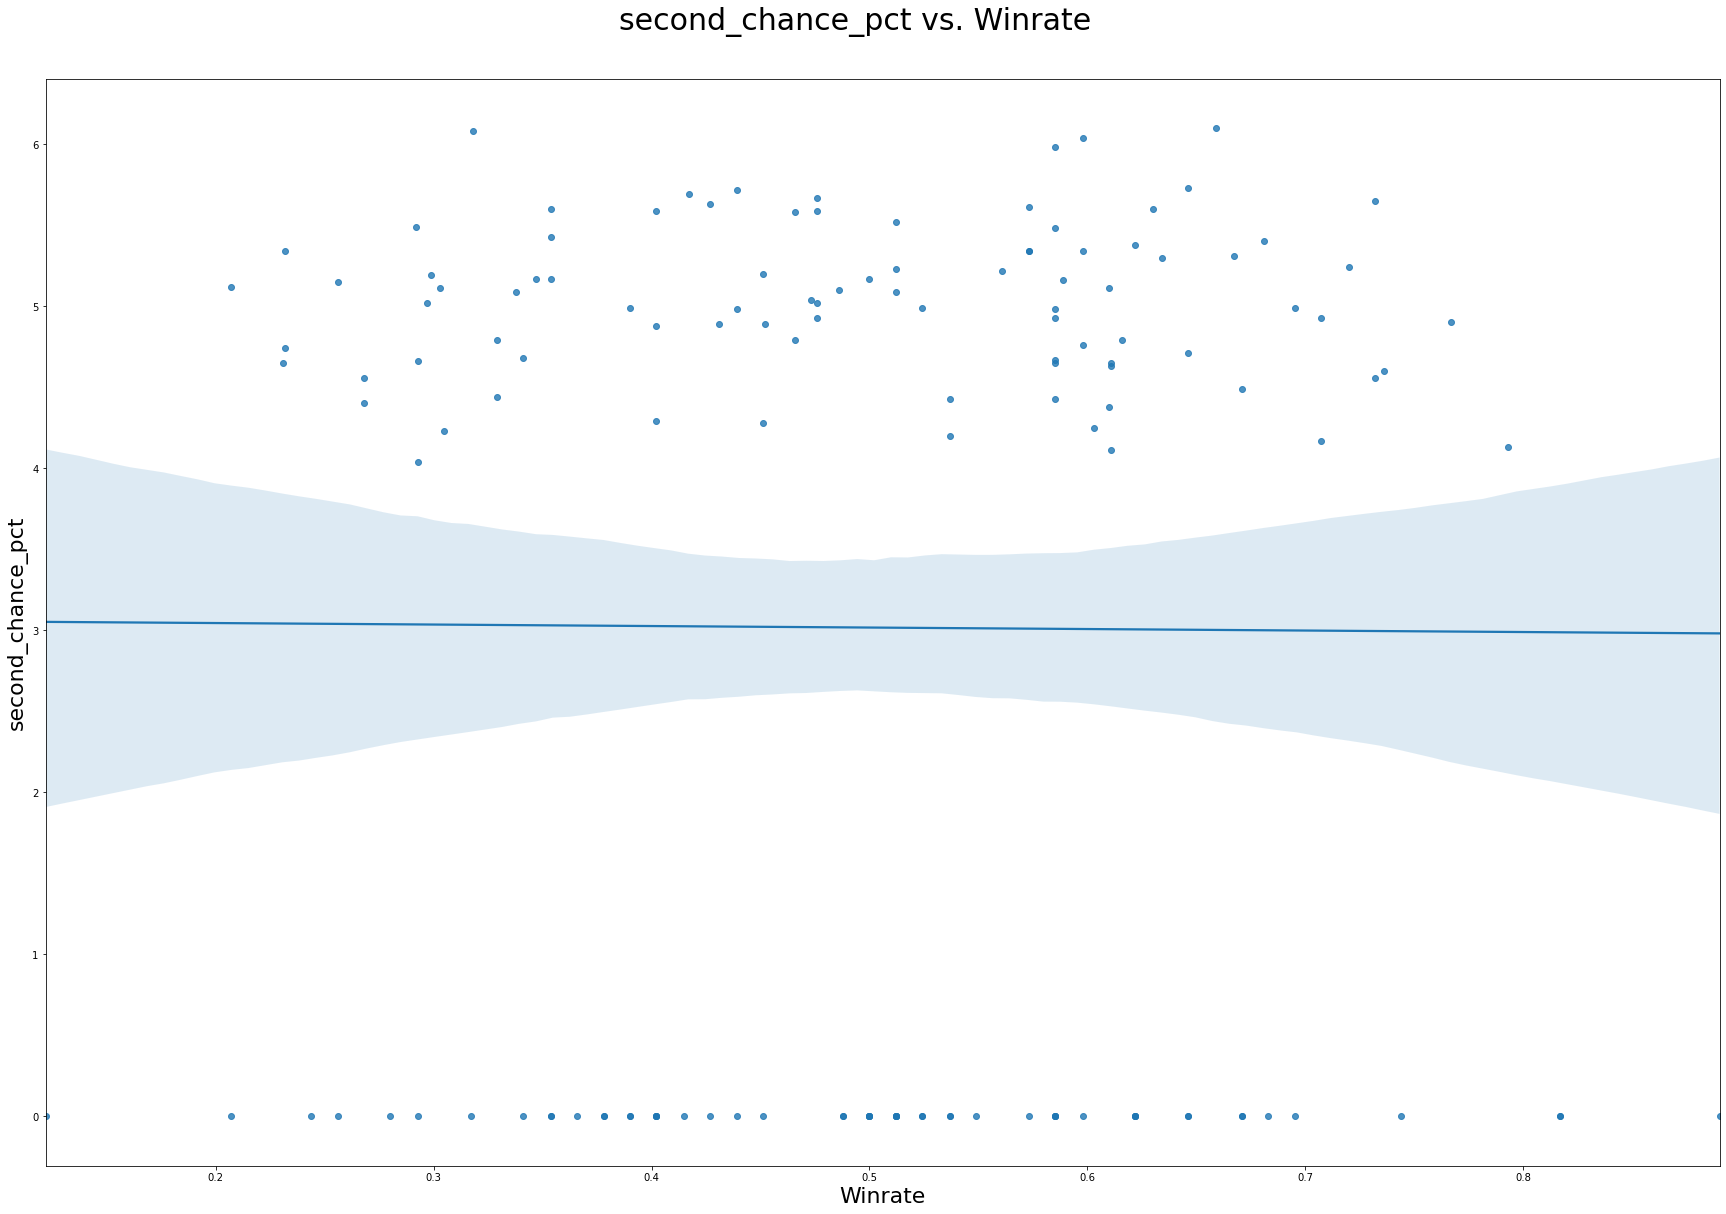

<Figure size 360x360 with 0 Axes>

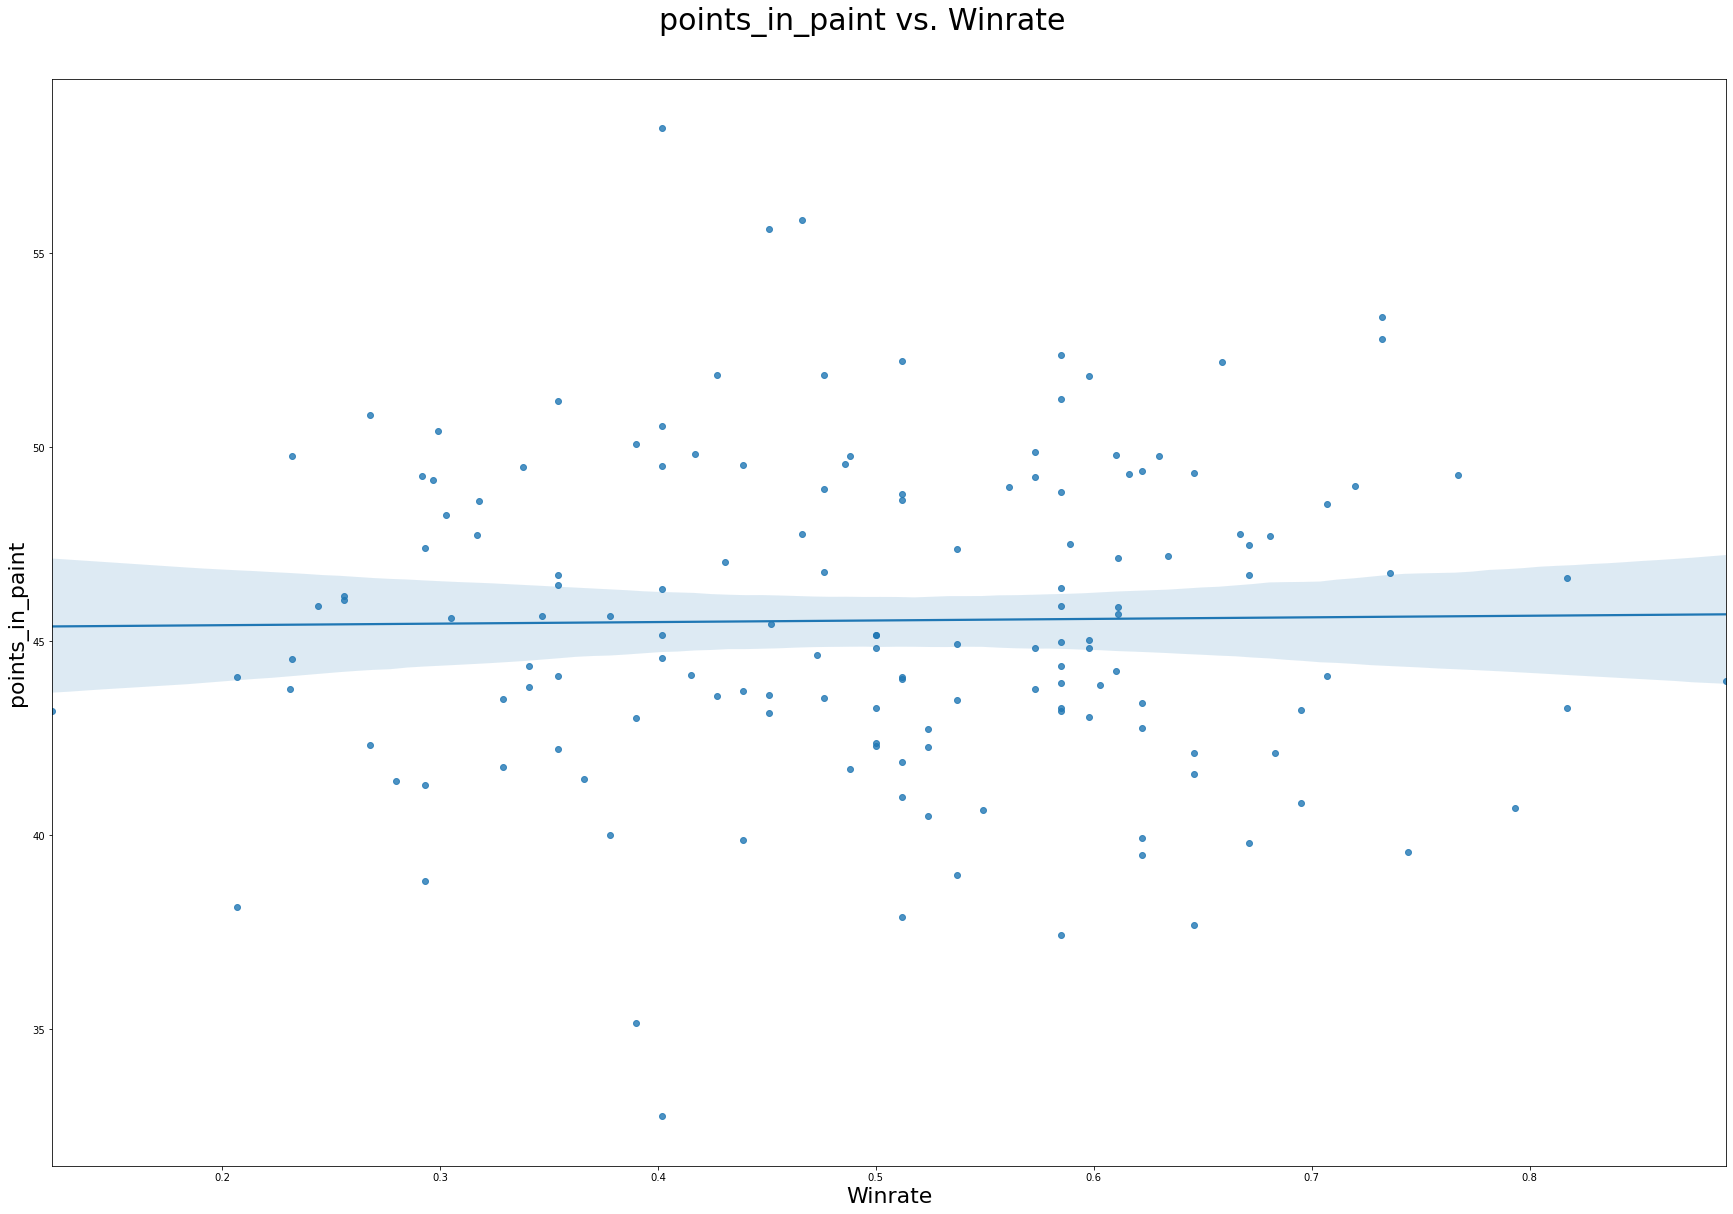

<Figure size 360x360 with 0 Axes>

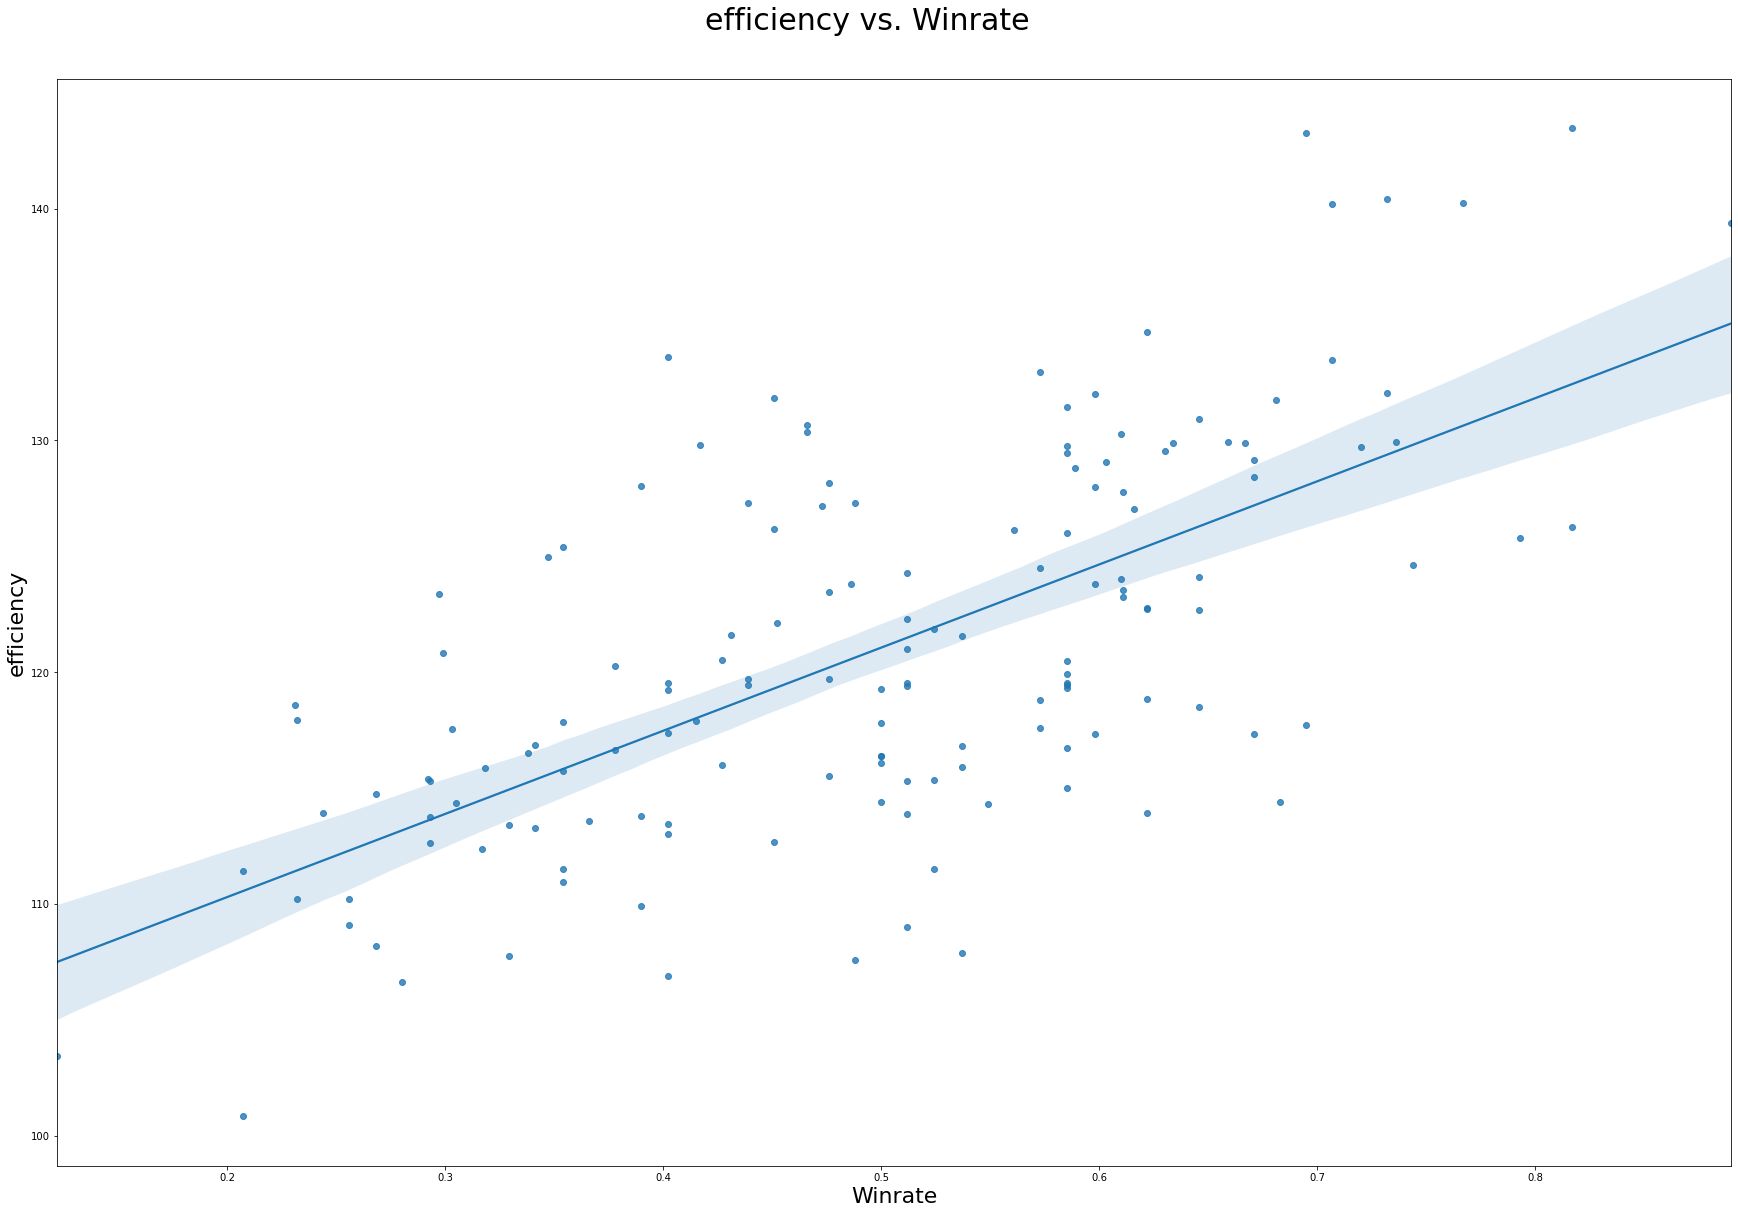

<Figure size 360x360 with 0 Axes>

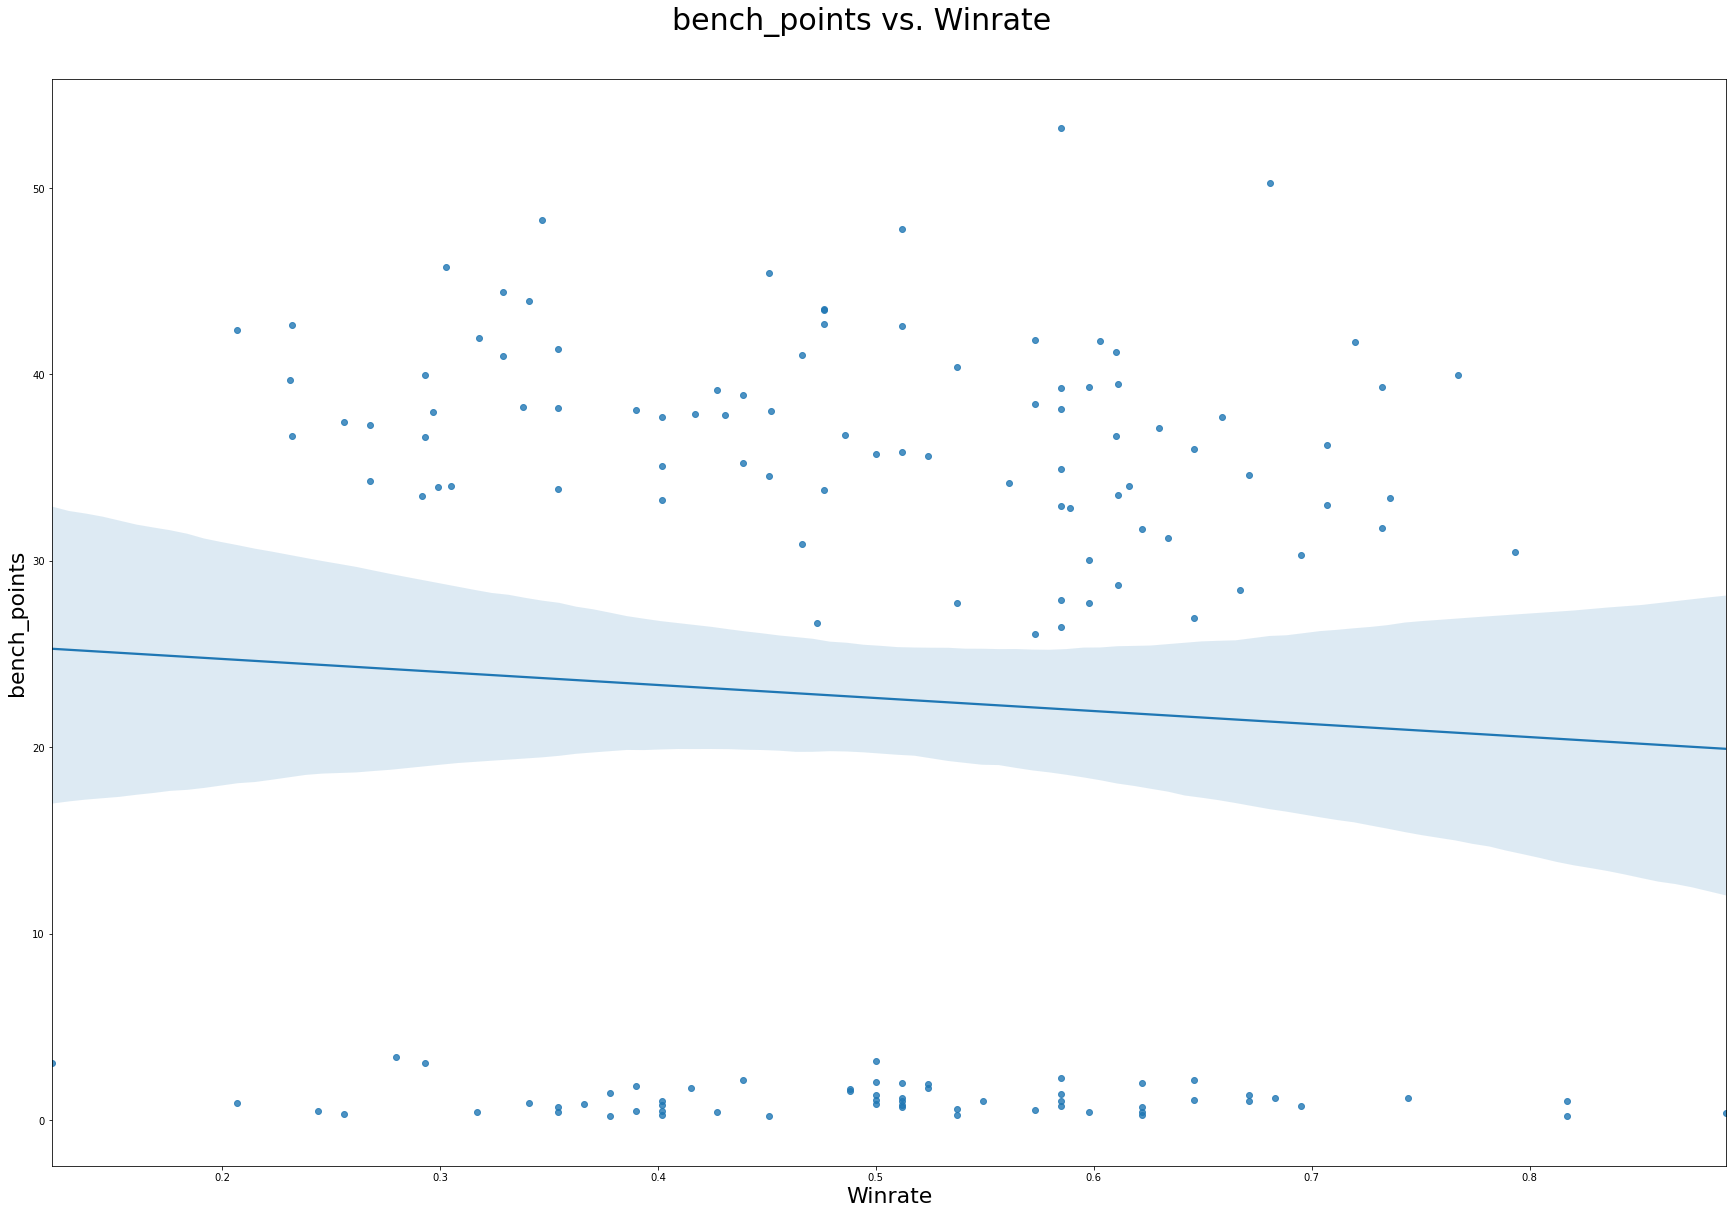

<Figure size 360x360 with 0 Axes>

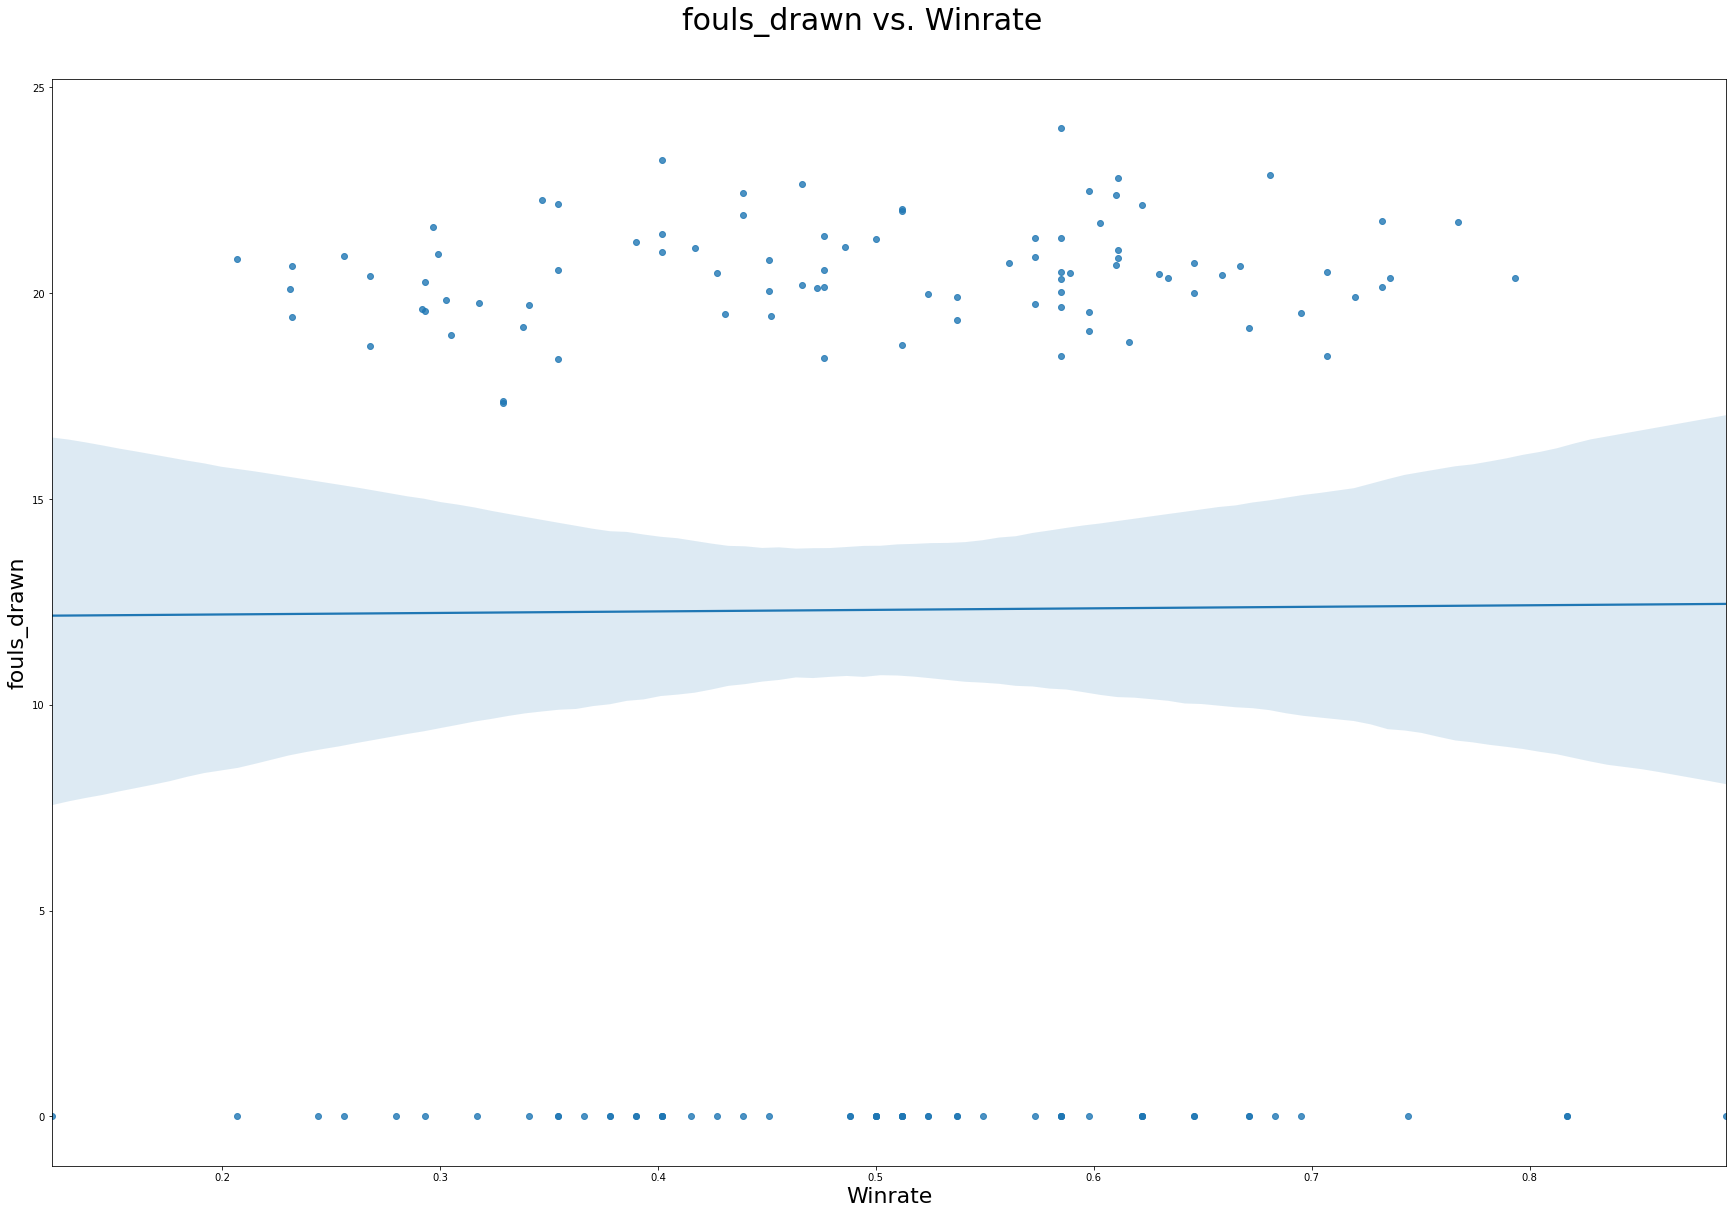

<Figure size 360x360 with 0 Axes>

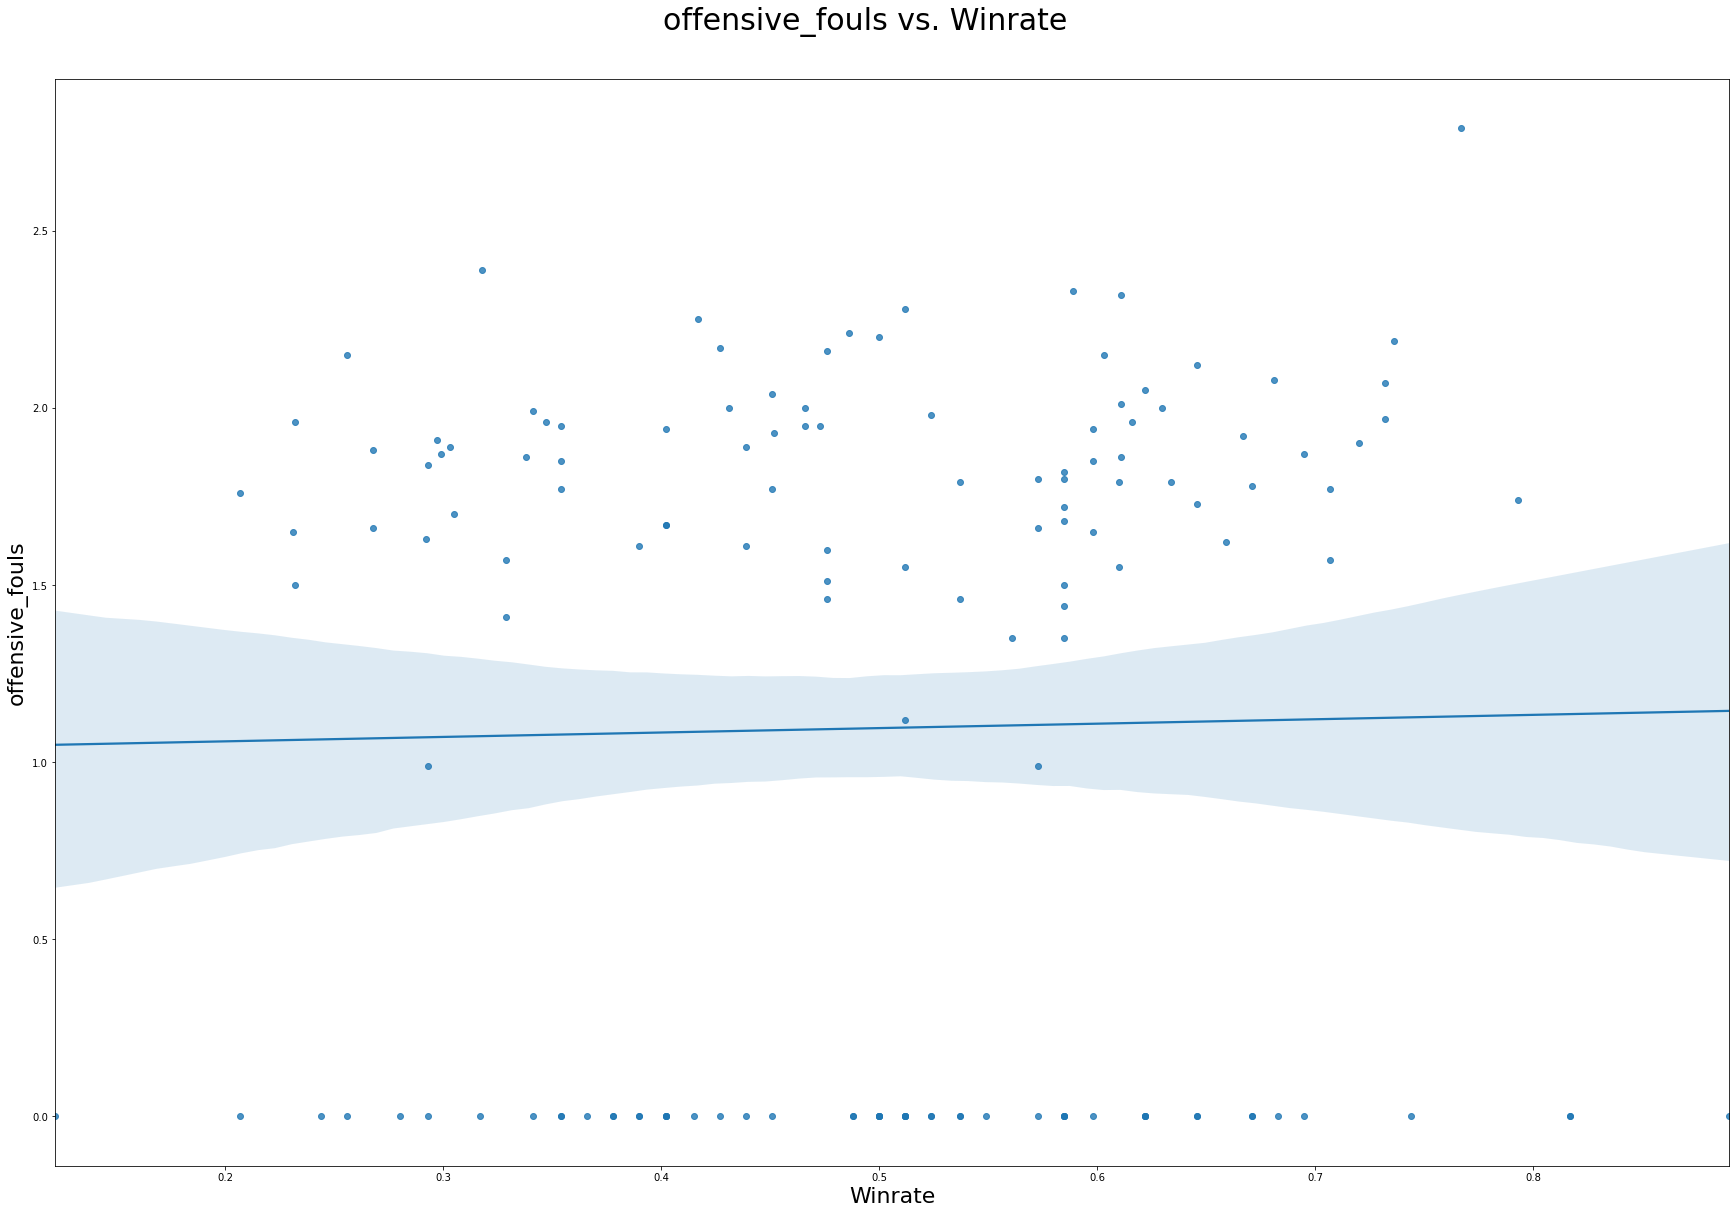

<Figure size 360x360 with 0 Axes>

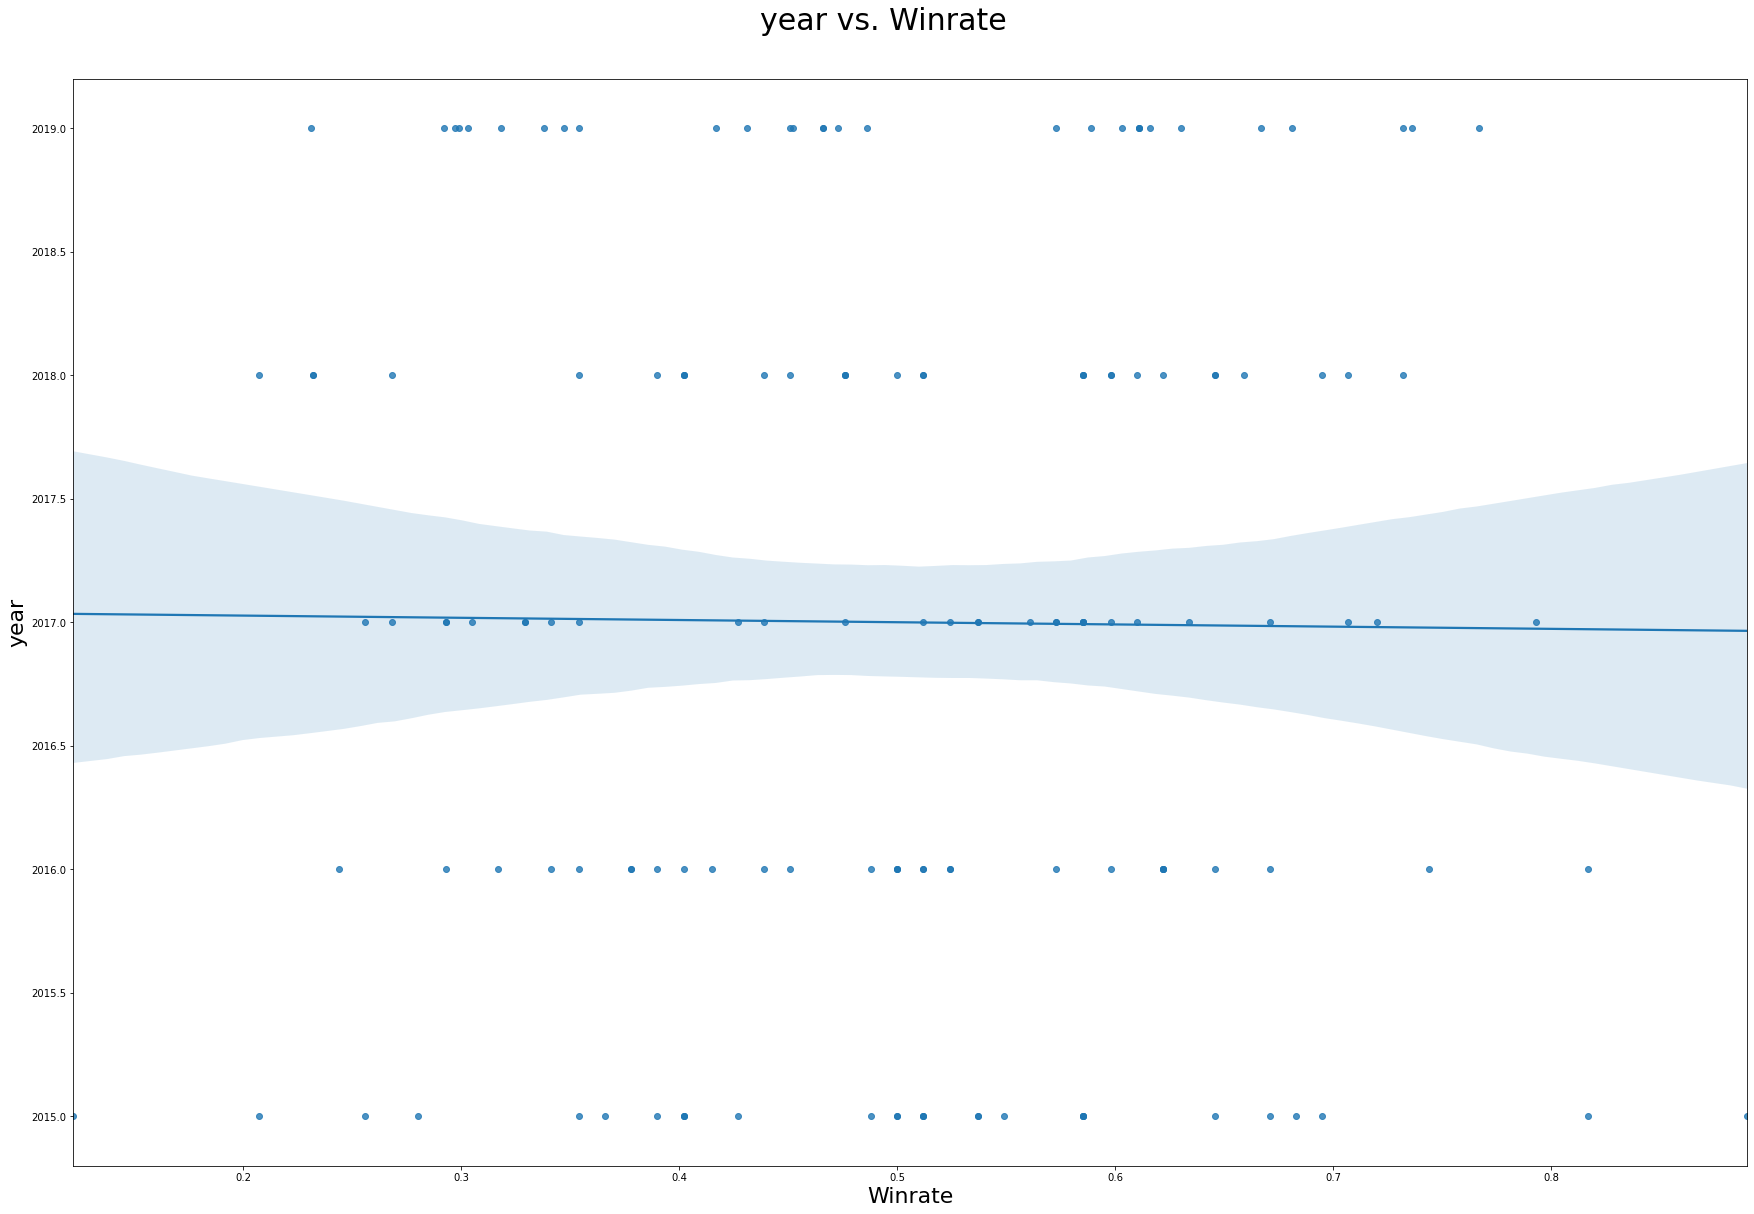

<Figure size 360x360 with 0 Axes>

In [266]:
# get columns from train_df
cols = all_data.columns

#number of rows=r , number of columns=c
r,c = all_data.shape

# number of attributes (exclude target)
size = len(cols)-1

# x-axis has target attribute to distinguish between classes
x = cols[size]

# y-axis shows values of an attribute
y = cols[0:size]

#Plot violin for all attributes
for i in range(0,size):
    fig = plt.figure(figsize=(30,20))
    sns.regplot(data=all_data,x=x,y=y[i])
    fig.suptitle(str(all_data.columns[i]) + ' vs. Winrate', fontsize=30, y=.93)
    plt.xlabel('Winrate', fontsize=22)
    plt.ylabel(str(all_data.columns[i]), fontsize=22)
    plt.show()
    plt.clf()

#### label imbalance <a class="anchor" id="section_2_2"></a>

The next step is to check if there is an imbalance is the response variables. This is also important since it's a multi-class problem where one could have more than two outcomes. If there is a significant difference in the number of observations for each type class, the learning algorithm will exhibit markedly poor performance. 

(array([ 1.,  2.,  6., 11., 13., 13., 12., 16., 16., 21., 18.,  9.,  7.,
         2.,  2.,  1.]),
 array([0.122, 0.17 , 0.218, 0.266, 0.314, 0.362, 0.41 , 0.458, 0.506,
        0.554, 0.602, 0.65 , 0.698, 0.746, 0.794, 0.842, 0.89 ]),
 <a list of 16 Patch objects>)

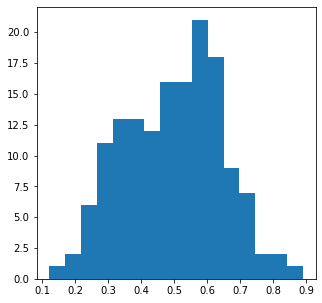

In [88]:
# check observations by response variable
plt.hist(all_data['winrate'], bins=16)

In this case each class has roughly the same number of observations centered around 50%, with a slight sskew left so the dataset is not imbalanced enough to justify additional data manipulation.

#### missing data <a class="anchor" id="section_2_3"></a>

It is important to check if there are any missing data that might need to be imputed or removed. Luckily the data is pretty clean so no need to worry about that. 

In [89]:
# check number of null values by columns
all_data.isnull().sum()

fast_break_pts          0
turnover_points         0
second_chance_points    0
points                  0
offensive_rebounds      0
defensive_rebounds      0
rebounds                0
assists                 0
steals                  0
blocks                  0
turnovers               0
personal_fouls          0
flagrants               0
blocked_att             0
field_goals_pct         0
three_point_pct         0
two_point_pct           0
free_throw_pct          0
points_in_paint_pct     0
fast_break_pct          0
second_chance_pct       0
points_in_paint         0
efficiency              0
bench_points            0
fouls_drawn             0
offensive_fouls         0
year                    0
winrate                 0
dtype: int64

### Data Preperation <a class="anchor" id="DataPrep"></a>



#### preprocessing <a class="anchor" id="section_3_1"></a>

Preparing the data for modeling is important since it can speed up the process and produce better models. As the adage goes, "garbage in garbage out," so the data being modeled needs to be clean and ready for both learning and prediction.

First, the columns with standard deviation of 0 will be dropped. Removing unnecessary columns reduces complexity and adheres to the Occam's Razor principle. 

In [97]:
model_data = data.final_frame

In [98]:
# columns with std = 0    
rm = model_data.std()[model_data.std() == 0].index.values

# drop the columns 
model_data.drop(rm, axis=1,inplace=True)

Split data in to train and test

**Note**: The following code will work well given that you have ensured that the class column is the final column in the dataset.

In [123]:
col_length = len(model_data.columns)

#Y is the target column, X has the rest
X = model_data.iloc[:, 0:col_length-2]
y = model_data.iloc[:, col_length-1:col_length]

#Validation chunk size
val_size = 0.2

#Use a common seed in all experiments so that same chunk is used for validation
seed = 0

#Split the data into chunks
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=seed)


All the categorical variables in the input dataset are in numerical form. Hence, one does not need to think about one-hot encoding them. However, we will be label encoding the binary output column to make it usable in our classificationmodel.

In [124]:
#Import libraries for data transformations
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical 

#Initialize LabelEncoder instance
le = LabelEncoder()

#Fit and transform the CT on the training and test data
y_train = le.fit_transform(y_train.astype(str))
y_val = le.fit_transform(y_val.astype(str))

#Convert the training and test data categorical labels into usable integers
y_train = to_categorical(y_train, dtype='int64')
y_val = to_categorical(y_val, dtype='int64')

Normalizing the dataset with the `StandardScaler`. It's often a good idea to normalize data. A common way to do so is by standardization. Standardization will set the mean to 0 with a unit standard deviation (standard deviation equal to 1). This can be done across all columns using `ColumnTransformer`.

In [125]:
#Import libraries for data transformations
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#Initialize ColumnTransformer instance
ct = ColumnTransformer([('scale', StandardScaler(), list(X.columns))], remainder='passthrough')

#Fit and transform the CT on the training and test data
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)


### Prediction <a class="anchor" id="Prediction"></a>


#### model building <a class="anchor" id="section_4_1"></a>


Now to create a model. A neural network will be created to find the best possible weights to predict the outcome of ay given basketball game, given the home and away teams' stats.

The first step is to design the architecture of the model. The first combination will start small, and if needed depth and density can be added to the model.

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

# Create model
model = Sequential()
model.add(InputLayer(input_shape = X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', 
                optimizer=Adam(learning_rate=.0005), 
                metrics=['accuracy'])

Now `X_train` and `y_train` will be used to train the model with `accuracy` and `val_accuracy` as the measures for the model. 

Below it can be seen that `KNN` with the original data did the best with `CART` or decision tree with the original data in second place. 

In [140]:
from tensorflow.keras.callbacks import EarlyStopping

# Set initial hyperparameter values
epochs = 100
callbacks = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          verbose=1,
                          patience=30)
batch_size = 16

# evaluate each model in turn
history = model.fit(X_train, 
                            y_train, 
                            epochs = epochs, 
                            batch_size = batch_size, 
                            validation_data = (X_val, y_val), 
                            verbose = 1, 
                            callbacks = [callbacks])

Epoch 1/100
299/299 [==============================] - 1s 2ms/step - loss: 0.9653 - accuracy: 0.5176 - val_loss: 0.6556 - val_accuracy: 0.6171
Epoch 2/100
299/299 [==============================] - 0s 751us/step - loss: 0.7492 - accuracy: 0.5732 - val_loss: 0.6465 - val_accuracy: 0.6321
Epoch 3/100
299/299 [==============================] - 0s 743us/step - loss: 0.6908 - accuracy: 0.5848 - val_loss: 0.6455 - val_accuracy: 0.6371
Epoch 4/100
299/299 [==============================] - 0s 756us/step - loss: 0.6943 - accuracy: 0.5773 - val_loss: 0.6464 - val_accuracy: 0.6346
Epoch 5/100
299/299 [==============================] - 0s 773us/step - loss: 0.6758 - accuracy: 0.5976 - val_loss: 0.6448 - val_accuracy: 0.6296
Epoch 6/100
299/299 [==============================] - 0s 742us/step - loss: 0.6578 - accuracy: 0.6066 - val_loss: 0.6400 - val_accuracy: 0.6396
Epoch 7/100
299/299 [==============================] - 0s 745us/step - loss: 0.6554 - accuracy: 0.6186 - val_loss: 0.6371 - val_accu

299/299 [==============================] - 0s 733us/step - loss: 0.6169 - accuracy: 0.6683 - val_loss: 0.6039 - val_accuracy: 0.6714
Epoch 58/100
299/299 [==============================] - 0s 763us/step - loss: 0.5996 - accuracy: 0.6858 - val_loss: 0.6044 - val_accuracy: 0.6756
Epoch 59/100
299/299 [==============================] - 0s 754us/step - loss: 0.6045 - accuracy: 0.6801 - val_loss: 0.6052 - val_accuracy: 0.6722
Epoch 60/100
299/299 [==============================] - 0s 764us/step - loss: 0.6138 - accuracy: 0.6685 - val_loss: 0.6034 - val_accuracy: 0.6722
Epoch 61/100
299/299 [==============================] - 0s 742us/step - loss: 0.6030 - accuracy: 0.6720 - val_loss: 0.6017 - val_accuracy: 0.6764
Epoch 62/100
299/299 [==============================] - 0s 741us/step - loss: 0.6085 - accuracy: 0.6778 - val_loss: 0.6037 - val_accuracy: 0.6756
Epoch 63/100
299/299 [==============================] - 0s 740us/step - loss: 0.5973 - accuracy: 0.6820 - val_loss: 0.6043 - val_accuracy

##### hyperparameter tuning <a class="anchor" id="section_4_1_1"></a>

From the default settings for the models, it was checked if some minor improvements could be obtained. The `Adam` optimizer was selected since it had some hyperparameters that could be changed.

It was found that a simple, shallow neural network with minimal nodes in the hidden layers worked best, with significant dropout to minimize overfitting. In addition, the learning rate needed to be decreased drastically from the default of .01 to a much lower rate of .0005, and accuracy and validation accuracy peaked at a batch size of 16.


#### model evaluation <a class="anchor" id="section_4_1_2"></a>
The model's validation accuracy and loss is evaluated using `model.evaluate`, and the progression of training and validation loss and accuracy will be visualized by plotting it against the domain of epochs.

In [141]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print('Validation Accuracy: {}\nValidation Loss: {}'.format(accuracy, 
                                                            loss))

Validation Accuracy: 0.6772575378417969
Validation Loss: 0.6037737727165222


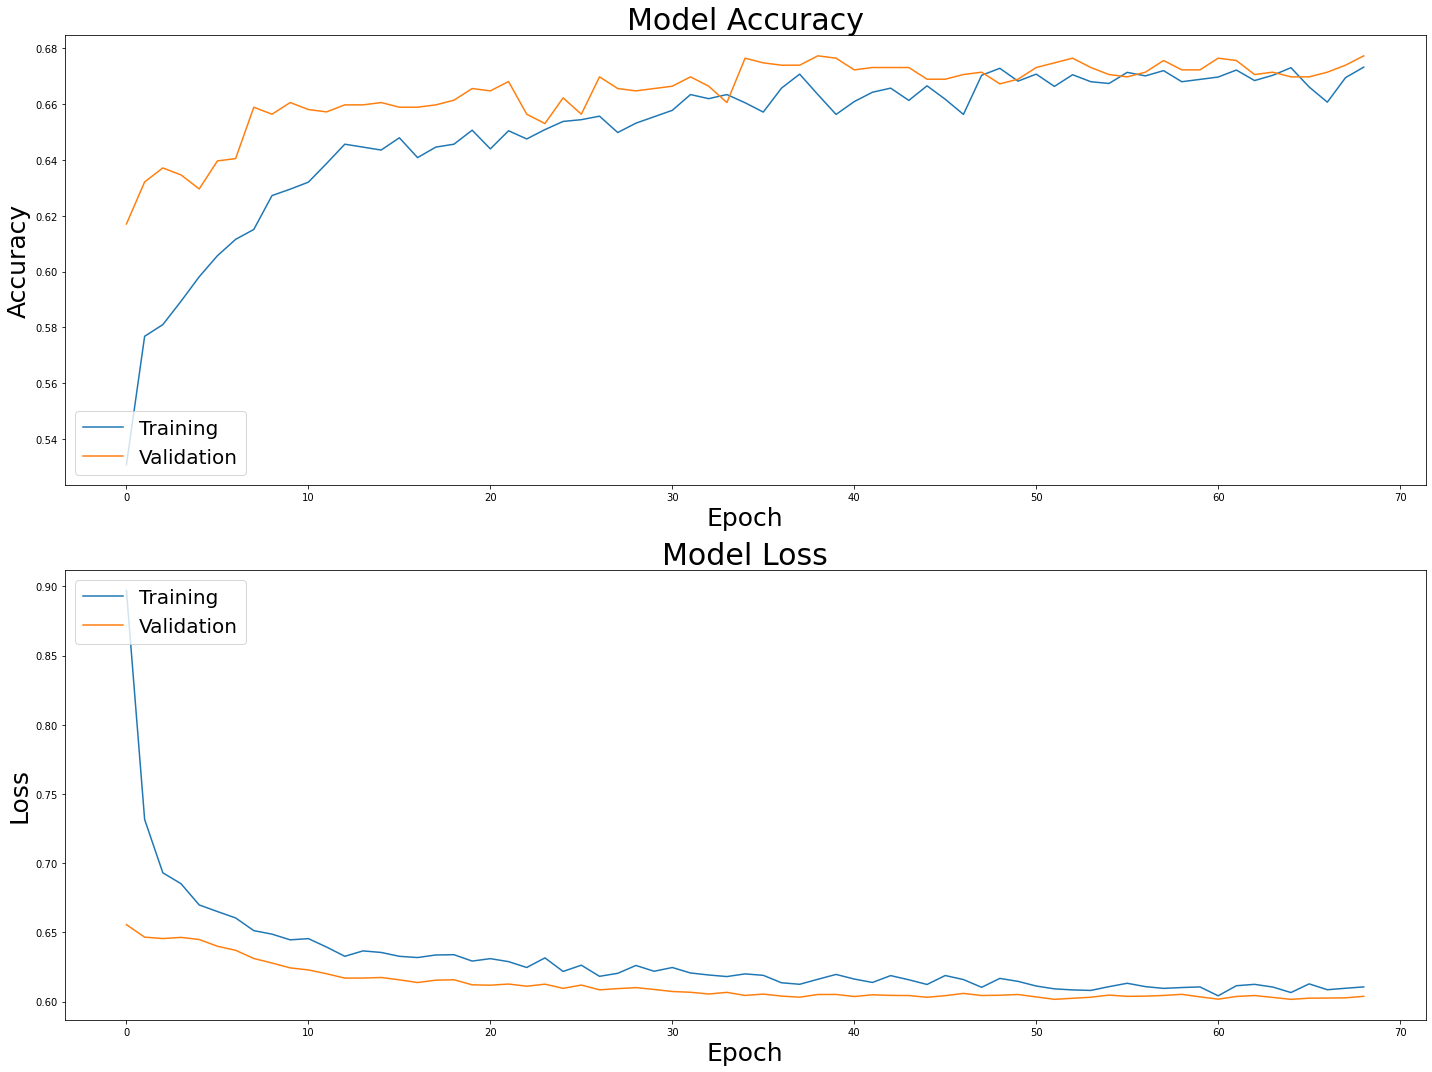

<Figure size 360x360 with 0 Axes>

In [175]:
# Plot accuracy and val accuracy over each epoch
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy', fontsize=30)
ax1.set_ylabel('Accuracy', fontsize=25)
ax1.set_xlabel('Epoch', fontsize=25)
ax1.legend(['Training', 'Validation'], loc='lower left', fontsize=20)
 
# Plot loss and val_loss over each epoch
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss', fontsize=30)
ax2.set_ylabel('Loss', fontsize=25)
ax2.set_xlabel('Epoch', fontsize=25)
ax2.legend(['Training', 'Validation'], loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()
plt.clf()

A confusion matrix will be used to further visualize any classification bias in the model, and the false positive/negative rate for each potential outcome. Columns 0 and 1 represent predicted home or away win, respectively, and rows 0 and 1 represent true home and away wins, respectively.

In [192]:
from sklearn.metrics import confusion_matrix

#Create and print confusion matrix 
expected = np.argmax(y_val, axis=1)
predicted = np.argmax(model.predict(X_val), axis=1)
conf_matrix = confusion_matrix(expected, predicted)
print(conf_matrix)

[[571 125]
 [261 239]]


One can see that this model is far more successful in predicting the winner when that winner is the home team. The model errs on the side of predicting home team wins, which could be a direct result of a so called "home-team advantage", which can not be quantified or measured by the model, so it would only become apparent in an outcome like this.

### Conclusion <a class="anchor" id="Conclusion"></a>



#### general comments <a class="anchor" id="section_5_1"></a>

In this project, the following was accomplished: take data from Kaggle, explore the dataset, preprocess attributes, make and compare various multi-class models. In this case, highly non-linear models like decision trees and KNN seemed to be the best performing and these methods seemed to do better with non-transformed variables.


#### next steps <a class="anchor" id="section_5_2"></a>

The next steps will be to evaluate this model's live performance against real life basktball games, and evaluate the predictive accuracy. Additionally, since this model outputs probabilities of the winner being 0 or 1 (home or away), the Kelly Criterion can be applied against bookmaker monelines to maximize the return off of bets made using the model.

### Further Analysis <a class="anchor" id="Further_Analysis"></a>

#### retrieve data <a class="anchor" id="section_6_1"></a>
In order to predict the outcome for the games on a given day, you first need to retrieve the lineups on that day.

In [207]:
import datetime

# Save each aspect of the current date to a usable variable for the API
today = datetime.datetime.now()
year = today.year
season_year = 2020
month = str(today.month)
day = str(today.day)
if len(month) == 1:
    month = '0'+month
if len(day) == 1:
    day = '0'+day
time.sleep(1)
url = 'https://api.sportradar.us/nba/trial/v7/en/games/{}/{}/{}/schedule.json?api_key={}'.format(year, 
                                                                                                 month,
                                                                                                 day,
                                                                                                 APIKEY)
# Create a dataframe with two columns, home and away, each containing the day's matchups
daily_schedule = requests.get(url).json()
home = []
away = []
for game in daily_schedule['games']:
    home.append(game['home']['name'])
    away.append(game['away']['name'])
daily_sched_frame = pd.DataFrame({'home':home, 'away':away})

# Adjust the LA Clippers row so it is usable with the rest of the data
if 'LA Clippers' in list(daily_sched_frame.away.values):
    daily_sched_frame['away'] = daily_sched_frame['away'].replace(['LA Clippers'], 'Los Angeles Clippers')
if 'LA Clippers' in list(daily_sched_frame.home.values):
    daily_sched_frame['home'] = daily_sched_frame['home'].replace(['LA Clippers'], 'Los Angeles Clippers')

#### format data <a class="anchor" id="section_6_2"></a>
To use the data as an input to the model, each team must be replaced by it's seasonal data to date for the current year.

In [209]:
# Create a dataframe of stats for each team in the schedule, 
# and concatenate them into their same order in the schedule frame
daily_stats = []
for x in range(len(daily_sched_frame)):
    row = daily_sched_frame.iloc[x]
    home = row['home']
    away = row['away']
    home_data = data.get_team_stats(home, season_year).reset_index()
    time.sleep(1)
    away_data = data.get_team_stats(away, season_year).reset_index()
    time.sleep(1)
    home_data.columns = [x + '_home' for x in list(home_data.columns)]
    away_data.columns = [x + '_away' for x in list(away_data.columns)]

    team_data = pd.concat([home_data, away_data], axis=1)

    daily_stats.append(team_data)

# Remove the columns with insufficient data
daily_data = pd.concat(daily_stats)
daily_data.drop('points_in_paint_pct_home', axis=1, inplace=True)
daily_data.drop('fast_break_pct_home', axis=1, inplace=True)
daily_data.drop('second_chance_pct_home', axis=1, inplace=True)
daily_data.drop('fouls_drawn_home', axis=1, inplace=True)
daily_data.drop('offensive_fouls_home', axis=1, inplace=True)
daily_data.drop('year_home', axis=1, inplace=True)
daily_data.drop('index_home', axis=1, inplace=True)
daily_data.drop('points_in_paint_pct_away', axis=1, inplace=True)
daily_data.drop('fast_break_pct_away', axis=1, inplace=True)
daily_data.drop('second_chance_pct_away', axis=1, inplace=True)
daily_data.drop('fouls_drawn_away', axis=1, inplace=True)
daily_data.drop('offensive_fouls_away', axis=1, inplace=True)
daily_data.drop('year_away', axis=1, inplace=True)
daily_data.drop('index_away', axis=1, inplace=True)

Use the ColumnTransformer fitted on the model training data, `X_train` to transform the column values in the new daily schedule data dataframe

In [210]:
scaled_data = ct.transform(daily_data)

#### make predictions <a class="anchor" id="section_6_3"></a>
Using the scaled data as the input to the model will result in an output of the model's confidence that either home(0) or away(1) will win the game. This can be interpreted as the derived probability each team has of winning.

In [217]:
# Retrieve prediction for each matchup and create dataframe mapping each team to its prob of winning
home = []
away = []
predictions = []
for i in range(len(daily_sched_frame)):
    home.append(daily_sched_frame['home'].iloc[i])
    away.append(daily_sched_frame['away'].iloc[i])
    predictions.append(model.predict([scaled_data[i].reshape(1, X_val[i].shape[0])])[0])

predictions_frame = pd.DataFrame({'home':home, 'away':away, 'prediction':predictions})

Visualize the prediction data in a dataframe

In [218]:
predictions_frame

,home,away,prediction
0,Indiana Pacers,Minnesota Timberwolves,"[0.70917124, 0.2908287]"
1,Orlando Magic,Washington Wizards,"[0.39795664, 0.6020434]"
2,Brooklyn Nets,New Orleans Pelicans,"[0.6763529, 0.32364708]"
3,Boston Celtics,New York Knicks,"[0.74186784, 0.25813222]"
4,Houston Rockets,Dallas Mavericks,"[0.33440328, 0.66559666]"
5,Atlanta Hawks,Memphis Grizzlies,"[0.543923, 0.45607704]"
6,Oklahoma City Thunder,Charlotte Hornets,"[0.423945, 0.576055]"
7,Denver Nuggets,San Antonio Spurs,"[0.8068205, 0.19317953]"
8,Phoenix Suns,Utah Jazz,"[0.5192836, 0.4807164]"


#### get moneylines <a class="anchor" id="section_6_4"></a>
The moneyline for a sporting event is also known as the American Odds, and is given as a positive or negative number. A positive number is the payout that would be recieved were \\$100 to be bet on that outcome, and a negative number is how much would need to be bet on a particulkar outcome to make \\$100 profit

The pysbr API was used in this project.

In [220]:
import pysbr
# Initialize an instance of the pysbr API and retrieve the current moneyline for tonight's games
nba = pysbr.NBA()
dt = datetime.datetime.now()
e = pysbr.EventsByDate(nba.league_id, dt)
sb = pysbr.Sportsbook()
cl = pysbr.CurrentLines(e.ids(), nba.market_ids(['moneyline']), sb.ids(['Pinnacle']))

Reformat the data into the more accessible form of a dataframe

In [225]:
names = []
americans = []
for x in cl.list(e):
    names.append(x['participant full name'])
    americans.append(x['american odds'])
money_line = pd.DataFrame({'team':names, 'odds':americans})
money_line['team'] = money_line['team'].replace(['LA Clippers'], 
                                                'Los Angeles Clippers')
money_line.head()

,team,odds
0,Dallas Mavericks,-522
1,Houston Rockets,419
2,Memphis Grizzlies,-116
3,Atlanta Hawks,105
4,Oklahoma City Thunder,188


#### kelly criterion <a class="anchor" id="section_6_5"></a>
The Kelly Criterion is a formula described by J. L. Kelly Jr. that statistically optimizes the payout of gambling over any other gambling strategy in the long run. The model predictions and moneyline provide all the information necessary to use this formula to optimize betting expenditures and returns.

<font size="5">$f = \frac{p(b+1)-1}{b}$</font>

f = (p(b+1)-1) / b

In this formula, $p$ is the probability of success, $b$ is the percentage of wager size won if successful, and $f$ is the fraction of one's bankroll to be placed on the bet in question.

In [226]:
# Create a function for the kelly criterion
def kelly_criterion(b, p):
    f = (p*(b+1)-1) / b
    return f

In [244]:
# A bankroll of 100 is used in this example, but it can be replaced as a dynamic variable
teams = []
bet_amount = []
bankroll = 100

money_line_values = list(money_line.team.values)
for i in range(len(predictions_frame)):
    home = predictions_frame['home'].iloc[i]
    away = predictions_frame['away'].iloc[i]
    
    # These if statements ensure that the code doesn't run into an errror if called after a game has started
    if home not in money_line_values:
        pass
    elif away not in money_line_values:
        pass
            
    else:
        home_predicted_odds = predictions_frame['prediction'].iloc[i][0]
        away_predicted_odds = predictions_frame['prediction'].iloc[i][1]

        home_moneyline = money_line[money_line['team'] == home].values[0][1]
        away_moneyline = money_line[money_line['team'] == away].values[0][1]

        if home_moneyline > 0:
            home_money_mult = abs(home_moneyline / 100)
        elif home_moneyline <= 0:
            home_money_mult = abs(100 / home_moneyline)

        if away_moneyline > 0:
            away_money_mult = abs(away_moneyline / 100)
        elif away_moneyline <= 0:
            away_money_mult = abs(100 / away_moneyline)

        home_bet = (kelly_criterion(home_money_mult, home_predicted_odds) * bankroll).__round__(2)
        away_bet = (kelly_criterion(away_money_mult, away_predicted_odds) * bankroll).__round__(2)

        if home_bet < 0:
            home_bet = 0
        if away_bet < 0:
             away_bet = 0
        
        teams.append(home)
        teams.append(away)
        bet_amount.append(home_bet)
        bet_amount.append(away_bet)

# Create DataFrame with each given team and the amount to wager on them
betting_frame = pd.DataFrame({'team':teams, 'wager':bet_amount})

# Drop teams we have a wager of 0 on
betting_frame = betting_frame.drop(betting_frame.index[betting_frame.index[betting_frame["wager"] == 0].tolist()]).reset_index().drop('index', axis=1)

In [245]:
betting_frame

,team,wager
0,Houston Rockets,17.55
1,Atlanta Hawks,10.96
2,Oklahoma City Thunder,11.75
3,Denver Nuggets,32.00
4,Phoenix Suns,9.76


#### determine bet size <a class="anchor" id="section_6_6"></a>
Using the output dataframe, a wager is given for all the teams in all of the games that the kelly criterion would deem to be profitable in the long run. It remains to be tested whether or not this strategy would work in the long run, but as of speaking (04/07/2021) the model has achieved 70% accuracy in use this season to date.